In [153]:
#imports

import os
import pandas as pd
import numpy as np
import biom
from qiime2 import Metadata, Artifact
from skbio.stats.composition import clr_inv as softmax
from skbio.stats.composition import clr
from qiime2.plugins.gemelli.actions import (joint_rpca, filter_ordination, feature_correlation_table)
from qiime2.plugins.longitudinal.actions import volatility

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
%matplotlib inline

In [154]:
# load data
table_metag = biom.load_table('out/195330_none.zebra.biom')
table_metag_df = table_metag.to_dataframe().T
table_metab_df = pd.read_csv("mzmine/feature_table.csv", sep=',', dtype="str", index_col=0)
metadata = Metadata.load('qiita/15350_20240110-175840_noblanks.txt')
metadata = metadata.to_dataframe()
new_metadata = pd.read_csv('mzmine/metadata_metabolomics.csv', sep = ',')
correlation_table_df = pd.read_csv('out/multiomics/joint-rpca/correlation_table-all.tsv', sep='\t', index_col=0)
plsda_metag = pd.read_csv('out/multiomics/plsda/metaG_plsda_vip.csv', sep=',', index_col=0)
taxonomy_df = pd.read_csv('ref/lineages.txt', sep='\t').set_index('Feature ID')
plsda_vip = pd.read_csv('mzmine/plsda_vip.csv', sep=',', index_col=0)
ranks = pd.read_table("out/multiomics/mmvec_summary/latent_dim_3_input_prior_1.00_output_prior_1.00_beta1_0.90_beta2_0.95_ranks.txt", index_col=0)
probs = ranks.apply(softmax)

In [155]:
old_to_new_sample_id = {
    'C7V9J': 'C7V5J',
    'C3E3G': 'C3R3G',
    'C252P': 'C2S2P',
    'A8C0X': 'A8C6X',
    'B3K9Y': 'B3X9Y',
    'B5C9P': 'B5L9P',
    'CW58B': 'C2S8B',
    'A9KJA': 'A9K5A',
    'B258R': 'B2S8R'
}

old_sample_id_to_new_sample_name = {
    'C7V9J': '15350.C7V5J.1',
    'C3E3G': '15350.C3R3G.1',
    'C252P': '15350.C2S2P.1',
    'A8C0X': '15350.A8C6X.2',
    'B3K9Y': '15350.B3X9Y.1',
    'B5C9P': '15350.B5L9P.1',
    'CW58B': '15350.C2S8B.1',
    'A9KJA': '15350.A9K5A.1',
    'B258R': '15350.B2S8R.1'
}

metadata_updated = new_metadata.copy()

for old_id, new_id in old_to_new_sample_id.items():
    mask = metadata_updated['sample_id'] == old_id
    
    metadata_updated.loc[mask, 'sample_id'] = new_id
    
    metadata_updated.loc[mask, 'sample_name'] = old_sample_id_to_new_sample_name[old_id]

verification = [old_id for old_id in old_to_new_sample_id.keys() 
                if old_id in metadata_updated['sample_id'].values]

new_metadata = metadata_updated

new_metadata['SampleID'] = new_metadata['SampleID'].astype(str)
table_metab_df.index = table_metab_df.index.astype(str)

new_metadata['sample_name'] = new_metadata['sample_name'].astype(str)
table_metag_df.index = table_metag_df.index.astype(str)

samples_in_metab = set(table_metab_df.index)
metadata_metab_match = new_metadata[new_metadata['SampleID'].isin(samples_in_metab)]

samples_in_metag = set(table_metag_df.index)
metadata_metag_match = new_metadata[new_metadata['sample_name'].isin(samples_in_metag)]

final_metadata = metadata_metab_match[metadata_metab_match['sample_name'].isin(samples_in_metag)]

final_sample_ids = set(final_metadata['SampleID'])
final_sample_names = set(final_metadata['sample_name'])
new_metadata_subset = new_metadata[new_metadata['SampleID'].isin(final_sample_ids)]
table_metab_df_subset = table_metab_df[table_metab_df.index.isin(final_sample_ids)]
table_metag_df_subset = table_metag_df.loc[list(final_sample_names)]

sample_id_to_name_map = dict(zip(new_metadata_subset['SampleID'], new_metadata_subset['sample_name']))

qiita_metadata_df_subset = metadata[metadata.index.isin(new_metadata_subset['sample_name'])]

missing_samples = set(new_metadata_subset['sample_name']) - set(qiita_metadata_df_subset.index)
table_metab_df_subset_reindexed = table_metab_df_subset.copy()

sample_names = [sample_id_to_name_map.get(sid) for sid in table_metab_df_subset.index]

table_metab_df_subset_reindexed.index = sample_names
table_metab_df_subset = table_metab_df_subset_reindexed

index_matches = set(table_metab_df_subset_reindexed.index) == set(new_metadata_subset['sample_name'])
new_sample_names = list(old_sample_id_to_new_sample_name.values())

present_sample_names = [name for name in new_sample_names if name in metadata.index]
missing_sample_names = [name for name in new_sample_names if name not in metadata.index]

if present_sample_names:
    for name in present_sample_names:
        print(f"- {name}")

if missing_sample_names:
    for name in missing_sample_names:
        print(f"- {name}")
        

Number of old sample_ids still present: 0
All sample_ids were successfully updated!

Sample of updated metadata:
  sample_id    sample_name
0     A5U7C  15350.A5U7C.2
1     A6N5R  15350.A6N5R.1
2     A6T5B  15350.A6T5B.1
3     A7B7Z  15350.A7B7Z.1
4     A7L6P  15350.A7L6P.1
5     A7U2D  15350.A7U2D.1
6     A7U7E  15350.A7U7E.1
7     A7Z3W  15350.A7Z3W.1
8     A8B6R  15350.A8B6R.2
9     A8K2F  15350.A8K2F.1
Samples matching between new_metadata and table_metab_df: 81
Samples matching between new_metadata and table_metag_df: 81
Samples in the final three-way intersection: 81
Subsetted new_metadata: 81 samples
Subsetted table_metab_df: 81 samples
Subsetted table_metag_df: 81 samples

Sample verification:
First 5 SampleIDs in metadata_subset: ['364419261', '364419292', '364419277', '364419244', '364417406']
First 5 SampleIDs in metab_subset: ['364419227', '364419293', '364419290', '364417416', '364419304']
First 5 indices in metag_subset: ['15350.B2U4C.1', '15350.A9K3E.1', '15350.B3X2Q.1',

In [156]:
# save artifacts and metadata
table_metag_biom = biom.Table(table_metag_df_subset.values.T, observation_ids=table_metag_df_subset.columns, sample_ids=table_metag_df_subset.index)
table_metab_biom = biom.Table(table_metab_df_subset.values.T, observation_ids=table_metab_df_subset.columns, sample_ids=table_metab_df_subset.index)

with biom.util.biom_open('out/multiomics/metag.biom', 'w') as f:
    table_metag_biom.to_hdf5(f, "example")
with biom.util.biom_open('out/multiomics/metab.biom', 'w') as f:
    table_metab_biom.to_hdf5(f, "example")
qiita_metadata_df_subset.to_csv('out/multiomics/metadata.tsv', sep='\t', index=True)
Metadata(qiita_metadata_df_subset).save('out/multiomics/metadata.qza')
metadata_q2 = Metadata(qiita_metadata_df_subset)


(12351, 81)
(428, 81)


# JRPCA Analysis

In [ ]:
corrs = correlation_table_df
# Filter out rows where Compound_Name is NaN
plsda_vip_with_names = plsda_vip.dropna(subset=['Compound_Name'])
corrs

In [ ]:
# Define keywords related to tryptophan metabolism pathway, including the specific metabolites
tryptophan_keywords = [
    # Original keywords
    'trp', 'tryptophan', 
    'kyn', 'kynurenine', 'kynurenic acid',  
    'serotonin', 'quinolinic acid', '5-hiaa',
    'indole', '5-ht', 'hydroxyindole',
    'melatonin', 'niacin', 'nad',
    
    # Additional specific metabolites
    '5-hydroxytryptophan',
    'n-formyl-l-kynurenine',
    'anthranilate', 'anthranilic acid',
    '3-hydroxykynurenine',
    '3-hydroxyanthranilic acid'
]

# Create a filter function to check if any keywords are in the compound name (case insensitive)
def contains_keywords(compound_name):
    if pd.isna(compound_name):
        return False
    compound_lower = str(compound_name).lower()
    return any(keyword.lower() in compound_lower for keyword in tryptophan_keywords)

# Apply the filter to get rows with compound names containing the keywords
tryptophan_metabolites = plsda_vip_with_names[plsda_vip_with_names['Compound_Name'].apply(contains_keywords)]

# Sort by comp1 value to see the most important compounds first
tryptophan_metabolites_sorted = tryptophan_metabolites.sort_values(by='comp1', ascending=False)

# Display the filtered results
print(f"Found {len(tryptophan_metabolites)} compounds related to tryptophan metabolism")
tryptophan_metabolites_sorted


# MMVEC Analysis

In [ ]:
probs

# Does this correlate to raw tables

In [157]:
from gemelli.preprocessing import clr


# Function to handle zeros with pseudocount
def add_pseudocount(data, pseudocount=1e-6):
    # Replace zeros with pseudocount
    data_nonzero = data.copy()
    data_nonzero[data_nonzero == 0] = pseudocount
    return data_nonzero

# For metabolomics data
table_metab_array = table_metab_biom.matrix_data.toarray().T  # Convert biom to dense array and transpose
# Add pseudocount to zeros
table_metab_array_nonzero = add_pseudocount(table_metab_array, pseudocount=1e-6)
# Apply CLR transformation
table_metab_clr = pd.DataFrame(
    clr(table_metab_array_nonzero),
    index=table_metab_biom.ids('sample'),
    columns=table_metab_biom.ids('observation')
)

# For metagenomics data
table_metag_array = table_metag_biom.matrix_data.toarray().T  # Convert biom to dense array and transpose
# Add pseudocount to zeros
table_metag_array_nonzero = add_pseudocount(table_metag_array, pseudocount=1e-6)
# Apply CLR transformation
table_metag_clr = pd.DataFrame(
    clr(table_metag_array_nonzero),
    index=table_metag_biom.ids('sample'),
    columns=table_metag_biom.ids('observation')
)

print(f"Metabolomics CLR shape: {table_metab_clr.shape}")
print(f"Metagenomics CLR shape: {table_metag_clr.shape}")

Metabolomics CLR shape: (81, 12351)
Metagenomics CLR shape: (81, 428)


In [158]:
# Import the correct function from gemelli
from gemelli.preprocessing import matrix_rclr
import pandas as pd

# Apply robust CLR transformation from gemelli to the biom tables
# For metabolomics data
table_metab_array = table_metab_biom.matrix_data.toarray().T  # Convert biom to dense array and transpose
table_metab_rclr = pd.DataFrame(
    matrix_rclr(table_metab_array),
    index=table_metab_biom.ids('sample'),
    columns=table_metab_biom.ids('observation')
)

# For metagenomics data
table_metag_array = table_metag_biom.matrix_data.toarray().T  # Convert biom to dense array and transpose
table_metag_rclr = pd.DataFrame(
    matrix_rclr(table_metag_array),
    index=table_metag_biom.ids('sample'),
    columns=table_metag_biom.ids('observation')
)

print(f"Metabolomics CLR shape: {table_metab_rclr.shape}")
print(f"Metagenomics CLR shape: {table_metag_rclr.shape}")

Metabolomics CLR shape: (81, 12351)
Metagenomics CLR shape: (81, 428)


In [ ]:
def filter_omics_table(table, filter_value, is_metab=True):
    """
    Filter probability or correlation tables based on a metabolite or metagenomics feature.
    
    Parameters:
    -----------
    table : pandas.DataFrame
        The table to filter (probs or corrs table)
    filter_value : str or int
        The metabolite ID or metagenomics feature name to filter for
    is_metab : bool, default=True
        If True, filter for a metabolite (get row)
        If False, filter for a metagenomics feature (get column)
    
    Returns:
    --------
    pandas.DataFrame
        A DataFrame containing the filtered data
        - For metabolites: returns transposed rows where the metabolite ID matches
        - For metagenomics: returns columns where the feature name matches
    """
    # Convert filter_value to string if it's not already
    if is_metab:
        # Filter for metabolite (get row)
        if filter_value in table.index:
            # Return transposed result for metabolites to make feature_id a column
            return table.loc[[filter_value]].T
        else:
            # Try to see if it's a column in case the table is transposed
            if filter_value in table.columns:
                return table[filter_value].to_frame()  # Already has feature_id as column
            else:
                raise ValueError(f"Metabolite '{filter_value}' not found in table")
    else:
        # Filter for metagenomics feature (get column)
        if filter_value in table.columns:
            return table[[filter_value]]
        else:
            # Try to see if it's in the index in case the table is transposed
            if filter_value in table.index:
                return table.loc[[filter_value]].T
            else:
                raise ValueError(f"Metagenomics feature '{filter_value}' not found in table")
            
probs_4979 = filter_omics_table(probs, 4979, is_metab=True)

In [ ]:
corrs

In [165]:
import pandas as pd
import qiime2 as q2
import numpy as np
import biom

# plotting 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def read_results(p):
    return pd.read_csv(p, sep='\t', index_col='Feature')

def unpack_hdi_and_filter(df, col):
    df[['lower', 'upper']] = df[col].str.split(',', expand=True)
    # remove ( from lower and ) from upper and convert to float 
    df.lower = df.lower.str[1:].astype('float')
    df.upper = df.upper.str[:-1].astype('float')
    
    df['credible'] = np.where((df.lower > 0) | (df.upper < 0), 'yes', 'no')
    
    df.upper = df.upper - df[col.replace('hdi', 'mean')]
    df.lower = df[col.replace('hdi', 'mean')] - df.lower
    
    return df

data_dict = {
    # 'ASD_all': 'scripts/195330_none.zebra.tp-td.beta_var.dx+age.tsv',
    'ASD_all': 'scripts/195330_zebra.beta_var.tsv',
    #'ASD_all': 'scripts/MARS_BIRDMAn/BIRDMAn/asd/inferences-results/195334_ko.filtered.beta_var.dx+age.tsv', 
}

vars_to_check = {
    'ASD' : 'dx[T.TD]_',
}

# update names 
for k in data_dict.keys():
    df = read_results(data_dict[k])
    old_df = df.copy()
    for v in vars_to_check:
        print(v)
        if v in k: 
            var = vars_to_check[v] 
    print(k)
    print('Unfiltered Shape:  ' + str(df.shape))
    sub_df = unpack_hdi_and_filter(df, var+'hdi')
    print('Filtered Shape: ' + str(sub_df.loc[sub_df['credible'] == 'yes'].shape))
    sub_df.rename_axis(index='Feature', inplace=True)
    
    data_dict[k] = sub_df.sort_values(by=var+'mean')


# check if there are more than 20 features --> if so, only display top and bottom 10 
# otherwise display all 

def display_top_n_feats(df, n, yvar, xvar, xlab, ylab, title):
    if df.shape[0] < 2*n: 
        df_for_display = df 
    else: 
        bottomn = df[:n]
        topn = df[-1*n:]
        df_for_display = pd.concat([bottomn, topn])
    
    sns.stripplot(data=df_for_display, y=yvar, x=xvar)
    plt.errorbar(data=df_for_display, 
                 x=xvar, y=yvar,
                 xerr=df_for_display[['lower', 'upper']].T, ls='none')
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.title(title)
    plt.savefig('out/figs/195330_none.zebra.beta_var.svg', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

BIRDMAn_differentials = pd.read_csv("scripts/195330_zebra.beta_var.tsv", sep="\t", index_col=0)
print(BIRDMAn_differentials.shape)
BIRDMAn_differentials

ASD
ASD_all
Unfiltered Shape:  (428, 9)
Filtered Shape: (101, 12)
(428, 9)


,Intercept_mean,dx[T.TD]_mean,host_age_mean,Intercept_std,dx[T.TD]_std,host_age_std,Intercept_hdi,dx[T.TD]_hdi,host_age_hdi
Feature,,,,,,,,,
G000432875,-11.941988,1.245348,0.087253,1.435708,0.643231,0.051124,"(-14.6189, -9.27126)","(0.0305525, 2.41057)","(-0.006322, 0.18667)"
G900539105,-13.052434,1.213810,0.080242,0.949299,0.454889,0.034430,"(-14.7129, -11.1861)","(0.434121, 2.11274)","(0.0207104, 0.150325)"
G900543165,-15.296377,-0.085911,0.174680,1.719393,0.560532,0.064093,"(-18.367, -11.9205)","(-1.07253, 1.02786)","(0.0557514, 0.296329)"
G000435355,-7.095440,0.168979,0.051915,1.537944,0.707785,0.054983,"(-9.82913, -4.16005)","(-1.08758, 1.54013)","(-0.0516246, 0.152416)"
G001298465,-5.990461,-1.704747,-0.219231,1.016181,0.741750,0.039034,"(-7.92484, -4.17008)","(-3.0485, -0.356234)","(-0.295428, -0.151896)"
...,...,...,...,...,...,...,...,...,...
G902363075,-6.057011,-0.365030,-0.033559,0.513078,0.302953,0.019366,"(-6.99795, -5.08763)","(-0.934859, 0.217292)","(-0.0691822, 0.00271916)"
G001915435,-4.250614,-0.804923,-0.086338,1.051730,0.487785,0.041476,"(-6.1576, -2.2722)","(-1.69743, 0.148853)","(-0.158296, -0.00691605)"
G000437655,-6.838091,-2.476203,-0.009748,5.130548,5.104282,0.229656,"(-16.6285, 2.34968)","(-12.2255, 6.44892)","(-0.471231, 0.370078)"


ASD_all


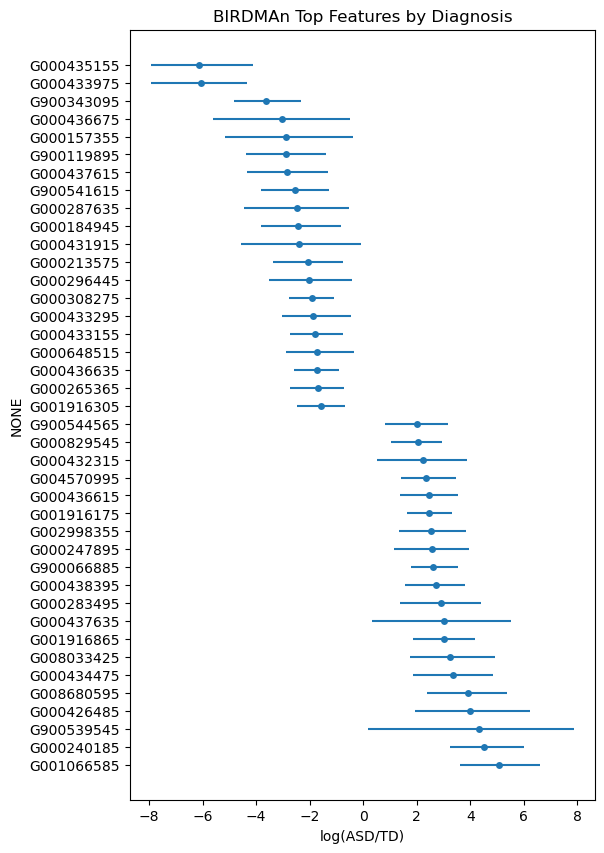

In [166]:
for k in data_dict.keys(): 
    for v in vars_to_check.keys(): 
        if v in k:
            xlab = 'Ratio for ' + v
            var = vars_to_check[v]
            
    print(k)
    ylab = k.split('_')[1] + ' Feature'
    df_for_display = data_dict[k].reset_index()
    df_for_display = df_for_display.loc[df_for_display.credible == 'yes']
    df_for_display = df_for_display.iloc[::-1]
    df_for_display[var+'mean'] = df_for_display[var+'mean'] * -1
    fig, ax = plt.subplots(figsize=(6, 10))
    display_top_n_feats(df_for_display, 20, 'Feature', var+'mean', "log(ASD/TD)", "NONE", "BIRDMAn Top Features by Diagnosis")

In [167]:
taxonomy_new = pd.read_csv('ref/lineages.txt', sep='\t').set_index('Feature ID')

# data prep and taxonomy mapping

for k in data_dict.keys(): 
    for v in vars_to_check.keys(): 
        if v in k:
            xlab = 'Ratio for ' + v
            var = vars_to_check[v]
            
    ylab = k.split('_')[1] + ' Feature'
    df_for_display = data_dict[k].reset_index()
    df_for_display = df_for_display.loc[df_for_display.credible == 'yes']

df = data_dict['ASD_all']
df = df.loc[df.credible == 'yes']
df['taxon'] = taxonomy_new.loc[df.index]['Taxon']
# Function to parse the last two taxonomic levels and clean placeholders
def parse_taxon(taxon):
    levels = taxon.split(';')
    genus = levels[-2].strip() if len(levels) > 1 else ""
    species = levels[-1].strip() if len(levels) > 0 else ""
    
    # Replace placeholder values (e.g., 'g__', 's__') with an empty string
    genus = genus if not genus.endswith("__") else ""
    species = species if not species.endswith("__") else ""
    
    return genus, species

# Apply the function to each taxon entry and expand into two new columns
df['Genus'], df['Species'] = zip(*df['taxon'].apply(parse_taxon))

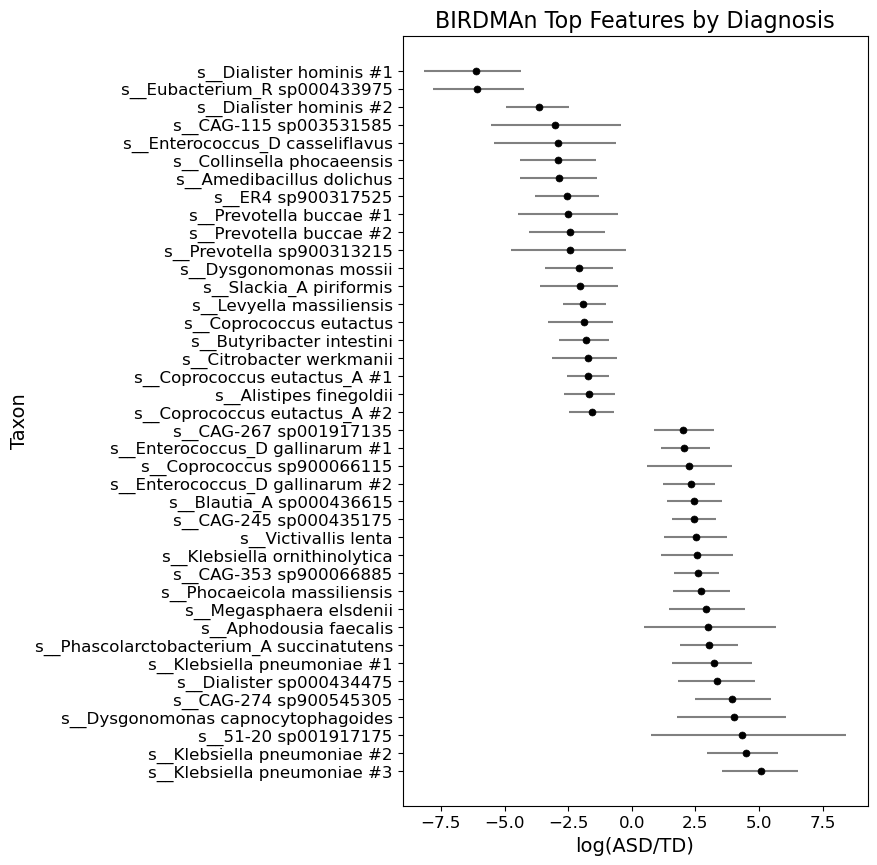

In [172]:
def display_top_n_feats(df, n, yvar, xvar, xlab, ylab, title, invert=False, return_df=False):
    if df.shape[0] < 2*n:
        df_for_display = df.copy()
    else:
        bottomn = df[:n]
        topn = df[-n:]
        df_for_display = pd.concat([bottomn, topn])
    
    # Since TD is first, invert the column to put ASD in the positive
    if invert:
        df_for_display = df_for_display.iloc[::-1]
        df_for_display = df_for_display.copy()  # Avoid SettingWithCopyWarning
        df_for_display[xvar] = df_for_display[xvar] * -1
        df_for_display[['lower', 'upper']] = df_for_display[['upper', 'lower']].values
    
    # Check for duplicated labels
    df_for_display[yvar] = df_for_display[yvar].astype(str)
    duplicates = df_for_display.duplicated(subset=[yvar], keep=False)
    
    # Add a unique sequence number to each duplicated label
    df_for_display.loc[duplicates, yvar] += df_for_display[duplicates].groupby(yvar).cumcount().add(1).astype(str).radd(' #')
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 10))
    sns.stripplot(data=df_for_display, y=yvar, x=xvar, size=5, edgecolor='gray', linewidth=0.5, palette=['black'])
    plt.errorbar(x=df_for_display[xvar], y=np.arange(df_for_display.shape[0]), 
                xerr=df_for_display[['lower', 'upper']].T.values, ls='none', ecolor='gray')
    
    ax.set_ylabel(ylab, fontsize=14, fontweight='normal')
    ax.set_xlabel(xlab, fontsize=14, fontweight='normal')
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
    plt.ylabel(ylab, fontsize=14)
    plt.xlabel(xlab, fontsize=14)
    plt.title(title, fontsize=16)
    plt.show()
    
    fig.savefig('out/figs/195330_none.zebra.tp-td.beta_var.dx+age.flipped.svg', 
                dpi=300, bbox_inches='tight', transparent=True)
    fig.tight_layout()
    
    # Return the DataFrame if requested
    if return_df:
        return df_for_display
    else:
        return None


plot_df = display_top_n_feats(df, 20, 'Species', var+'mean', "log(ASD/TD)", "Taxon", 
                             "BIRDMAn Top Features by Diagnosis", True, return_df=True)

In [ ]:
corrs# Get the BIRDMAn top and bottom 10 features
plot_df = display_top_n_feats(df, 10, 'Species', var+'mean', "log(ASD/TD)", "Taxon",
                              "BIRDMAn Top Features by Diagnosis", True, return_df=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define metabolites of interest with human-readable names
metabolites_of_interest = {
    "4979": "1-beta-D-Glucopyranosyl-L-tryptophan",
    "7540": "Trp-Pro",
    "5043": "L-Tryptophan (NIST14)",
    "5155": "L-Tryptophan (NIST14-2)",
    "5980": "Kynurenic acid",
    "15739": "Candidate Tryptophan-C5:0",
    "33470": "Candidate Tryptophan-C18:1"
}

# Get feature IDs from plot_df index and metabolite IDs
feature_ids = plot_df.index.tolist()
metabolite_ids = list(metabolites_of_interest.keys())

# Create species names using taxonomy_df
species_names = []
for feature_id in feature_ids:
    if feature_id in taxonomy_df.index:
        # Extract species name from taxonomy (assuming it's in 'Taxon' column)
        full_taxon = taxonomy_df.loc[feature_id, 'Taxon']
        # Extract just the species name (s__) part
        if 's__' in full_taxon:
            species_name = full_taxon.split('s__')[-1].split(';')[0].strip()
        else:
            species_name = str(feature_id)  # fallback to feature ID
    else:
        species_name = str(feature_id)  # fallback to feature ID
    # Make unique by appending feature_id
    species_names.append(f"{species_name} ({feature_id})")

# Find available metabolites in correlation matrix
available_mets = []
for met_id in metabolite_ids:
    if met_id in corrs.columns or str(met_id) in corrs.columns:
        available_mets.append(met_id)

print(f"Found {len(available_mets)} metabolites: {available_mets}")
print(f"Using {len(feature_ids)} microbial features from plot_df (top 10 + bottom 10)")

# Subset corrs dataframe to selected OTUs and metabolites
# First, identify which feature_ids are actually in corrs.index
available_features = []
feature_name_mapping = {}

for i, feature_id in enumerate(feature_ids):
    if feature_id in corrs.index:
        available_features.append(feature_id)
        feature_name_mapping[feature_id] = species_names[i]
    elif str(feature_id) in corrs.index:
        available_features.append(str(feature_id))
        feature_name_mapping[str(feature_id)] = species_names[i]

# Similarly for metabolites
available_met_keys = []
met_name_mapping = {}

for met_id in available_mets:
    if met_id in corrs.columns:
        available_met_keys.append(met_id)
        met_name_mapping[met_id] = metabolites_of_interest[met_id]
    elif str(met_id) in corrs.columns:
        available_met_keys.append(str(met_id))
        met_name_mapping[str(met_id)] = metabolites_of_interest[met_id]

print(f"Available features in corrs: {len(available_features)}")
print(f"Available metabolites in corrs: {len(available_met_keys)}")

# Subset the correlation matrix
corrs_subset = corrs.loc[available_features, available_met_keys]

# Rename rows and columns to human-readable names
corrs_subset_renamed = corrs_subset.copy()
corrs_subset_renamed.index = [feature_name_mapping[idx] for idx in corrs_subset.index]
corrs_subset_renamed.columns = [met_name_mapping[col] for col in corrs_subset.columns]

# Create clustered heatmap
plt.figure(figsize=(10, 8))
clustered_heatmap = sns.clustermap(
    corrs_subset_renamed,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt='.2f',
    linewidths=0.5,
    figsize=(10, 8),
    cbar_kws={'label': 'Correlation Coefficient'}
)

clustered_heatmap.ax_row_dendrogram.set_visible(True)
clustered_heatmap.ax_col_dendrogram.set_visible(True)
clustered_heatmap.fig.suptitle('Clustered Heatmap: BIRDMAn Top & Bottom 10 Features vs Tryptophan Metabolites', 
                               fontsize=14, y=0.95)

plt.savefig("out/figs/BIRDMAn_clustered_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Clustered heatmap created with {corrs_subset_renamed.shape[0]} species and {corrs_subset_renamed.shape[1]} metabolites")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get ALL the BIRDMAn features instead of just top/bottom 10
# Assuming you have a way to get all BIRDMAn features, modify this line accordingly
# Option 1: If you want all features from your original dataframe
# all_BIRDMAn_features = df[df['Species'].notna()].index.tolist()

# Option 2: If you want to get all features using your existing function but with a larger n
plot_df = display_top_n_feats(df, len(df), 'Species', var+'mean', "log(ASD/TD)", "Taxon",
                              "All BIRDMAn Features by Diagnosis", True, return_df=True)
all_BIRDMAn_features = plot_df.index.tolist()


# Define metabolites of interest with human-readable names
metabolites_of_interest = {
    "4979": "1-beta-D-Glucopyranosyl-L-tryptophan",
    "7540": "Trp-Pro", 
    "5043": "L-Tryptophan (NIST14)",
    "5155": "L-Tryptophan (NIST14-2)",
    "5980": "Kynurenic acid",
    "15739": "Candidate Tryptophan-C5:0",
    "33470": "Candidate Tryptophan-C18:1"
}

# Get feature IDs from all BIRDMAn features and metabolite IDs
feature_ids = all_BIRDMAn_features
metabolite_ids = list(metabolites_of_interest.keys())

# Create species names using taxonomy_df
species_names = []
for feature_id in feature_ids:
    if feature_id in taxonomy_df.index:
        # Extract species name from taxonomy (assuming it's in 'Taxon' column)
        full_taxon = taxonomy_df.loc[feature_id, 'Taxon']
        # Extract just the species name (s__) part
        if 's__' in full_taxon:
            species_name = full_taxon.split('s__')[-1].split(';')[0].strip()
        else:
            species_name = str(feature_id)  # fallback to feature ID
    else:
        species_name = str(feature_id)  # fallback to feature ID
    
    # Make unique by appending feature_id
    species_names.append(f"{species_name} ({feature_id})")

# Find available metabolites in correlation matrix
available_mets = []
for met_id in metabolite_ids:
    if met_id in corrs.columns or str(met_id) in corrs.columns:
        available_mets.append(met_id)

print(f"Found {len(available_mets)} metabolites: {available_mets}")
print(f"Using {len(feature_ids)} microbial features from all BIRDMAn features")

# Subset corrs dataframe to selected OTUs and metabolites
# First, identify which feature_ids are actually in corrs.index
available_features = []
feature_name_mapping = {}
for i, feature_id in enumerate(feature_ids):
    if feature_id in corrs.index:
        available_features.append(feature_id)
        feature_name_mapping[feature_id] = species_names[i]
    elif str(feature_id) in corrs.index:
        available_features.append(str(feature_id))
        feature_name_mapping[str(feature_id)] = species_names[i]

# Similarly for metabolites
available_met_keys = []
met_name_mapping = {}
for met_id in available_mets:
    if met_id in corrs.columns:
        available_met_keys.append(met_id)
        met_name_mapping[met_id] = metabolites_of_interest[met_id]
    elif str(met_id) in corrs.columns:
        available_met_keys.append(str(met_id))
        met_name_mapping[str(met_id)] = metabolites_of_interest[met_id]

print(f"Available features in corrs: {len(available_features)}")
print(f"Available metabolites in corrs: {len(available_met_keys)}")

# Subset the correlation matrix
corrs_subset = corrs.loc[available_features, available_met_keys]

# Rename rows and columns to human-readable names
corrs_subset_renamed = corrs_subset.copy()
corrs_subset_renamed.index = [feature_name_mapping[idx] for idx in corrs_subset.index]
corrs_subset_renamed.columns = [met_name_mapping[col] for col in corrs_subset.columns]

# Create clustered heatmap with adjusted figure size for more features
plt.figure(figsize=(12, max(8, len(available_features) * 0.3)))  # Dynamic height based on number of features

clustered_heatmap = sns.clustermap(
    corrs_subset_renamed,
    cmap='coolwarm',
    center=0,
    annot=False,  # Turn off annotations for readability with many features
    fmt='.2f',
    linewidths=0.1,  # Thinner lines for better visibility
    figsize=(12, max(10, len(available_features) * 0.3)),  # Dynamic sizing
    cbar_kws={'label': 'Correlation Coefficient'},
    dendrogram_ratio=0.15,  # Adjust dendrogram size
    colors_ratio=0.03  # Adjust color bar size
)

# Adjust font sizes for readability
clustered_heatmap.ax_heatmap.tick_params(labelsize=8)
clustered_heatmap.ax_heatmap.set_xlabel('Tryptophan Metabolites', fontsize=10)
clustered_heatmap.ax_heatmap.set_ylabel('Microbial Species', fontsize=10)

clustered_heatmap.ax_row_dendrogram.set_visible(True)
clustered_heatmap.ax_col_dendrogram.set_visible(True)
clustered_heatmap.fig.suptitle('Clustered Heatmap: All BIRDMAn Features vs Tryptophan Metabolites',
                              fontsize=14, y=0.98)

plt.savefig("out/figs/BIRDMAn_all_features_clustered_heatmap.png", 
           dpi=300, bbox_inches='tight')
plt.show()

print(f"Clustered heatmap created with {corrs_subset_renamed.shape[0]} species and {corrs_subset_renamed.shape[1]} metabolites")

# Optional: Create a simplified version showing only significant correlations
# Filter for correlations above a certain threshold
threshold = 0.3  # Adjust as needed
significant_corrs = corrs_subset_renamed[(corrs_subset_renamed.abs() > threshold).any(axis=1)]

if len(significant_corrs) > 0:
    plt.figure(figsize=(10, max(6, len(significant_corrs) * 0.4)))
    
    significant_heatmap = sns.clustermap(
        significant_corrs,
        cmap='coolwarm',
        center=0,
        annot=True,
        fmt='.2f',
        linewidths=0.5,
        figsize=(10, max(6, len(significant_corrs) * 0.4)),
        cbar_kws={'label': 'Correlation Coefficient'}
    )
    
    significant_heatmap.fig.suptitle(f'Significant Correlations: BIRDMAn Features vs Tryptophan Metabolites (|r| > {threshold})',
                                   fontsize=12, y=0.98)
    
    plt.savefig("out/figs/BIRDMAn_significant_correlations_heatmap.png", 
               dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Significant correlations heatmap created with {significant_corrs.shape[0]} species")
else:
    print(f"No correlations found above threshold |r| > {threshold}")

In [ ]:
probs

In [ ]:
# Get all the BIRDMAn features
plot_df = display_top_n_feats(df, len(df), 'Species', var+'mean', "log(ASD/TD)", "Taxon",
                              "All BIRDMAn Features by Diagnosis", True, return_df=True)

# Extract feature IDs from all BIRDMAn results
BIRDMAn_feature_ids = plot_df.index.tolist()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define metabolites of interest with human-readable names
metabolites_of_interest = {
    "4979": "1-beta-D-Glucopyranosyl-L-tryptophan",
    "7540": "Trp-Pro",
    "5043": "L-Tryptophan (NIST14)",
    "5155": "L-Tryptophan (NIST14-2)",
    "5980": "Kynurenic acid",
    "15739": "Candidate Tryptophan-C5:0",
    "33470": "Candidate Tryptophan-C18:1"
}

metabolite_ids = list(metabolites_of_interest.keys())

# Extract species names from taxonomy data for all BIRDMAn selected features
species_names = []
for feature_id in BIRDMAn_feature_ids:
    if feature_id in taxonomy_df.index:
        full_taxon = taxonomy_df.loc[feature_id, 'Taxon']
        if 's__' in full_taxon:
            species_name = full_taxon.split('s__')[-1].split(';')[0].strip()
        else:
            species_name = str(feature_id)
    else:
        species_name = str(feature_id)
    species_names.append(f"{species_name} ({feature_id})")

# Debug: Check what's in probs matrix
print("Probs matrix shape:", probs.shape)
print("First 10 probs row indices:", probs.index[:10].tolist())
print("First 10 probs column indices:", probs.columns[:10].tolist())
print("Metabolite IDs we're looking for:", metabolite_ids)

# Find available metabolites in probs matrix
available_mets = []
for met_id in metabolite_ids:
    if met_id in probs.index:
        available_mets.append(met_id)
        print(f"Found metabolite {met_id} as exact match")
    elif str(met_id) in probs.index:
        available_mets.append(met_id)
        print(f"Found metabolite {met_id} as string match")
    elif int(met_id) in probs.index:
        available_mets.append(met_id)
        print(f"Found metabolite {met_id} as int match")
    else:
        print(f"Metabolite {met_id} NOT found in probs index")

print(f"Found {len(available_mets)} metabolites: {available_mets}")
print(f"Using {len(BIRDMAn_feature_ids)} microbial features from all BIRDMAn results")

# If no metabolites found, let's check if any of our target metabolites are in probs at all
if len(available_mets) == 0:
    print("\nChecking for partial matches in probs index...")
    for met_id in metabolite_ids:
        matches = [idx for idx in probs.index if str(met_id) in str(idx)]
        if matches:
            print(f"Partial matches for {met_id}: {matches[:5]}")  # Show first 5 matches

# Only proceed if we have metabolites
if len(available_mets) == 0:
    print("ERROR: No metabolites found in probs matrix. Cannot create heatmap.")
    print("Please check the metabolite IDs and probs matrix structure.")
else:
    # Create heatmap_data with correct labels for all BIRDMAn selected features
    heatmap_data = pd.DataFrame(
        0,  # initialize with zeros
        index=species_names,
        columns=[metabolites_of_interest[str(m)] for m in available_mets]
    )

    # Fill heatmap_data by label, not by position
    for i, feature_id in enumerate(BIRDMAn_feature_ids):
        species_name = species_names[i]
        for met_id in available_mets:
            met_name = metabolites_of_interest[str(met_id)]
            prob_val = np.nan
            for met_key in [met_id, str(met_id), int(met_id) if str(met_id).isdigit() else met_id]:
                for feat_key in [feature_id, str(feature_id), int(feature_id) if str(feature_id).isdigit() else feature_id]:
                    if met_key in probs.index and feat_key in probs.columns:
                        prob_val = probs.loc[met_key, feat_key]
                        break
                if not np.isnan(prob_val):
                    break
            heatmap_data.at[species_name, met_name] = prob_val

    heatmap_data = heatmap_data.apply(pd.to_numeric, errors='coerce')
    heatmap_data = heatmap_data.dropna(how='all')

    print(f"Heatmap data shape: {heatmap_data.shape}")
    print(f"Non-null values: {heatmap_data.notna().sum().sum()}")
    print(f"Data range: {heatmap_data.min().min()} to {heatmap_data.max().max()}")
    
    # Check for any issues with the data
    print(f"Any infinite values: {np.isinf(heatmap_data).any().any()}")
    print(f"Any NaN values: {heatmap_data.isna().any().any()}")
    
    # Replace any remaining NaN values with 0 for clustering
    heatmap_data_clean = heatmap_data.fillna(0)

    # Scale probabilities for better visualization
    factor = 100000
    heatmap_data_scaled = heatmap_data_clean * factor
    
    print(f"Scaled data shape: {heatmap_data_scaled.shape}")
    print(f"Scaled data range: {heatmap_data_scaled.min().min()} to {heatmap_data_scaled.max().max()}")

    # Create clustered heatmap (same style as corrs clustermap)
    try:
        # Try clustering with specific parameters to avoid issues
        clustered_heatmap = sns.clustermap(
            heatmap_data_scaled,
            cmap='viridis',
            annot=True,
            fmt='.2f',
            linewidths=0.5,
            figsize=(12, max(len(heatmap_data_scaled) * 0.3, 8)),  # Make figure bigger and scale with data
            vmin=0,
            vmax=10,  ### POINT THIS OUT TO LUCAS
            cbar_kws={'label': f'Probability × {factor}'},
            method='average',  # Use average linkage
            metric='euclidean',  # Use euclidean distance
            row_cluster=True,
            col_cluster=True,
            annot_kws={'size': 8}  # Make annotation text smaller for readability
        )

        clustered_heatmap.ax_row_dendrogram.set_visible(True)
        clustered_heatmap.ax_col_dendrogram.set_visible(True)
        clustered_heatmap.fig.suptitle('Clustered Heatmap: All BIRDMAn Features - Tryptophan Metabolite Probabilities (MMVEC)', 
                                       fontsize=14, y=0.95)

        plt.savefig("out/figs/all_BIRDMAn_clustered_probs_heatmap.png", dpi=300, bbox_inches='tight')
        plt.show()

        print(f"Clustered heatmap created with {heatmap_data_scaled.shape[0]} species and {heatmap_data_scaled.shape[1]} metabolites")
        
    except Exception as e:
        print(f"Clustering failed with error: {e}")
        print("Trying alternative clustering parameters...")
        
        try:
            # Try with different clustering parameters
            clustered_heatmap = sns.clustermap(
                heatmap_data_scaled,
                cmap='viridis',
                annot=True,
                fmt='.2f',
                linewidths=0.5,
                figsize=(12, max(len(heatmap_data_scaled) * 0.3, 8)),  # Make figure bigger and scale with data
                vmin=0,
                vmax=10,
                cbar_kws={'label': f'Probability × {factor}'},
                method='complete',
                metric='correlation',
                row_cluster=True,
                col_cluster=True,
                annot_kws={'size': 8}  # Make annotation text smaller for readability
            )
            
            clustered_heatmap.fig.suptitle('Clustered Heatmap: All BIRDMAn Features - Tryptophan Metabolite Probabilities (MMVEC)', 
                                           fontsize=14, y=0.95)
            plt.savefig("out/figs/all_BIRDMAn_clustered_probs_heatmap.png", dpi=300, bbox_inches='tight')
            plt.show()
            print("Alternative clustering successful!")
            
        except Exception as e2:
            print(f"Alternative clustering also failed: {e2}")
            print("Creating regular heatmap instead...")
            
            plt.figure(figsize=(12, max(len(heatmap_data_scaled) * 0.3, 8)))  # Make figure bigger and scale with data
            sns.heatmap(
                heatmap_data_scaled,
                cmap='viridis',
                annot=True,
                fmt='.2f',
                linewidths=0.5,
                vmin=0,
                vmax=10,  ### POINT THIS OUT TO LUCAS
                cbar_kws={'label': f'Probability × {factor}'},
                annot_kws={'size': 8}  # Make annotation text smaller for readability
            )
            plt.title('All BIRDMAn Features - Tryptophan Metabolite Probabilities (MMVEC)', fontsize=14)
            plt.ylabel('Microbial Species', fontsize=12)
            plt.xlabel('Tryptophan Metabolites', fontsize=12)
            plt.tight_layout()
            plt.savefig("out/figs/all_BIRDMAn_probs_heatmap_fallback.png", dpi=300, bbox_inches='tight')
            plt.show()
            print("Regular heatmap created successfully!")

# N-Acyl Lipids

In [ ]:
acyl = pd.read_csv("mzmine/list_acyl.csv", index_col=0)
acyl

In [ ]:
plsda_vip

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as math

def create_asd_mmvec_corrs_heatmap(plot_df, corrs, acyl, plsda_vip, taxonomy_df, 
                                  n_top_metabolites=75, scale_factor=100000):
    """
    Create clustered heatmap focusing on top 50 ASD-enriched features and their 
    top co-occurring metabolites from correlation matrix
    
    Parameters:
    - plot_df: DataFrame from BIRDMAn display_top_n_feats function
    - corrs: Correlation matrix (square matrix with microbes+metabolites in both rows and columns)
    - acyl: metabolite annotation dataframe with 'Compound_Name' column
    - plsda_vip: PLS-DA VIP results dataframe  
    - taxonomy_df: taxonomy dataframe with 'Taxon' column
    - n_top_metabolites: number of top co-occurring metabolites to include (50-100)
    - scale_factor: not used for correlations, kept for compatibility
    """
    
    # Filter for ASD-enriched features only (positive dx[T.TD]_mean values)
    asd_features = plot_df[plot_df['dx[T.TD]_mean'] > 0]
    
    # Take top 50 ASD features by absolute coefficient value
    asd_features_sorted = asd_features.reindex(asd_features['dx[T.TD]_mean'].abs().sort_values(ascending=False).index)
    top_50_asd_features = asd_features_sorted.head(50)
    
    print(f"Selected {len(top_50_asd_features)} ASD-enriched features")
    
    # Get the feature IDs
    asd_feature_ids = top_50_asd_features.index.tolist()
    
    # Extract species names from taxonomy data for selected ASD features
    asd_species_names = []
    for feature_id in asd_feature_ids:
        if feature_id in taxonomy_df.index:
            full_taxon = taxonomy_df.loc[feature_id, 'Taxon']
            if 's__' in full_taxon:
                species_name = full_taxon.split('s__')[-1].split(';')[0].strip()
            else:
                species_name = str(feature_id)
        else:
            species_name = str(feature_id)
        
        # Add ASD label and coefficient value
        dx_value = top_50_asd_features.loc[feature_id, 'dx[T.TD]_mean']
        asd_species_names.append(f"{species_name} ({feature_id}) - ASD [{dx_value:.3f}]")
    
    print("Debug: Checking corrs matrix structure")
    print("Corrs matrix shape:", corrs.shape)
    print("First 5 corrs row indices:", corrs.index[:5].tolist())
    print("First 5 corrs column indices:", corrs.columns[:5].tolist())
    
    # Find which ASD feature IDs are available in corrs matrix
    available_asd_features = []
    feature_id_mapping = {}  # Map original ID to corrs matrix ID
    
    for feature_id in asd_feature_ids:
        found = False
        # Try different formats - check both rows and columns since it's a square matrix
        for potential_key in [feature_id, str(feature_id), int(feature_id) if str(feature_id).isdigit() else None]:
            if potential_key is not None and potential_key in corrs.columns:
                available_asd_features.append(feature_id)
                feature_id_mapping[feature_id] = potential_key
                found = True
                break
        if not found:
            print(f"Warning: ASD feature {feature_id} not found in corrs matrix")
    
    print(f"Found {len(available_asd_features)} ASD features in corrs matrix")
    
    if len(available_asd_features) == 0:
        print("ERROR: No ASD features found in corrs matrix!")
        return None
    
    # For each available ASD feature, get its correlation values across all metabolites
    # and sum the absolute values to find metabolites with highest co-occurrence
    # First, identify which rows in corrs are metabolites (not microbes)
    print("Identifying metabolites in corrs matrix using ID patterns...")
    
    # Use ID patterns to distinguish metabolites from microbes
    # Microbes: GXXXXXXXXX (where X are numbers)
    # Metabolites: 4 or 5 digit numbers
    def is_metabolite(idx):
        idx_str = str(idx)
        # Check if it's a 4 or 5 digit number
        if idx_str.isdigit() and len(idx_str) in [4, 5]:
            return True
        return False
    
    def is_microbe(idx):
        idx_str = str(idx)
        # Check if it follows GXXXXXXXXX pattern (G followed by 9 digits)
        if len(idx_str) == 10 and idx_str.startswith('G') and idx_str[1:].isdigit():
            return True
        return False
    
    # Find metabolite IDs in corrs matrix
    potential_metabolite_keys = []
    for idx in corrs.index:
        if is_metabolite(idx):
            potential_metabolite_keys.append(idx)
    
    print(f"Found {len(potential_metabolite_keys)} potential metabolites in corrs matrix")
    
    # Calculate co-occurrence scores using absolute correlation values
    metabolite_scores = pd.Series(0.0, index=potential_metabolite_keys)
    
    for metabolite_key in potential_metabolite_keys:
        total_corr = 0.0
        for feature_id in available_asd_features:
            corrs_feature_key = feature_id_mapping[feature_id]
            # Sum absolute correlation values between this metabolite and ASD microbes
            if metabolite_key in corrs.index and corrs_feature_key in corrs.columns:
                total_corr += abs(corrs.loc[metabolite_key, corrs_feature_key])
        metabolite_scores[metabolite_key] = total_corr
    
    # Sort metabolites by total co-occurrence score and take top N
    top_metabolites_by_score = metabolite_scores.sort_values(ascending=False).head(n_top_metabolites)
    top_metabolite_keys = top_metabolites_by_score.index.tolist()
    
    print(f"Selected top {len(top_metabolite_keys)} metabolites by correlation co-occurrence score")
    print(f"Score range: {top_metabolites_by_score.min():.6f} to {top_metabolites_by_score.max():.6f}")
    
    # Map metabolite keys back to original IDs and get names from acyl dataframe
    metabolite_names = []
    available_metabolites = []
    metabolite_id_mapping = {}
    
    for met_key in top_metabolite_keys:
        # Try to find this key in acyl index with different formats
        original_met_id = None
        for potential_id in [met_key, str(met_key), int(met_key) if str(met_key).isdigit() else None]:
            if potential_id is not None and potential_id in acyl.index:
                original_met_id = potential_id
                break
        
        if original_met_id is not None and original_met_id in acyl.index:
            compound_name = acyl.loc[original_met_id, 'Compound_Name']
            if pd.notna(compound_name) and compound_name != '':
                metabolite_names.append(f"{compound_name} ({original_met_id})")
            else:
                metabolite_names.append(f"Metabolite_{original_met_id}")
        else:
            metabolite_names.append(f"Metabolite_{met_key}")
        
        available_metabolites.append(met_key)
        metabolite_id_mapping[met_key] = met_key
    
    print(f"Final dataset: {len(available_asd_features)} ASD microbes × {len(available_metabolites)} metabolites")
    
    # Create heatmap data matrix using correlations
    heatmap_data = pd.DataFrame(
        index=[asd_species_names[i] for i, fid in enumerate(asd_feature_ids) if fid in available_asd_features],
        columns=metabolite_names
    )
    
    # Fill the heatmap data with correlations
    row_idx = 0
    for i, feature_id in enumerate(asd_feature_ids):
        if feature_id in available_asd_features:
            corrs_feature_key = feature_id_mapping[feature_id]
            
            for j, met_key in enumerate(available_metabolites):
                # Get correlation between metabolite (row) and microbe (column)
                corr_val = corrs.loc[met_key, corrs_feature_key]
                heatmap_data.iloc[row_idx, j] = corr_val
            
            row_idx += 1
    
    # Convert to numeric and handle any issues
    heatmap_data = heatmap_data.apply(pd.to_numeric, errors='coerce')
    
    print(f"Heatmap data shape: {heatmap_data.shape}")
    print(f"Data range: {heatmap_data.min().min():.6f} to {heatmap_data.max().max():.6f}")
    print(f"Non-null values: {heatmap_data.notna().sum().sum()}")
    
    # For correlations, use values directly (no log transformation needed)
    heatmap_data_clean = heatmap_data.fillna(0)
    
    print(f"Correlation data range: {heatmap_data_clean.min().min():.6f} to {heatmap_data_clean.max().max():.6f}")
    
    # Create clustered heatmap
    try:
        fig_width = max(12, len(available_metabolites) * 0.3)
        fig_height = max(15, len(available_asd_features) * 0.6)
        
        # Use RdBu_r colormap for correlations (red=positive, blue=negative)
        clustered_heatmap = sns.clustermap(
            heatmap_data_clean,
            cmap='RdBu_r',
            annot=False,
            linewidths=0.1,
            figsize=(fig_width, fig_height),
            cbar_kws={'label': 'Correlation'},
            method='average',
            metric='euclidean',
            row_cluster=True,
            col_cluster=True,
            xticklabels=True,
            yticklabels=True,
            center=0,  # Center colormap at 0
            vmin=-1,
            vmax=1
        )
        
        # Customize the plot
        clustered_heatmap.fig.suptitle(
            f'Top 50 ASD-Enriched Microbes vs Top {n_top_metabolites} Co-occurring Metabolites\n(Correlation Matrix)', 
            fontsize=14, y=0.98
        )
        
        # Rotate x-axis labels for better readability
        plt.setp(clustered_heatmap.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=10)
        plt.setp(clustered_heatmap.ax_heatmap.get_yticklabels(), fontsize=10)
        
        plt.tight_layout()
        
        print(f"Successfully created clustered correlation heatmap!")
        print(f"Final dimensions: {heatmap_data_clean.shape[0]} microbes × {heatmap_data_clean.shape[1]} metabolites")
        
        return clustered_heatmap, heatmap_data_clean
        
    except Exception as e:
        print(f"Clustering failed with error: {e}")
        print("Creating regular heatmap instead...")
        
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(
            heatmap_data_clean,
            cmap='RdBu_r',
            annot=False,
            linewidths=0.1,
            cbar_kws={'label': 'Correlation'},
            xticklabels=True,
            yticklabels=True,
            center=0,
            vmin=-1,
            vmax=1
        )
        
        plt.title(f'Top 50 ASD-Enriched Microbes vs Top {n_top_metabolites} Co-occurring Metabolites\n(Correlation Matrix)', 
                  fontsize=14)
        plt.xlabel('Metabolites', fontsize=12)
        plt.ylabel('ASD-Enriched Microbes', fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout()
        
        print("Regular correlation heatmap created successfully!")
        return None, heatmap_data_clean

# Usage example:
# Make sure your plot_df contains the BIRDMAn results
plot_df = display_top_n_feats(df, 100, 'Species', var+'mean', "log(ASD/TD)", "Taxon",
                             "BIRDMAn Top Features by Diagnosis", True, return_df=True)

# Create the ASD-focused correlation heatmap
heatmap_result, heatmap_data = create_asd_mmvec_corrs_heatmap(
    plot_df, corrs, acyl, plsda_vip, taxonomy_df, 
    n_top_metabolites=50  # You can adjust this between 50-100
)

plt.show()

# Optional: Save the data for further analysis
if heatmap_data is not None:
    heatmap_data.to_csv('asd_microbes_metabolites_cooccurrence_correlation_heatmap_data.csv')
    print("Co-occurrence correlation heatmap data saved to 'asd_microbes_metabolites_cooccurrence_correlation_heatmap_data.csv'")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as math

def create_asd_mmvec_corrs_heatmap(plot_df, corrs, acyl, plsda_vip, taxonomy_df, 
                                  n_top_metabolites=75, scale_factor=100000):
    """
    Create clustered heatmap focusing on top 50 ASD-enriched features and their 
    correlations with top metabolites from correlation matrix
    
    Parameters:
    - plot_df: DataFrame from BIRDMAn display_top_n_feats function
    - corrs: Correlation matrix (square matrix with microbes+metabolites in both rows and columns)
    - acyl: metabolite annotation dataframe with 'Compound_Name' column
    - plsda_vip: PLS-DA VIP results dataframe
    - taxonomy_df: taxonomy dataframe with 'Taxon' column
    - n_top_metabolites: number of top metabolites to include (50-100)
    - scale_factor: not used for correlations, kept for compatibility
    """
    
    # Filter for ASD-enriched features only (positive dx[T.TD]_mean values)
    asd_features = plot_df[plot_df['dx[T.TD]_mean'] > 0]
    
    # Take top 50 ASD features by absolute coefficient value
    asd_features_sorted = asd_features.reindex(asd_features['dx[T.TD]_mean'].abs().sort_values(ascending=False).index)
    top_50_asd_features = asd_features_sorted.head(50)
    
    print(f"Selected {len(top_50_asd_features)} ASD-enriched features")
    
    # Get the feature IDs
    asd_feature_ids = top_50_asd_features.index.tolist()
    
    # Extract species names from taxonomy data for selected ASD features
    asd_species_names = []
    for feature_id in asd_feature_ids:
        if feature_id in taxonomy_df.index:
            full_taxon = taxonomy_df.loc[feature_id, 'Taxon']
            if 's__' in full_taxon:
                species_name = full_taxon.split('s__')[-1].split(';')[0].strip()
            else:
                species_name = str(feature_id)
        else:
            species_name = str(feature_id)
        
        # Add ASD label and coefficient value
        dx_value = top_50_asd_features.loc[feature_id, 'dx[T.TD]_mean']
        asd_species_names.append(f"{species_name} ({feature_id}) - ASD [{dx_value:.3f}]")
    
    print("Debug: Checking corrs matrix structure")
    print("Corrs matrix shape:", corrs.shape)
    print("First 5 corrs row indices:", corrs.index[:5].tolist())
    print("First 5 corrs column indices:", corrs.columns[:5].tolist())
    
    # Find which ASD feature IDs are available in corrs matrix
    available_asd_features = []
    feature_id_mapping = {}  # Map original ID to corrs matrix ID
    
    for feature_id in asd_feature_ids:
        found = False
        # Try different formats - check both rows and columns since it's a square matrix
        for potential_key in [feature_id, str(feature_id), int(feature_id) if str(feature_id).isdigit() else None]:
            if potential_key is not None and potential_key in corrs.columns:
                available_asd_features.append(feature_id)
                feature_id_mapping[feature_id] = potential_key
                found = True
                break
        if not found:
            print(f"Warning: ASD feature {feature_id} not found in corrs matrix")
    
    print(f"Found {len(available_asd_features)} ASD features in corrs matrix")
    
    if len(available_asd_features) == 0:
        print("ERROR: No ASD features found in corrs matrix!")
        return None
    
    # Get top metabolites based on PLS-DA VIP comp1 values
    print("Debug: Checking plsda_vip structure")
    print("PLS-DA VIP shape:", plsda_vip.shape)
    print("PLS-DA VIP columns:", plsda_vip.columns.tolist())
    print("First 5 PLS-DA VIP indices:", plsda_vip.index[:5].tolist())
    
    if 'comp1' not in plsda_vip.columns:
        print("ERROR: 'comp1' column not found in plsda_vip DataFrame!")
        print("Available columns:", plsda_vip.columns.tolist())
        return None
    
    # Sort metabolites by PLS-DA VIP comp1 values (take absolute values to get top features regardless of direction)
    plsda_sorted = plsda_vip['comp1'].abs().sort_values(ascending=False)
    top_plsda_metabolites = plsda_sorted.head(n_top_metabolites)
    top_metabolite_ids = top_plsda_metabolites.index.tolist()
    
    print(f"Selected top {len(top_metabolite_ids)} metabolites by PLS-DA VIP comp1 values")
    print(f"VIP comp1 range: {top_plsda_metabolites.min():.6f} to {top_plsda_metabolites.max():.6f}")
    
    # Filter to only include metabolites that are also in the corrs matrix
    available_metabolite_ids = []
    metabolite_id_mapping = {}  # Map original ID to corrs matrix ID
    
    for met_id in top_metabolite_ids:
        found = False
        for potential_key in [met_id, str(met_id), int(met_id) if str(met_id).isdigit() else None]:
            if potential_key is not None and potential_key in corrs.index:
                available_metabolite_ids.append(met_id)
                metabolite_id_mapping[met_id] = potential_key
                found = True
                break
        if not found:
            print(f"Warning: Metabolite {met_id} from PLS-DA not found in corrs matrix")
    
    print(f"Found {len(available_metabolite_ids)} PLS-DA metabolites in corrs matrix")
    
    # Get metabolite names from acyl dataframe where available
    metabolite_names = []
    available_metabolites = []
    
    for met_id in available_metabolite_ids:
        if met_id in acyl.index:
            compound_name = acyl.loc[met_id, 'Compound_Name']
            if pd.notna(compound_name) and compound_name != '':
                vip_value = plsda_vip.loc[met_id, 'comp1']
                metabolite_names.append(f"{compound_name} ({met_id}) [VIP:{vip_value:.3f}]")
            else:
                vip_value = plsda_vip.loc[met_id, 'comp1']
                metabolite_names.append(f"Metabolite_{met_id} [VIP:{vip_value:.3f}]")
            available_metabolites.append(met_id)
        else:
            vip_value = plsda_vip.loc[met_id, 'comp1']
            metabolite_names.append(f"Metabolite_{met_id} [VIP:{vip_value:.3f}]")
            available_metabolites.append(met_id)
    
    print(f"Final dataset: {len(available_asd_features)} ASD microbes × {len(available_metabolites)} PLS-DA VIP metabolites")
    
    # Create heatmap data matrix using correlations
    heatmap_data = pd.DataFrame(
        index=[asd_species_names[i] for i, fid in enumerate(asd_feature_ids) if fid in available_asd_features],
        columns=metabolite_names
    )
    
    # Fill the heatmap data with correlations
    row_idx = 0
    for i, feature_id in enumerate(asd_feature_ids):
        if feature_id in available_asd_features:
            corrs_feature_key = feature_id_mapping[feature_id]
            
            for j, met_id in enumerate(available_metabolites):
                corrs_metabolite_key = metabolite_id_mapping[met_id]
                # Get correlation between metabolite (row) and microbe (column)
                corr_val = corrs.loc[corrs_metabolite_key, corrs_feature_key]
                heatmap_data.iloc[row_idx, j] = corr_val
            
            row_idx += 1
    
    # Convert to numeric and handle any issues
    heatmap_data = heatmap_data.apply(pd.to_numeric, errors='coerce')
    
    print(f"Heatmap data shape: {heatmap_data.shape}")
    print(f"Data range: {heatmap_data.min().min():.6f} to {heatmap_data.max().max():.6f}")
    print(f"Non-null values: {heatmap_data.notna().sum().sum()}")
    
    # For correlations, use values directly (no log transformation needed)
    heatmap_data_clean = heatmap_data.fillna(0)
    
    print(f"Correlation data range: {heatmap_data_clean.min().min():.6f} to {heatmap_data_clean.max().max():.6f}")
    
    # Create clustered heatmap
    try:
        fig_width = max(12, len(available_metabolites) * 0.3)
        fig_height = max(15, len(available_asd_features) * 0.6)
        
        # Use RdBu_r colormap for correlations (red=positive, blue=negative)
        clustered_heatmap = sns.clustermap(
            heatmap_data_clean,
            cmap='RdBu_r',
            annot=False,
            linewidths=0.1,
            figsize=(fig_width, fig_height),
            cbar_kws={'label': 'Correlation'},
            method='average',
            metric='euclidean',
            row_cluster=True,
            col_cluster=True,
            xticklabels=True,
            yticklabels=True,
            center=0,  # Center colormap at 0
            vmin=-1,
            vmax=1
        )
        
        # Customize the plot
        clustered_heatmap.fig.suptitle(
            f'Top 50 ASD-Enriched Microbes vs Top {n_top_metabolites} PLS-DA VIP Metabolites\n(Correlation Matrix)', 
            fontsize=14, y=0.98
        )
        
        # Rotate x-axis labels for better readability
        plt.setp(clustered_heatmap.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=12)
        plt.setp(clustered_heatmap.ax_heatmap.get_yticklabels(), fontsize=12)
        
        plt.tight_layout()
        
        print(f"Successfully created clustered correlation heatmap!")
        print(f"Final dimensions: {heatmap_data_clean.shape[0]} microbes × {heatmap_data_clean.shape[1]} metabolites")
        
        return clustered_heatmap, heatmap_data_clean
        
    except Exception as e:
        print(f"Clustering failed with error: {e}")
        print("Creating regular heatmap instead...")
        
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(
            heatmap_data_clean,
            cmap='RdBu_r',
            annot=False,
            linewidths=0.1,
            cbar_kws={'label': 'Correlation'},
            xticklabels=True,
            yticklabels=True,
            center=0,
            vmin=-1,
            vmax=1
        )
        
        plt.title(f'Top 50 ASD-Enriched Microbes vs Top {n_top_metabolites} PLS-DA VIP Metabolites\n(Correlation Matrix)', 
                  fontsize=14)
        plt.xlabel('Metabolites', fontsize=12)
        plt.ylabel('ASD-Enriched Microbes', fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        
        print("Regular correlation heatmap created successfully!")
        return None, heatmap_data_clean

# Usage example:
# Make sure your plot_df contains the BIRDMAn results
plot_df = display_top_n_feats(df, 100, 'Species', var+'mean', "log(ASD/TD)", "Taxon",
                             "BIRDMAn Top Features by Diagnosis", True, return_df=True)

# Create the ASD-focused correlation heatmap
heatmap_result, heatmap_data = create_asd_mmvec_corrs_heatmap(
    plot_df, corrs, acyl, plsda_vip, taxonomy_df, 
    n_top_metabolites=50  # You can adjust this between 50-100
)

plt.show()

# Optional: Save the data for further analysis
if heatmap_data is not None:
    heatmap_data.to_csv('asd_microbes_metabolites_correlation_heatmap_data.csv')
    print("Correlation heatmap data saved to 'asd_microbes_metabolites_correlation_heatmap_data.csv'")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as math

def create_asd_corrs_heatmap(plot_df, corrs, acyl, plsda_vip, taxonomy_df, 
                            n_top_metabolites=75, scale_factor=100000):
    """
    Create clustered heatmap focusing on top 50 ASD-enriched features and their 
    correlations with top metabolites from correlation matrix
    
    Parameters:
    - plot_df: DataFrame from BIRDMAn display_top_n_feats function
    - corrs: Correlation matrix (square matrix with microbes+metabolites in both rows and columns)
    - acyl: metabolite annotation dataframe with 'Compound_Name' column
    - plsda_vip: PLS-DA VIP results dataframe
    - taxonomy_df: taxonomy dataframe with 'Taxon' column
    - n_top_metabolites: number of top metabolites to include (50-100)
    - scale_factor: not used for correlations, kept for compatibility
    """
    
    # Filter for ASD-enriched features only (positive dx[T.TD]_mean values)
    asd_features = plot_df[plot_df['dx[T.TD]_mean'] > 0]
    
    # Take top 50 ASD features by absolute coefficient value
    asd_features_sorted = asd_features.reindex(asd_features['dx[T.TD]_mean'].abs().sort_values(ascending=False).index)
    top_50_asd_features = asd_features_sorted.head(50)
    
    print(f"Selected {len(top_50_asd_features)} ASD-enriched features")
    
    # Get the feature IDs
    asd_feature_ids = top_50_asd_features.index.tolist()
    
    # Extract species names from taxonomy data for selected ASD features
    asd_species_names = []
    for feature_id in asd_feature_ids:
        if feature_id in taxonomy_df.index:
            full_taxon = taxonomy_df.loc[feature_id, 'Taxon']
            if 's__' in full_taxon:
                species_name = full_taxon.split('s__')[-1].split(';')[0].strip()
            else:
                species_name = str(feature_id)
        else:
            species_name = str(feature_id)
        
        # Add ASD label and coefficient value
        dx_value = top_50_asd_features.loc[feature_id, 'dx[T.TD]_mean']
        asd_species_names.append(f"{species_name} ({feature_id}) - ASD [{dx_value:.3f}]")
    
    print("Debug: Checking corrs matrix structure")
    print("Corrs matrix shape:", corrs.shape)
    print("First 5 corrs row indices:", corrs.index[:5].tolist())
    print("First 5 corrs column indices:", corrs.columns[:5].tolist())
    
    # Find which ASD feature IDs are available in corrs matrix (both rows and columns)
    available_asd_features = []
    feature_id_mapping = {}  # Map original ID to corrs matrix ID
    
    for feature_id in asd_feature_ids:
        found = False
        # Try different formats - check both rows and columns since it's a square matrix
        for potential_key in [feature_id, str(feature_id), int(feature_id) if str(feature_id).isdigit() else None]:
            if potential_key is not None and potential_key in corrs.columns:
                available_asd_features.append(feature_id)
                feature_id_mapping[feature_id] = potential_key
                found = True
                break
        if not found:
            print(f"Warning: ASD feature {feature_id} not found in corrs matrix")
    
    print(f"Found {len(available_asd_features)} ASD features in corrs matrix")
    
    if len(available_asd_features) == 0:
        print("ERROR: No ASD features found in corrs matrix!")
        return None
    
    # Get top metabolites based on PLS-DA VIP comp1 values
    print("Debug: Checking plsda_vip structure")
    print("PLS-DA VIP shape:", plsda_vip.shape)
    print("PLS-DA VIP columns:", plsda_vip.columns.tolist())
    print("First 5 PLS-DA VIP indices:", plsda_vip.index[:5].tolist())
    
    if 'comp1' not in plsda_vip.columns:
        print("ERROR: 'comp1' column not found in plsda_vip DataFrame!")
        print("Available columns:", plsda_vip.columns.tolist())
        return None
    
    # Sort metabolites by PLS-DA VIP comp1 values (take absolute values to get top features regardless of direction)
    plsda_sorted = plsda_vip['comp1'].abs().sort_values(ascending=False)
    top_plsda_metabolites = plsda_sorted.head(n_top_metabolites)
    top_metabolite_ids = top_plsda_metabolites.index.tolist()
    
    print(f"Selected top {len(top_metabolite_ids)} metabolites by PLS-DA VIP comp1 values")
    print(f"VIP comp1 range: {top_plsda_metabolites.min():.6f} to {top_plsda_metabolites.max():.6f}")
    
    # Filter to only include metabolites that are also in the corrs matrix rows
    available_metabolite_ids = []
    metabolite_id_mapping = {}  # Map original ID to corrs matrix ID
    
    for met_id in top_metabolite_ids:
        found = False
        for potential_key in [met_id, str(met_id), int(met_id) if str(met_id).isdigit() else None]:
            if potential_key is not None and potential_key in corrs.index:
                available_metabolite_ids.append(met_id)
                metabolite_id_mapping[met_id] = potential_key
                found = True
                break
        if not found:
            print(f"Warning: Metabolite {met_id} from PLS-DA not found in corrs matrix")
    
    print(f"Found {len(available_metabolite_ids)} PLS-DA metabolites in corrs matrix")
    
    # Get metabolite names from acyl dataframe where available
    metabolite_names = []
    available_metabolites = []
    
    for met_id in available_metabolite_ids:
        if met_id in acyl.index:
            compound_name = acyl.loc[met_id, 'Compound_Name']
            if pd.notna(compound_name) and compound_name != '':
                vip_value = plsda_vip.loc[met_id, 'comp1']
                metabolite_names.append(f"{compound_name} ({met_id}) [VIP:{vip_value:.3f}]")
            else:
                vip_value = plsda_vip.loc[met_id, 'comp1']
                metabolite_names.append(f"Metabolite_{met_id} [VIP:{vip_value:.3f}]")
            available_metabolites.append(met_id)
        else:
            vip_value = plsda_vip.loc[met_id, 'comp1']
            metabolite_names.append(f"Metabolite_{met_id} [VIP:{vip_value:.3f}]")
            available_metabolites.append(met_id)
    
    print(f"Final dataset: {len(available_asd_features)} ASD microbes × {len(available_metabolites)} PLS-DA VIP metabolites")
    
    # Create heatmap data matrix using correlations
    heatmap_data = pd.DataFrame(
        index=[asd_species_names[i] for i, fid in enumerate(asd_feature_ids) if fid in available_asd_features],
        columns=metabolite_names
    )
    
    # Fill the heatmap data with correlations between metabolites (rows) and microbes (columns)
    row_idx = 0
    for i, feature_id in enumerate(asd_feature_ids):
        if feature_id in available_asd_features:
            corrs_feature_key = feature_id_mapping[feature_id]
            
            for j, met_id in enumerate(available_metabolites):
                corrs_metabolite_key = metabolite_id_mapping[met_id]
                # Get correlation between metabolite (row) and microbe (column)
                corr_val = corrs.loc[corrs_metabolite_key, corrs_feature_key]
                heatmap_data.iloc[row_idx, j] = corr_val
            
            row_idx += 1
    
    # Convert to numeric and handle any issues
    heatmap_data = heatmap_data.apply(pd.to_numeric, errors='coerce')
    
    print(f"Heatmap data shape: {heatmap_data.shape}")
    print(f"Data range: {heatmap_data.min().min():.6f} to {heatmap_data.max().max():.6f}")
    print(f"Non-null values: {heatmap_data.notna().sum().sum()}")
    
    # For correlations, we don't need log transformation - use the values directly
    heatmap_data_clean = heatmap_data.fillna(0)
    
    print(f"Correlation data range: {heatmap_data_clean.min().min():.6f} to {heatmap_data_clean.max().max():.6f}")
    
    # Create clustered heatmap
    try:
        fig_width = max(15, len(available_metabolites) * 0.5)  # Increased width multiplier and minimum
        fig_height = max(15, len(available_asd_features) * 0.6)
        
        # Use RdBu_r colormap which is good for correlations (red=positive, blue=negative)
        clustered_heatmap = sns.clustermap(
            heatmap_data_clean,
            cmap='RdBu_r',
            annot=False,
            linewidths=0.1,
            figsize=(fig_width, fig_height),
            cbar_kws={'label': 'Correlation'},
            method='average',
            metric='euclidean',
            row_cluster=True,
            col_cluster=True,
            xticklabels=True,
            yticklabels=True,
            center=0,  # Center colormap at 0 for correlations
            vmin=-1,
            vmax=1
        )
        
        # Customize the plot
        clustered_heatmap.fig.suptitle(
            f'Top 50 ASD-Enriched Microbes vs Top {n_top_metabolites} PLS-DA VIP Metabolites\n(Correlation Matrix)', 
            fontsize=14, y=0.98
        )
        
        # Rotate x-axis labels for better readability
        plt.setp(clustered_heatmap.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=12)
        plt.setp(clustered_heatmap.ax_heatmap.get_yticklabels(), fontsize=12)
        
        plt.tight_layout()
        
        print(f"Successfully created clustered correlation heatmap!")
        print(f"Final dimensions: {heatmap_data_clean.shape[0]} microbes × {heatmap_data_clean.shape[1]} metabolites")
        
        return clustered_heatmap, heatmap_data_clean
        
    except Exception as e:
        print(f"Clustering failed with error: {e}")
        print("Creating regular heatmap instead...")
        
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(
            heatmap_data_clean,
            cmap='RdBu_r',
            annot=False,
            linewidths=0.1,
            cbar_kws={'label': 'Correlation'},
            xticklabels=True,
            yticklabels=True,
            center=0,
            vmin=-1,
            vmax=1
        )
        
        plt.title(f'Top 50 ASD-Enriched Microbes vs Top {n_top_metabolites} PLS-DA VIP Metabolites\n(Correlation Matrix)', 
                  fontsize=14)
        plt.xlabel('Metabolites', fontsize=12)
        plt.ylabel('ASD-Enriched Microbes', fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        
        print("Regular correlation heatmap created successfully!")
        return None, heatmap_data_clean

# Usage example:
# Make sure your plot_df contains the BIRDMAn results
plot_df = display_top_n_feats(df, 100, 'Species', var+'mean', "log(ASD/TD)", "Taxon",
                             "BIRDMAn Top Features by Diagnosis", True, return_df=True)

# Create the ASD-focused correlation heatmap
heatmap_result, heatmap_data = create_asd_corrs_heatmap(
    plot_df, corrs, acyl, plsda_vip, taxonomy_df, 
    n_top_metabolites=50  # You can adjust this between 50-100
)

plt.show()

# Optional: Save the data for further analysis
if heatmap_data is not None:
    heatmap_data.to_csv('asd_microbes_metabolites_correlation_heatmap_data.csv')
    print("Correlation heatmap data saved to 'asd_microbes_metabolites_correlation_heatmap_data.csv'")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as math

def create_asd_corrs_heatmap_asd_only(plot_df, corrs, acyl, plsda_vip, taxonomy_df, 
                                     metabolite_diff_df=None, n_top_metabolites=75, scale_factor=100000):
    """
    Create clustered heatmap focusing on top 50 ASD-enriched features and their 
    correlations with top ASD-enriched metabolites from correlation matrix
    
    Parameters:
    - plot_df: DataFrame from BIRDMAn display_top_n_feats function
    - corrs: Correlation matrix (square matrix with microbes+metabolites in both rows and columns)
    - acyl: metabolite annotation dataframe with 'Compound_Name' column
    - plsda_vip: PLS-DA VIP results dataframe
    - taxonomy_df: taxonomy dataframe with 'Taxon' column
    - metabolite_diff_df: DataFrame with metabolite differential abundance results (similar to plot_df for microbes)
                         Should have 'dx[T.TD]_mean' column for metabolites
    - n_top_metabolites: number of top metabolites to include (50-100)
    - scale_factor: not used for correlations, kept for compatibility
    """
    
    # Filter for ASD-enriched features only (positive dx[T.TD]_mean values)
    asd_features = plot_df[plot_df['dx[T.TD]_mean'] > 0]
    
    # Take top 50 ASD features by absolute coefficient value
    asd_features_sorted = asd_features.reindex(asd_features['dx[T.TD]_mean'].abs().sort_values(ascending=False).index)
    top_50_asd_features = asd_features_sorted.head(50)
    
    print(f"Selected {len(top_50_asd_features)} ASD-enriched features")
    
    # Get the feature IDs
    asd_feature_ids = top_50_asd_features.index.tolist()
    
    # Extract species names from taxonomy data for selected ASD features
    asd_species_names = []
    for feature_id in asd_feature_ids:
        if feature_id in taxonomy_df.index:
            full_taxon = taxonomy_df.loc[feature_id, 'Taxon']
            if 's__' in full_taxon:
                species_name = full_taxon.split('s__')[-1].split(';')[0].strip()
            else:
                species_name = str(feature_id)
        else:
            species_name = str(feature_id)
        
        # Add ASD label and coefficient value
        dx_value = top_50_asd_features.loc[feature_id, 'dx[T.TD]_mean']
        asd_species_names.append(f"{species_name} ({feature_id}) - ASD [{dx_value:.3f}]")
    
    print("Debug: Checking corrs matrix structure")
    print("Corrs matrix shape:", corrs.shape)
    print("First 5 corrs row indices:", corrs.index[:5].tolist())
    print("First 5 corrs column indices:", corrs.columns[:5].tolist())
    
    # Find which ASD feature IDs are available in corrs matrix (both rows and columns)
    available_asd_features = []
    feature_id_mapping = {}  # Map original ID to corrs matrix ID
    
    for feature_id in asd_feature_ids:
        found = False
        # Try different formats - check both rows and columns since it's a square matrix
        for potential_key in [feature_id, str(feature_id), int(feature_id) if str(feature_id).isdigit() else None]:
            if potential_key is not None and potential_key in corrs.columns:
                available_asd_features.append(feature_id)
                feature_id_mapping[feature_id] = potential_key
                found = True
                break
        if not found:
            print(f"Warning: ASD feature {feature_id} not found in corrs matrix")
    
    print(f"Found {len(available_asd_features)} ASD features in corrs matrix")
    
    if len(available_asd_features) == 0:
        print("ERROR: No ASD features found in corrs matrix!")
        return None
    
    # NEW: Select ASD-enriched metabolites only
    if metabolite_diff_df is not None:
        print("Using metabolite differential abundance data to select ASD-enriched metabolites")
        
        # Filter for ASD-enriched metabolites (positive dx[T.TD]_mean values)
        asd_metabolites = metabolite_diff_df[metabolite_diff_df['dx[T.TD]_mean'] > 0]
        
        # Intersect with PLS-DA VIP metabolites to get ASD-enriched metabolites that are also discriminating
        plsda_metabolite_ids = plsda_vip.index.tolist()
        asd_metabolite_ids = asd_metabolites.index.tolist()
        
        # Get intersection - metabolites that are both ASD-enriched AND have VIP scores
        asd_discriminating_metabolites = list(set(asd_metabolite_ids) & set(plsda_metabolite_ids))
        
        if len(asd_discriminating_metabolites) == 0:
            print("WARNING: No metabolites found that are both ASD-enriched and in PLS-DA VIP results!")
            print("Falling back to positive VIP scores as proxy for ASD-enrichment")
            # Fallback: use positive VIP scores as proxy for ASD-enrichment
            positive_vip_metabolites = plsda_vip[plsda_vip['comp1'] > 0]
            plsda_sorted = positive_vip_metabolites['comp1'].sort_values(ascending=False)
        else:
            print(f"Found {len(asd_discriminating_metabolites)} metabolites that are both ASD-enriched and discriminating")
            # Sort ASD-enriched discriminating metabolites by their VIP scores
            asd_vip_data = plsda_vip.loc[asd_discriminating_metabolites, 'comp1']
            plsda_sorted = asd_vip_data.abs().sort_values(ascending=False)
    
    else:
        print("No metabolite differential abundance data provided")
        print("Using positive VIP scores as proxy for ASD-enrichment")
        
        # Fallback method: Use positive VIP scores as proxy for ASD-enrichment
        # Positive VIP comp1 values often indicate features more associated with the first group
        positive_vip_metabolites = plsda_vip[plsda_vip['comp1'] > 0]
        
        if len(positive_vip_metabolites) == 0:
            print("WARNING: No metabolites with positive VIP scores found!")
            print("Using top absolute VIP scores instead")
            plsda_sorted = plsda_vip['comp1'].abs().sort_values(ascending=False)
        else:
            plsda_sorted = positive_vip_metabolites['comp1'].sort_values(ascending=False)
    
    # Take top metabolites
    top_plsda_metabolites = plsda_sorted.head(n_top_metabolites)
    top_metabolite_ids = top_plsda_metabolites.index.tolist()
    
    print(f"Selected top {len(top_metabolite_ids)} ASD-associated metabolites")
    print(f"VIP comp1 range: {top_plsda_metabolites.min():.6f} to {top_plsda_metabolites.max():.6f}")
    
    # Filter to only include metabolites that are also in the corrs matrix rows
    available_metabolite_ids = []
    metabolite_id_mapping = {}  # Map original ID to corrs matrix ID
    
    for met_id in top_metabolite_ids:
        found = False
        for potential_key in [met_id, str(met_id), int(met_id) if str(met_id).isdigit() else None]:
            if potential_key is not None and potential_key in corrs.index:
                available_metabolite_ids.append(met_id)
                metabolite_id_mapping[met_id] = potential_key
                found = True
                break
        if not found:
            print(f"Warning: Metabolite {met_id} from selection not found in corrs matrix")
    
    print(f"Found {len(available_metabolite_ids)} selected metabolites in corrs matrix")
    
    # Get metabolite names from acyl dataframe where available
    metabolite_names = []
    available_metabolites = []
    
    for met_id in available_metabolite_ids:
        if met_id in acyl.index:
            compound_name = acyl.loc[met_id, 'Compound_Name']
            if pd.notna(compound_name) and compound_name != '':
                vip_value = plsda_vip.loc[met_id, 'comp1']
                # Add ASD indicator if we have differential abundance data
                if metabolite_diff_df is not None and met_id in metabolite_diff_df.index:
                    dx_value = metabolite_diff_df.loc[met_id, 'dx[T.TD]_mean']
                    metabolite_names.append(f"{compound_name} ({met_id}) - ASD [VIP:{vip_value:.3f}, Δ:{dx_value:.3f}]")
                else:
                    metabolite_names.append(f"{compound_name} ({met_id}) - ASD [VIP:{vip_value:.3f}]")
            else:
                vip_value = plsda_vip.loc[met_id, 'comp1']
                metabolite_names.append(f"Metabolite_{met_id} - ASD [VIP:{vip_value:.3f}]")
            available_metabolites.append(met_id)
        else:
            vip_value = plsda_vip.loc[met_id, 'comp1']
            metabolite_names.append(f"Metabolite_{met_id} - ASD [VIP:{vip_value:.3f}]")
            available_metabolites.append(met_id)
    
    print(f"Final dataset: {len(available_asd_features)} ASD microbes × {len(available_metabolites)} ASD metabolites")
    
    # Create heatmap data matrix using correlations
    heatmap_data = pd.DataFrame(
        index=[asd_species_names[i] for i, fid in enumerate(asd_feature_ids) if fid in available_asd_features],
        columns=metabolite_names
    )
    
    # Fill the heatmap data with correlations between metabolites (rows) and microbes (columns)
    row_idx = 0
    for i, feature_id in enumerate(asd_feature_ids):
        if feature_id in available_asd_features:
            corrs_feature_key = feature_id_mapping[feature_id]
            
            for j, met_id in enumerate(available_metabolites):
                corrs_metabolite_key = metabolite_id_mapping[met_id]
                # Get correlation between metabolite (row) and microbe (column)
                corr_val = corrs.loc[corrs_metabolite_key, corrs_feature_key]
                heatmap_data.iloc[row_idx, j] = corr_val
            
            row_idx += 1
    
    # Convert to numeric and handle any issues
    heatmap_data = heatmap_data.apply(pd.to_numeric, errors='coerce')
    
    print(f"Heatmap data shape: {heatmap_data.shape}")
    print(f"Data range: {heatmap_data.min().min():.6f} to {heatmap_data.max().max():.6f}")
    print(f"Non-null values: {heatmap_data.notna().sum().sum()}")
    
    # For correlations, we don't need log transformation - use the values directly
    heatmap_data_clean = heatmap_data.fillna(0)
    
    print(f"Correlation data range: {heatmap_data_clean.min().min():.6f} to {heatmap_data_clean.max().max():.6f}")
    
    # Create clustered heatmap
    try:
        fig_width = max(15, len(available_metabolites) * 0.5)  # Increased width multiplier and minimum
        fig_height = max(15, len(available_asd_features) * 0.6)
        
        # Use RdBu_r colormap which is good for correlations (red=positive, blue=negative)
        clustered_heatmap = sns.clustermap(
            heatmap_data_clean,
            cmap='RdBu_r',
            annot=False,
            linewidths=0.1,
            figsize=(fig_width, fig_height),
            cbar_kws={'label': 'Correlation'},
            method='average',
            metric='euclidean',
            row_cluster=True,
            col_cluster=True,
            xticklabels=True,
            yticklabels=True,
            center=0,  # Center colormap at 0 for correlations
            vmin=-1,
            vmax=1
        )
        
        # Customize the plot
        clustered_heatmap.fig.suptitle(
            f'Top 50 ASD-Enriched Microbes vs Top {n_top_metabolites} ASD-Enriched Metabolites\n(Correlation Matrix)', 
            fontsize=14, y=0.98
        )
        
        # Rotate x-axis labels for better readability
        plt.setp(clustered_heatmap.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=12)
        plt.setp(clustered_heatmap.ax_heatmap.get_yticklabels(), fontsize=12)
        
        plt.tight_layout()
        
        print(f"Successfully created clustered correlation heatmap with ASD-enriched features only!")
        print(f"Final dimensions: {heatmap_data_clean.shape[0]} microbes × {heatmap_data_clean.shape[1]} metabolites")
        
        return clustered_heatmap, heatmap_data_clean
        
    except Exception as e:
        print(f"Clustering failed with error: {e}")
        print("Creating regular heatmap instead...")
        
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(
            heatmap_data_clean,
            cmap='RdBu_r',
            annot=False,
            linewidths=0.1,
            cbar_kws={'label': 'Correlation'},
            xticklabels=True,
            yticklabels=True,
            center=0,
            vmin=-1,
            vmax=1
        )
        
        plt.title(f'Top 50 ASD-Enriched Microbes vs Top {n_top_metabolites} ASD-Enriched Metabolites\n(Correlation Matrix)', 
                  fontsize=14)
        plt.xlabel('ASD-Enriched Metabolites', fontsize=12)
        plt.ylabel('ASD-Enriched Microbes', fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        
        print("Regular correlation heatmap created successfully!")
        return None, heatmap_data_clean


# Usage examples:

# Method 1: If you have metabolite differential abundance results
# metabolite_plot_df = display_top_n_feats(metabolite_df, 100, 'Metabolite', 'metabolite_var_mean', 
#                                          "log(ASD/TD)", "Compound_Name",
#                                          "Metabolite Top Features by Diagnosis", True, return_df=True)

# heatmap_result, heatmap_data = create_asd_corrs_heatmap_asd_only(
#     plot_df, corrs, acyl, plsda_vip, taxonomy_df, 
#     metabolite_diff_df=metabolite_plot_df,  # Pass the metabolite differential abundance results
#     n_top_metabolites=50
# )

# Method 2: If you don't have metabolite differential abundance data (fallback to positive VIP)
heatmap_result, heatmap_data = create_asd_corrs_heatmap_asd_only(
    plot_df, corrs, acyl, plsda_vip, taxonomy_df, 
    metabolite_diff_df=None,  # No metabolite differential data available
    n_top_metabolites=50
)

plt.show()

# Optional: Save the data for further analysis
if heatmap_data is not None:
    heatmap_data.to_csv('asd_only_microbes_metabolites_correlation_heatmap_data.csv')
    print("ASD-only correlation heatmap data saved to 'asd_only_microbes_metabolites_correlation_heatmap_data.csv'")

### KYN-TRP Ratio Analysis

In [174]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [175]:

# Calculate kynurenine/tryptophan log2 ratio
kyn_id = '5980'  # Kynurenine column
trp_id = '5043'  # Tryptophan column

# Convert to numeric and calculate ratio
kyn_values = pd.to_numeric(table_metab_df_subset[kyn_id], errors='coerce')
trp_values = pd.to_numeric(table_metab_df_subset[trp_id], errors='coerce')

# Calculate log2(kyn/trp) ratio
# epsilon = 1e-2  # Small value to avoid log(0) and division by zero
# epsilon = 1e5  # Large value to bring in outliers
epsilon = 1
# kyn_trp_ratio = kyn_values / (trp_values + epsilon)
# log2_kyn_trp = np.log2(kyn_trp_ratio + epsilon)
kyn_trp_ratio = (kyn_values + epsilon) / (trp_values + epsilon)
log2_kyn_trp = np.log2(kyn_trp_ratio)

# Create Series with proper index
log2_ratio = pd.Series(log2_kyn_trp, index=table_metab_df_subset.index, name='kyn_trp_log2_ratio')

print(f"Calculated log2(kyn/trp) ratios for {log2_ratio.notna().sum()} samples")
print(f"Mean: {log2_ratio.mean():.3f}, Median: {log2_ratio.median():.3f}, Std: {log2_ratio.std():.3f}")


Calculated log2(kyn/trp) ratios for 81 samples
Mean: -1.987, Median: -0.766, Std: 4.391


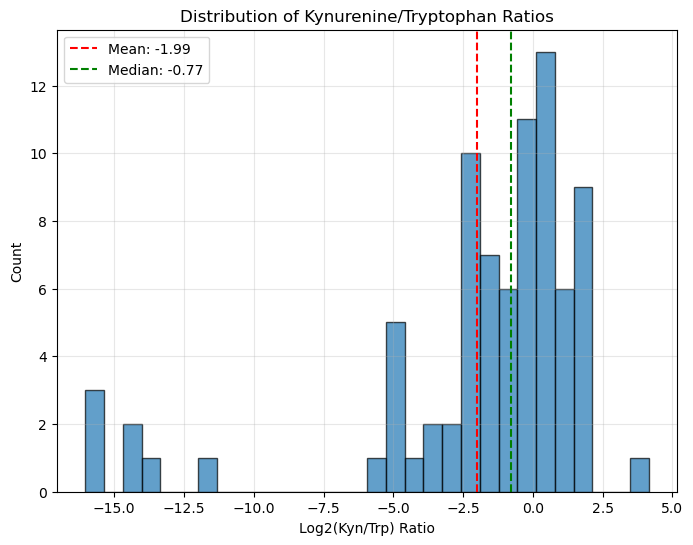

In [177]:
# Create histogram of log2(kyn/trp) ratios
plt.figure(figsize=(8, 6))
plt.hist(log2_ratio.dropna(), bins=30, edgecolor='black', alpha=0.7)
plt.axvline(x=log2_ratio.mean(), color='red', linestyle='--', label=f'Mean: {log2_ratio.mean():.2f}')
plt.axvline(x=log2_ratio.median(), color='green', linestyle='--', label=f'Median: {log2_ratio.median():.2f}')
plt.xlabel('Log2(Kyn/Trp) Ratio')
plt.ylabel('Count')
plt.title('Distribution of Kynurenine/Tryptophan Ratios')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Validation: 81 common samples found
Validation correlation: r = 1.000, p = 3.885e-128


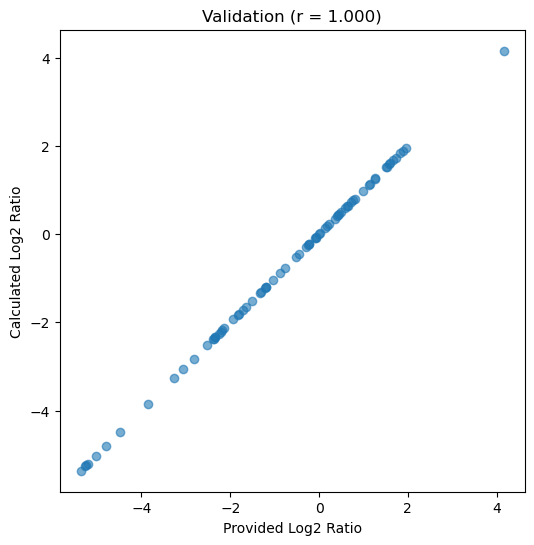

In [178]:

# Load the validation file
ratio_validation = pd.read_csv('out/multiomics/ratio_ky_trp.csv')

# Convert validation ratio to log2
validation_log2 = np.log2(ratio_validation.set_index('sample_name')['Ratio'])

# Find common samples
common_samples = log2_ratio.index.intersection(validation_log2.index)
print(f"\nValidation: {len(common_samples)} common samples found")

if len(common_samples) > 0:
    # Compare ratios
    calc_subset = log2_ratio.loc[common_samples]
    valid_subset = validation_log2.loc[common_samples]
    
    corr, pval = spearmanr(calc_subset, valid_subset)
    print(f"Validation correlation: r = {corr:.3f}, p = {pval:.3e}")
    
    # Plot comparison
    plt.figure(figsize=(6, 6))
    plt.scatter(valid_subset, calc_subset, alpha=0.6)
    plt.plot([valid_subset.min(), valid_subset.max()], 
             [valid_subset.min(), valid_subset.max()], 'r--', alpha=0.5)
    plt.xlabel('Provided Log2 Ratio')
    plt.ylabel('Calculated Log2 Ratio')
    plt.title(f'Validation (r = {corr:.3f})')
    plt.show()


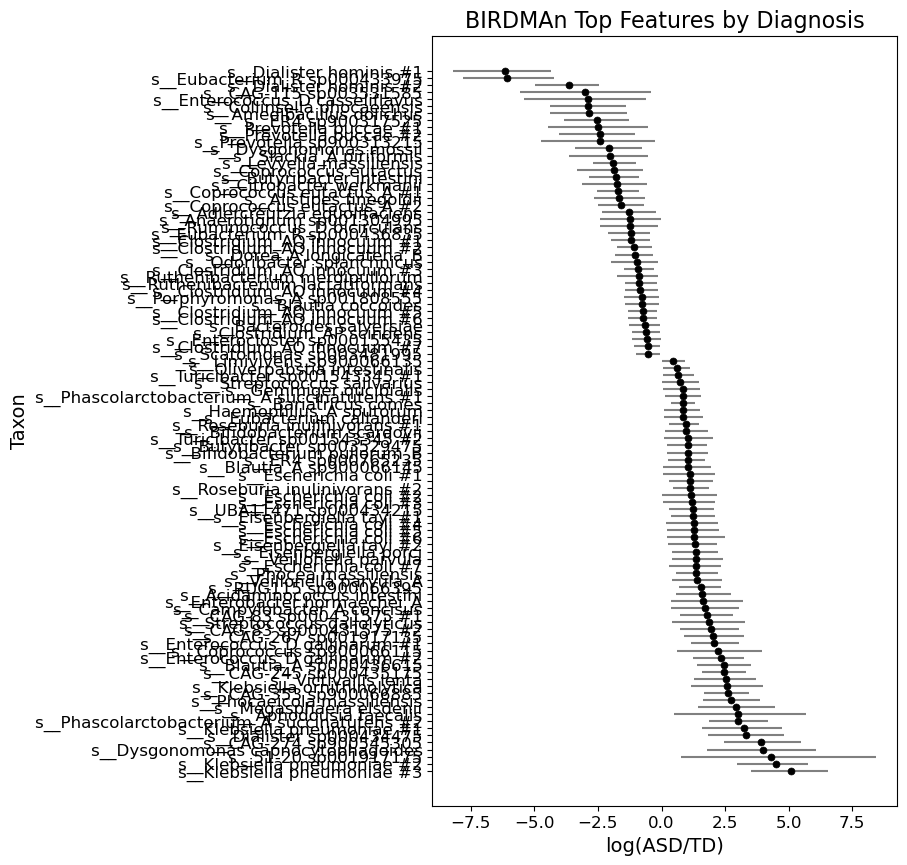

Selected 100 microbes for correlation analysis


In [180]:

# Use the display_top_n_feats function to get top/bottom 50 microbes
# This assumes you have already processed the BIRDMAn results into 'df' 
# with the credible intervals and species information (as shown in your example code)

# Call display_top_n_feats with return_df=True to get the filtered dataframe
plot_df = display_top_n_feats(df, 50, 'Species', var+'mean', "log(ASD/TD)", "Taxon",
                              "BIRDMAn Top Features by Diagnosis", True, return_df=True)

# Extract the microbe Feature IDs from the returned dataframe
# The original Feature IDs are in the index of the plot_df
selected_microbes = plot_df.index.tolist()

print(f"Selected {len(selected_microbes)} microbes for correlation analysis")
# selected_microbes_species = plot_df['Species'].tolist()

# plot_df.to_csv('BIRDMAn_top_bottom_50_microbes.csv')


In [181]:

# Filter table_metag_rclr to selected microbes
available_microbes = [m for m in selected_microbes if m in table_metag_rclr.columns]
missing_microbes = [m for m in selected_microbes if m not in table_metag_rclr.columns]

print(f"Available microbes: {len(available_microbes)}")
print(f"Missing microbes: {len(missing_microbes)}")

# Align samples
common_samples = log2_ratio.index.intersection(table_metag_rclr.index)
print(f"Common samples for correlation: {len(common_samples)}")

# Perform correlations
correlation_results = []

for microbe in available_microbes:
    # Get aligned data
    ratio_values = log2_ratio.loc[common_samples]
    microbe_values = table_metag_rclr.loc[common_samples, microbe]
    
    # Remove NaN values
    valid_mask = ~(ratio_values.isna() | microbe_values.isna())
    
    if valid_mask.sum() >= 10:  # Minimum 10 samples
        # Calculate Spearman correlation
        corr, pval = spearmanr(ratio_values[valid_mask], microbe_values[valid_mask])
        
        correlation_results.append({
            'microbe': microbe,
            'correlation': corr,
            'p_value': pval,
            'n_samples': valid_mask.sum()
        })

# Create results dataframe
results_df = pd.DataFrame(correlation_results)
print(f"\nComputed {len(results_df)} correlations")


Available microbes: 100
Missing microbes: 0
Common samples for correlation: 81

Computed 100 correlations


In [182]:
if len(results_df) > 0:
    # Apply Benjamini-Hochberg FDR correction
    _, pvals_adj, _, _ = multipletests(results_df['p_value'], 
                                       alpha=0.05, 
                                       method='fdr_bh')
    
    results_df['p_adj'] = pvals_adj
    results_df['significant'] = results_df['p_adj'] < 0.05
    
    # Sort by absolute correlation
    results_df['abs_corr'] = results_df['correlation'].abs()
    results_df = results_df.sort_values('abs_corr', ascending=False)
    
    n_sig = results_df['significant'].sum()
    print(f"Significant correlations (FDR < 0.05): {n_sig}/{len(results_df)}")
    
    # Show top results
    print("\nTop 10 correlations:")
    display_cols = ['microbe', 'correlation', 'p_value', 'p_adj', 'significant']
    print(results_df[display_cols].head(10))
    
    # Save results
    results_df.to_csv('kyn_trp_microbe_correlations.csv', index=False)
    print("\nResults saved to 'kyn_trp_microbe_correlations.csv'")



Significant correlations (FDR < 0.05): 0/100

Top 10 correlations:
       microbe  correlation   p_value     p_adj  significant
63  G001717135    -0.339137  0.001954  0.110474        False
39  G001406695    -0.331572  0.002496  0.110474        False
38  G000155435    -0.318496  0.003758  0.110474        False
26  G001916345     0.309643  0.004909  0.110474        False
30  G001481375    -0.305646  0.005524  0.110474        False
22  G001917015     0.290305  0.009929  0.136538        False
68  G000466465    -0.279901  0.011382  0.136538        False
34  G000183585    -0.279472  0.011514  0.136538        False
49  G000152245    -0.277033  0.012288  0.136538        False
33  G000373885    -0.267864  0.015621  0.156207        False

Results saved to 'kyn_trp_microbe_correlations.csv'


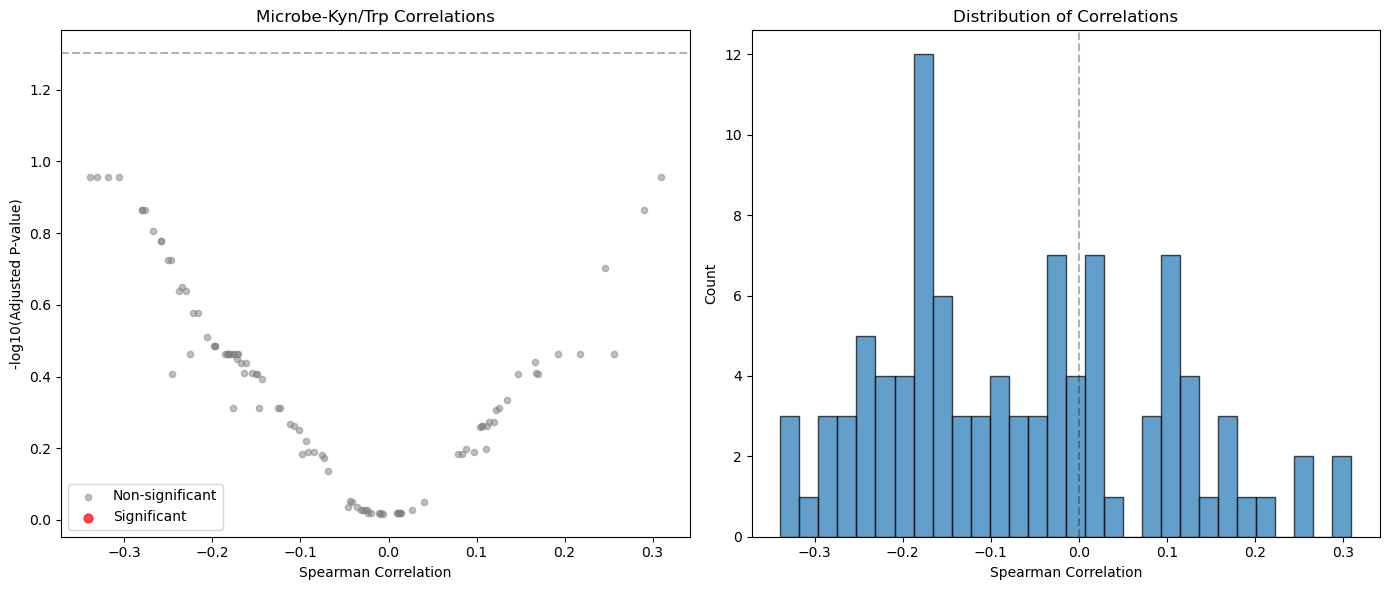

In [183]:
if len(results_df) > 0:
    # Volcano plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Volcano plot
    results_df['neg_log_p'] = -np.log10(results_df['p_adj'] + 1e-300)
    
    non_sig = results_df[~results_df['significant']]
    sig = results_df[results_df['significant']]
    
    ax1.scatter(non_sig['correlation'], non_sig['neg_log_p'], 
               alpha=0.5, s=20, c='gray', label='Non-significant')
    ax1.scatter(sig['correlation'], sig['neg_log_p'], 
               alpha=0.7, s=40, c='red', label='Significant')
    ax1.axhline(y=-np.log10(0.05), color='black', linestyle='--', alpha=0.3)
    ax1.set_xlabel('Spearman Correlation')
    ax1.set_ylabel('-log10(Adjusted P-value)')
    ax1.set_title('Microbe-Kyn/Trp Correlations')
    ax1.legend()
    
    # Distribution of correlations
    ax2.hist(results_df['correlation'], bins=30, edgecolor='black', alpha=0.7)
    ax2.axvline(x=0, color='black', linestyle='--', alpha=0.3)
    ax2.set_xlabel('Spearman Correlation')
    ax2.set_ylabel('Count')
    ax2.set_title('Distribution of Correlations')
    
    plt.tight_layout()
    plt.savefig('kyn_trp_correlation_plots.png', dpi=300, bbox_inches='tight')
    plt.show()


In [184]:
ec = biom.load_table('out/lucas/195333_ec.zebra.tp-td.biom')
ko = biom.load_table('out/lucas/195334_ko.zebra.tp-td.biom')
pathway = biom.load_table('out/lucas/195331_pathway.zebra.tp-td.biom')

pathway_df = pathway.to_dataframe(dense=True).T
pathway_df.head()
ko_df = ko.to_dataframe(dense=True).T
ko_df.head()
ec_df = ec.to_dataframe(dense=True).T
ec_df.head()

# For demonstration, we'll use a function to analyze any table
def analyze_feature_table(log2_ratio, feature_table, table_name, n_features=50):
    """Analyze correlation between kyn/trp ratio and features"""
    
    print(f"Analyzing {table_name} table")

    
    # Select top/bottom features by variance
    if len(feature_table.columns) > 2*n_features:
        variances = feature_table.var()
        top_var = variances.nlargest(n_features).index.tolist()
        bottom_var = variances.nsmallest(n_features).index.tolist()
        selected_features = top_var + bottom_var
    else:
        selected_features = feature_table.columns.tolist()
    
    print(f"Selected {len(selected_features)} features")
    
    # Align samples
    common_samples = log2_ratio.index.intersection(feature_table.index)
    print(f"Common samples: {len(common_samples)}")
    
    # Correlate
    results = []
    for feature in selected_features:
        ratio_vals = log2_ratio.loc[common_samples]
        feature_vals = feature_table.loc[common_samples, feature]
        
        valid = ~(ratio_vals.isna() | feature_vals.isna())
        if valid.sum() >= 10:
            corr, pval = spearmanr(ratio_vals[valid], feature_vals[valid])
            results.append({
                'feature': feature,
                'correlation': corr,
                'p_value': pval,
                'n_samples': valid.sum()
            })
    
    results_df = pd.DataFrame(results)
    
    if len(results_df) > 0:
        # FDR correction
        _, pvals_adj, _, _ = multipletests(results_df['p_value'], alpha=0.05, method='fdr_bh')
        results_df['p_adj'] = pvals_adj
        results_df['significant'] = results_df['p_adj'] < 0.05
        
        n_sig = results_df['significant'].sum()
        print(f"Significant correlations: {n_sig}/{len(results_df)}")
        
        # Save
        results_df.to_csv(f'kyn_trp_{table_name}_correlations.csv', index=False)
        print(f"Results saved to 'kyn_trp_{table_name}_correlations.csv'")
    
    return results_df

pathway_results = analyze_feature_table(log2_ratio, pathway_df, 'pathway')
ko_results = analyze_feature_table(log2_ratio, ko_df, 'ko')
ec_results = analyze_feature_table(log2_ratio, ec_df, 'ec')

Analyzing pathway table
Selected 100 features
Common samples: 47
Significant correlations: 0/100
Results saved to 'kyn_trp_pathway_correlations.csv'
Analyzing ko table
Selected 100 features
Common samples: 47
Significant correlations: 0/100
Results saved to 'kyn_trp_ko_correlations.csv'
Analyzing ec table
Selected 100 features
Common samples: 47
Significant correlations: 0/100
Results saved to 'kyn_trp_ec_correlations.csv'


ADOS CORRELATION ANALYSIS
(Infant stool samples vs. later ADOS scores)
Common samples: 81

ados_cosotot:
  Samples: 81
  Correlation: r = -0.403
  P-value: 1.902e-04


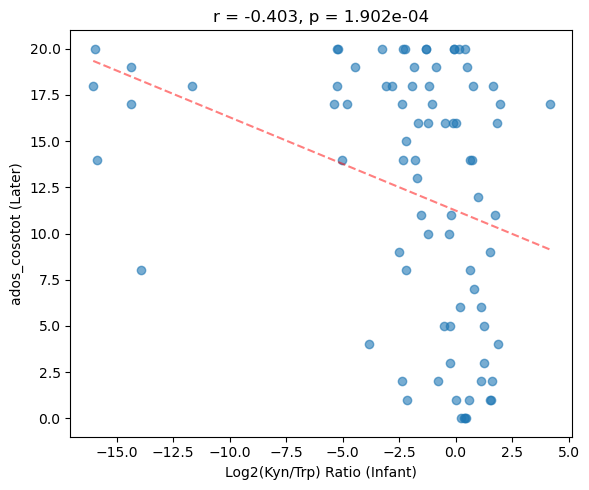


ados_cosototrrtot:
  Samples: 81
  Correlation: r = -0.393
  P-value: 2.843e-04


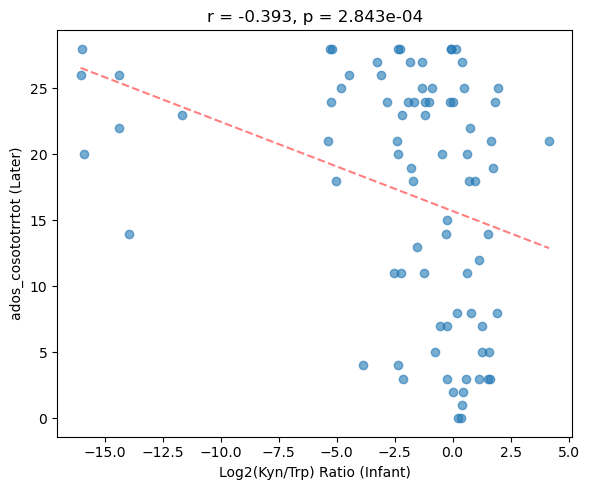


ados_rrtot:
  Samples: 81
  Correlation: r = -0.290
  P-value: 8.692e-03


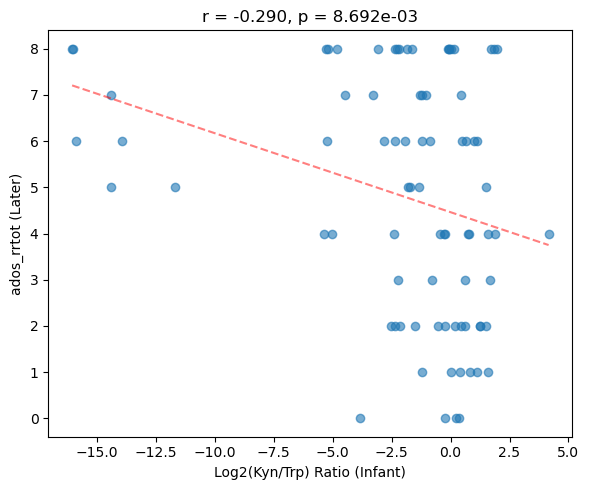



        ados_measure  correlation   p_value  n_samples     p_adj  significant
0       ados_cosotot    -0.403150  0.000190         81  0.000427         True
1  ados_cosototrrtot    -0.392995  0.000284         81  0.000427         True
2         ados_rrtot    -0.289768  0.008692         81  0.008692         True

Results saved to 'kyn_trp_ados_correlations.csv'


In [185]:

# ADOS columns to analyze
ados_columns = ['ados_cosotot', 'ados_cosototrrtot', 'ados_rrtot']

# Check which metadata to use
if 'ados_cosotot' in qiita_metadata_df_subset.columns:
    metadata_for_ados = qiita_metadata_df_subset
elif 'ados_cosotot' in new_metadata_subset.columns:
    metadata_for_ados = new_metadata_subset.set_index('sample_name')
else:
    print("ADOS columns not found in metadata")
    metadata_for_ados = None

if metadata_for_ados is not None:

    print("ADOS CORRELATION ANALYSIS")
    print("(Infant stool samples vs. later ADOS scores)")
    
    # Align samples
    common_samples = log2_ratio.index.intersection(metadata_for_ados.index)
    print(f"Common samples: {len(common_samples)}")
    
    ados_results = []
    
    for ados_col in ados_columns:
        if ados_col in metadata_for_ados.columns:
            # Get values
            ratio_vals = log2_ratio.loc[common_samples]
            ados_vals = pd.to_numeric(metadata_for_ados.loc[common_samples, ados_col], 
                                     errors='coerce')
            
            # Remove NaN
            valid = ~(ratio_vals.isna() | ados_vals.isna())
            n_valid = valid.sum()
            
            if n_valid >= 10:
                # Correlate
                corr, pval = spearmanr(ratio_vals[valid], ados_vals[valid])
                
                ados_results.append({
                    'ados_measure': ados_col,
                    'correlation': corr,
                    'p_value': pval,
                    'n_samples': n_valid
                })
                
                print(f"\n{ados_col}:")
                print(f"  Samples: {n_valid}")
                print(f"  Correlation: r = {corr:.3f}")
                print(f"  P-value: {pval:.3e}")
                
                # Scatter plot
                plt.figure(figsize=(6, 5))
                plt.scatter(ratio_vals[valid], ados_vals[valid], alpha=0.6)
                plt.xlabel('Log2(Kyn/Trp) Ratio (Infant)')
                plt.ylabel(f'{ados_col} (Later)')
                plt.title(f'r = {corr:.3f}, p = {pval:.3e}')
                
                # Add trend line
                z = np.polyfit(ratio_vals[valid], ados_vals[valid], 1)
                p = np.poly1d(z)
                x_line = np.linspace(ratio_vals[valid].min(), ratio_vals[valid].max(), 100)
                plt.plot(x_line, p(x_line), "r--", alpha=0.5)
                
                plt.tight_layout()
                plt.savefig(f'kyn_trp_{ados_col}_scatter.png', dpi=300, bbox_inches='tight')
                plt.show()
    
    if ados_results:
        ados_df = pd.DataFrame(ados_results)
        
        # FDR correction
        _, pvals_adj, _, _ = multipletests(ados_df['p_value'], alpha=0.05, method='fdr_bh')
        ados_df['p_adj'] = pvals_adj
        ados_df['significant'] = ados_df['p_adj'] < 0.05
        
        print("\n")
        print(ados_df)
        
        # Save results
        ados_df.to_csv('kyn_trp_ados_correlations.csv', index=False)
        print("\nResults saved to 'kyn_trp_ados_correlations.csv'")


# Kyn/Trp Ratio Analysis

In [186]:

# Calculate kynurenine/tryptophan log2 ratio
kyn_id = '5980'  # Kynurenine column
trp_id = '5043'  # Tryptophan column

# Convert to numeric and calculate ratio
kyn_values = pd.to_numeric(table_metab_df_subset[kyn_id], errors='coerce')
trp_values = pd.to_numeric(table_metab_df_subset[trp_id], errors='coerce')

# Calculate log2(kyn/trp) ratio
epsilon = 1
kyn_trp_ratio = (kyn_values + epsilon) / (trp_values + epsilon)
log2_kyn_trp = np.log2(kyn_trp_ratio)

# Create Series with proper index
log2_ratio_full = pd.Series(log2_kyn_trp, index=table_metab_df_subset.index, name='kyn_trp_log2_ratio')

print(f"Original samples: {log2_ratio_full.notna().sum()}")
print(f"Original mean: {log2_ratio_full.mean():.3f}, median: {log2_ratio_full.median():.3f}")

# FILTER: Remove samples with log2 ratio below -10
log2_ratio = log2_ratio_full[log2_ratio_full >= -10].copy()

print(f"\nAfter filtering (log2_ratio >= -10):")
print(f"Filtered samples: {log2_ratio.notna().sum()}")
print(f"Removed samples: {log2_ratio_full.notna().sum() - log2_ratio.notna().sum()}")
print(f"Filtered mean: {log2_ratio.mean():.3f}, median: {log2_ratio.median():.3f}, std: {log2_ratio.std():.3f}")


Original samples: 81
Original mean: -1.987, median: -0.766

After filtering (log2_ratio >= -10):
Filtered samples: 74
Removed samples: 7
Filtered mean: -0.793, median: -0.271, std: 2.051


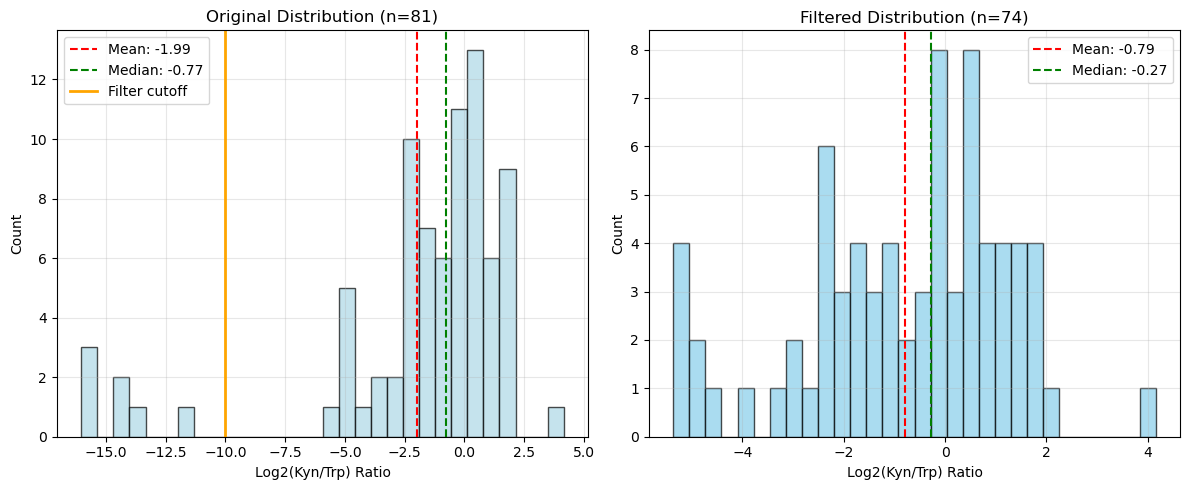

In [187]:

# Create histogram of filtered log2(kyn/trp) ratios
plt.figure(figsize=(12, 5))

# Original distribution
plt.subplot(1, 2, 1)
plt.hist(log2_ratio_full.dropna(), bins=30, edgecolor='black', alpha=0.7, color='lightblue')
plt.axvline(x=log2_ratio_full.mean(), color='red', linestyle='--', label=f'Mean: {log2_ratio_full.mean():.2f}')
plt.axvline(x=log2_ratio_full.median(), color='green', linestyle='--', label=f'Median: {log2_ratio_full.median():.2f}')
plt.axvline(x=-10, color='orange', linestyle='-', linewidth=2, label='Filter cutoff')
plt.xlabel('Log2(Kyn/Trp) Ratio')
plt.ylabel('Count')
plt.title(f'Original Distribution (n={log2_ratio_full.notna().sum()})')
plt.legend()
plt.grid(True, alpha=0.3)

# Filtered distribution
plt.subplot(1, 2, 2)
plt.hist(log2_ratio.dropna(), bins=30, edgecolor='black', alpha=0.7, color='skyblue')
plt.axvline(x=log2_ratio.mean(), color='red', linestyle='--', label=f'Mean: {log2_ratio.mean():.2f}')
plt.axvline(x=log2_ratio.median(), color='green', linestyle='--', label=f'Median: {log2_ratio.median():.2f}')
plt.xlabel('Log2(Kyn/Trp) Ratio')
plt.ylabel('Count')
plt.title(f'Filtered Distribution (n={log2_ratio.notna().sum()})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



Validation: 74 common samples found (after filtering)
Validation correlation: r = 1.000, p = 0.000e+00


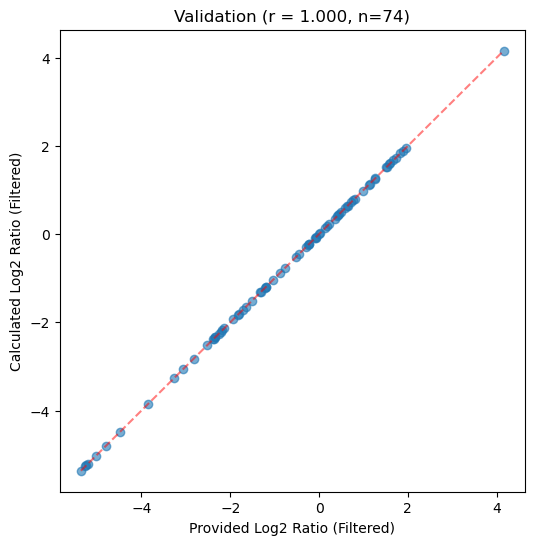

In [188]:

# Load the validation file and filter to match
ratio_validation = pd.read_csv('out/multiomics/ratio_ky_trp.csv')

# Convert validation ratio to log2
validation_log2_full = np.log2(ratio_validation.set_index('sample_name')['Ratio'])

# Filter validation to match filtered samples
validation_log2 = validation_log2_full[validation_log2_full.index.isin(log2_ratio.index)]

# Find common samples (now both filtered)
common_samples = log2_ratio.index.intersection(validation_log2.index)
print(f"\nValidation: {len(common_samples)} common samples found (after filtering)")

if len(common_samples) > 0:
    # Compare ratios
    calc_subset = log2_ratio.loc[common_samples]
    valid_subset = validation_log2.loc[common_samples]
    
    corr, pval = spearmanr(calc_subset, valid_subset)
    print(f"Validation correlation: r = {corr:.3f}, p = {pval:.3e}")
    
    # Plot comparison
    plt.figure(figsize=(6, 6))
    plt.scatter(valid_subset, calc_subset, alpha=0.6)
    plt.plot([valid_subset.min(), valid_subset.max()], 
             [valid_subset.min(), valid_subset.max()], 'r--', alpha=0.5)
    plt.xlabel('Provided Log2 Ratio (Filtered)')
    plt.ylabel('Calculated Log2 Ratio (Filtered)')
    plt.title(f'Validation (r = {corr:.3f}, n={len(common_samples)})')
    plt.show()


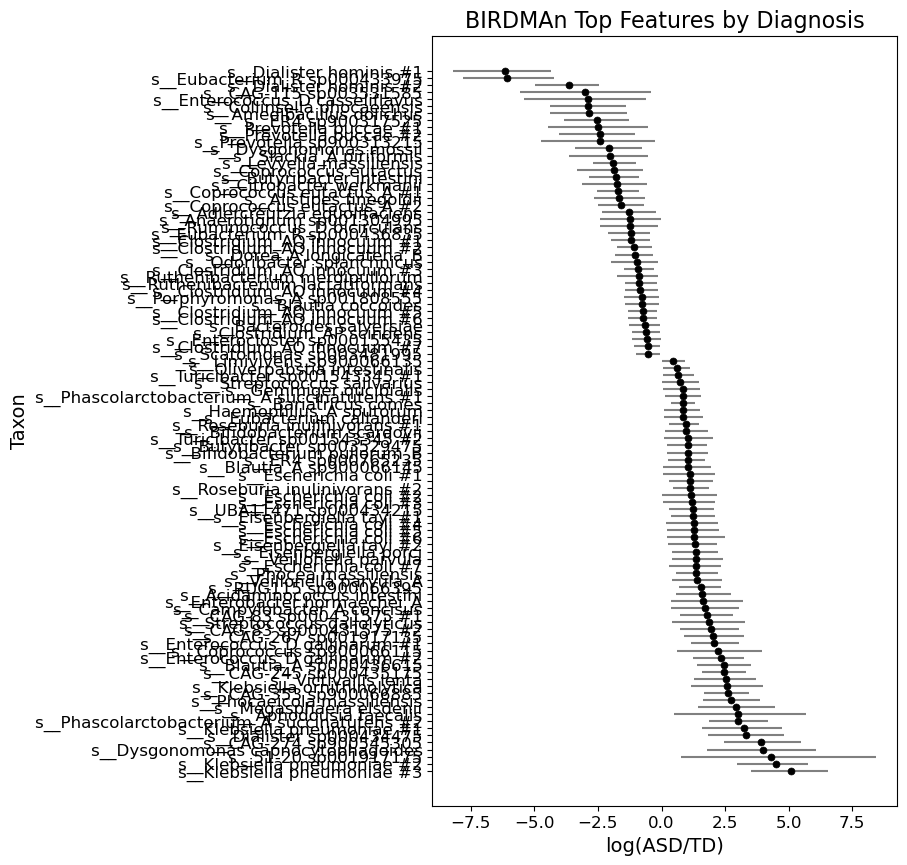

Selected 100 microbes for correlation analysis
Available microbes: 100
Missing microbes: 0
Common samples for correlation: 74 (after filtering)

Computed 100 correlations (filtered data)


In [189]:

# Use the display_top_n_feats function to get top/bottom 50 microbes
plot_df = display_top_n_feats(df, 50, 'Species', var+'mean', "log(ASD/TD)", "Taxon",
                              "BIRDMAn Top Features by Diagnosis", True, return_df=True)

# Extract the microbe Feature IDs from the returned dataframe
selected_microbes = plot_df.index.tolist()
print(f"Selected {len(selected_microbes)} microbes for correlation analysis")

# Filter table_metag_rclr to selected microbes
available_microbes = [m for m in selected_microbes if m in table_metag_rclr.columns]
missing_microbes = [m for m in selected_microbes if m not in table_metag_rclr.columns]

print(f"Available microbes: {len(available_microbes)}")
print(f"Missing microbes: {len(missing_microbes)}")

# Align samples (using filtered log2_ratio)
common_samples = log2_ratio.index.intersection(table_metag_rclr.index)
print(f"Common samples for correlation: {len(common_samples)} (after filtering)")


# Perform correlations
correlation_results = []

for microbe in available_microbes:
    # Get aligned data (filtered samples only)
    ratio_values = log2_ratio.loc[common_samples]
    microbe_values = table_metag_rclr.loc[common_samples, microbe]
    
    # Remove NaN values
    valid_mask = ~(ratio_values.isna() | microbe_values.isna())
    
    if valid_mask.sum() >= 10:  # Minimum 10 samples
        # Calculate Spearman correlation
        corr, pval = spearmanr(ratio_values[valid_mask], microbe_values[valid_mask])
        
        correlation_results.append({
            'microbe': microbe,
            'correlation': corr,
            'p_value': pval,
            'n_samples': valid_mask.sum()
        })

# Create results dataframe
results_df = pd.DataFrame(correlation_results)
print(f"\nComputed {len(results_df)} correlations (filtered data)")

In [ ]:


if len(results_df) > 0:
    # Apply Benjamini-Hochberg FDR correction
    _, pvals_adj, _, _ = multipletests(results_df['p_value'], 
                                       alpha=0.05, 
                                       method='fdr_bh')
    
    results_df['p_adj'] = pvals_adj
    results_df['significant'] = results_df['p_adj'] < 0.05
    
    # Sort by absolute correlation
    results_df['abs_corr'] = results_df['correlation'].abs()
    results_df = results_df.sort_values('abs_corr', ascending=False)
    
    n_sig = results_df['significant'].sum()
    print(f"Significant correlations (FDR < 0.05): {n_sig}/{len(results_df)}")
    
    # Show top results
    print("\nTop 10 correlations:")
    display_cols = ['microbe', 'correlation', 'p_value', 'p_adj', 'significant']
    print(results_df[display_cols].head(10))
    
    # Save results
    results_df.to_csv('kyn_trp_microbe_correlations_filtered.csv', index=False)
    print("\nResults saved to 'kyn_trp_microbe_correlations_filtered.csv'")


In [ ]:

# Visualization (updated for filtered data)
if len(results_df) > 0:
    # Volcano plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Volcano plot
    results_df['neg_log_p'] = -np.log10(results_df['p_adj'] + 1e-300)
    
    non_sig = results_df[~results_df['significant']]
    sig = results_df[results_df['significant']]
    
    ax1.scatter(non_sig['correlation'], non_sig['neg_log_p'], 
               alpha=0.5, s=20, c='gray', label='Non-significant')
    ax1.scatter(sig['correlation'], sig['neg_log_p'], 
               alpha=0.7, s=40, c='red', label='Significant')
    ax1.axhline(y=-np.log10(0.05), color='black', linestyle='--', alpha=0.3)
    ax1.set_xlabel('Spearman Correlation')
    ax1.set_ylabel('-log10(Adjusted P-value)')
    ax1.set_title('Microbe-Kyn/Trp Correlations (Filtered)')
    ax1.legend()
    
    # Distribution of correlations
    ax2.hist(results_df['correlation'], bins=30, edgecolor='black', alpha=0.7)
    ax2.axvline(x=0, color='black', linestyle='--', alpha=0.3)
    ax2.set_xlabel('Spearman Correlation')
    ax2.set_ylabel('Count')
    ax2.set_title('Distribution of Correlations (Filtered)')
    
    plt.tight_layout()
    plt.savefig('kyn_trp_correlation_plots_filtered.png', dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:

# Load functional data
ec = biom.load_table('out/lucas/195333_ec.zebra.tp-td.biom')
ko = biom.load_table('out/lucas/195334_ko.zebra.tp-td.biom')
pathway = biom.load_table('out/lucas/195331_pathway.zebra.tp-td.biom')

pathway_df = pathway.to_dataframe(dense=True).T
ko_df = ko.to_dataframe(dense=True).T
ec_df = ec.to_dataframe(dense=True).T

# Updated function to work with filtered data
def analyze_feature_table(log2_ratio_filtered, feature_table, table_name, n_features=50):
    """Analyze correlation between filtered kyn/trp ratio and features"""
    
    print(f"\nAnalyzing {table_name} table (with filtered ratios)")
    
    # Select top/bottom features by variance
    if len(feature_table.columns) > 2*n_features:
        variances = feature_table.var()
        top_var = variances.nlargest(n_features).index.tolist()
        bottom_var = variances.nsmallest(n_features).index.tolist()
        selected_features = top_var + bottom_var
    else:
        selected_features = feature_table.columns.tolist()
    
    print(f"Selected {len(selected_features)} features")
    
    # Align samples (using filtered log2_ratio)
    common_samples = log2_ratio_filtered.index.intersection(feature_table.index)
    print(f"Common samples: {len(common_samples)} (after filtering)")
    
    # Correlate
    results = []
    for feature in selected_features:
        ratio_vals = log2_ratio_filtered.loc[common_samples]
        feature_vals = feature_table.loc[common_samples, feature]
        
        valid = ~(ratio_vals.isna() | feature_vals.isna())
        if valid.sum() >= 10:
            corr, pval = spearmanr(ratio_vals[valid], feature_vals[valid])
            results.append({
                'feature': feature,
                'correlation': corr,
                'p_value': pval,
                'n_samples': valid.sum()
            })
    
    results_df = pd.DataFrame(results)
    
    if len(results_df) > 0:
        # FDR correction
        _, pvals_adj, _, _ = multipletests(results_df['p_value'], alpha=0.05, method='fdr_bh')
        results_df['p_adj'] = pvals_adj
        results_df['significant'] = results_df['p_adj'] < 0.05
        
        n_sig = results_df['significant'].sum()
        print(f"Significant correlations: {n_sig}/{len(results_df)}")
        
        # Save with filtered suffix
        results_df.to_csv(f'kyn_trp_{table_name}_correlations_filtered.csv', index=False)
        print(f"Results saved to 'kyn_trp_{table_name}_correlations_filtered.csv'")
    
    return results_df

# Run analyses with filtered data
pathway_results = analyze_feature_table(log2_ratio, pathway_df, 'pathway')
ko_results = analyze_feature_table(log2_ratio, ko_df, 'ko')
ec_results = analyze_feature_table(log2_ratio, ec_df, 'ec')



ADOS CORRELATION ANALYSIS (FILTERED DATA)
(Infant stool samples vs. later ADOS scores)
Common samples: 74 (after filtering)

ados_cosotot:
  Samples: 74
  Correlation: r = -0.377
  P-value: 9.278e-04


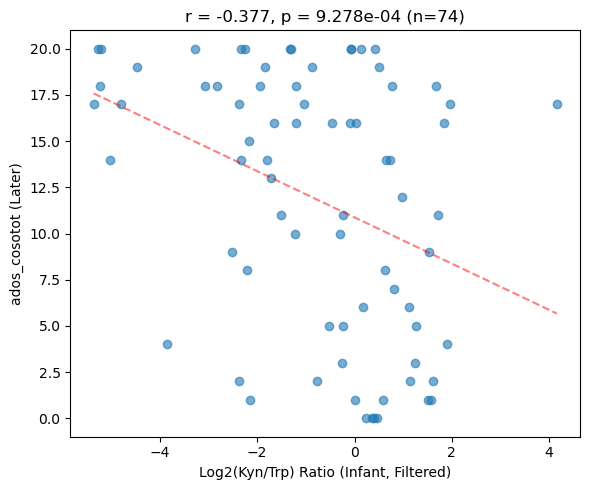


ados_cosototrrtot:
  Samples: 74
  Correlation: r = -0.359
  P-value: 1.660e-03


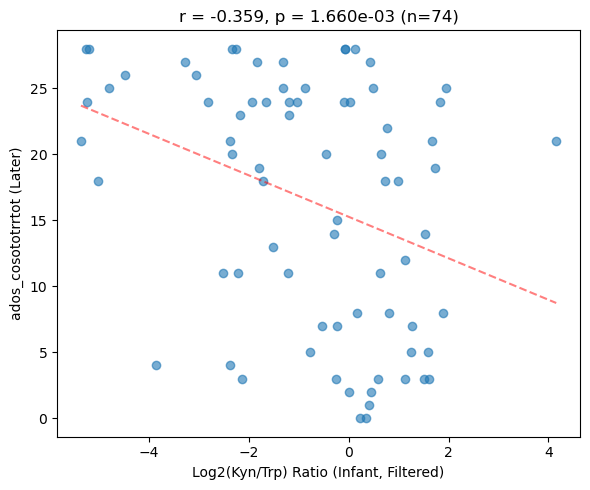


ados_rrtot:
  Samples: 74
  Correlation: r = -0.232
  P-value: 4.681e-02


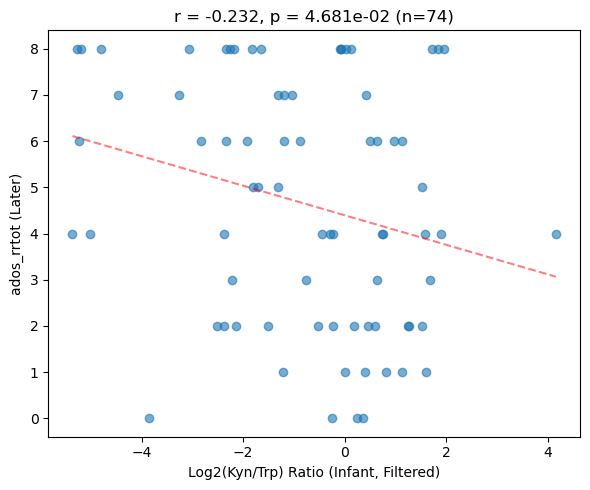


ADOS Results Summary (Filtered):
        ados_measure  correlation   p_value  n_samples     p_adj  significant
0       ados_cosotot    -0.377063  0.000928         74  0.002490         True
1  ados_cosototrrtot    -0.359436  0.001660         74  0.002490         True
2         ados_rrtot    -0.231886  0.046813         74  0.046813         True

Results saved to 'kyn_trp_ados_correlations_filtered.csv'

FILTERING SUMMARY
Original samples: 81
Filtered samples (ratio >= -10): 74
Removed samples: 7
Retention rate: 91.4%


In [193]:

# ADOS analysis with filtered data
ados_columns = ['ados_cosotot', 'ados_cosototrrtot', 'ados_rrtot']

# Check which metadata to use
if 'ados_cosotot' in qiita_metadata_df_subset.columns:
    metadata_for_ados = qiita_metadata_df_subset
elif 'ados_cosotot' in new_metadata_subset.columns:
    metadata_for_ados = new_metadata_subset.set_index('sample_name')
else:
    print("ADOS columns not found in metadata")
    metadata_for_ados = None

if metadata_for_ados is not None:
    print("\n" + "="*50)
    print("ADOS CORRELATION ANALYSIS (FILTERED DATA)")
    print("(Infant stool samples vs. later ADOS scores)")
    print("="*50)
    
    # Align samples (using filtered log2_ratio)
    common_samples = log2_ratio.index.intersection(metadata_for_ados.index)
    print(f"Common samples: {len(common_samples)} (after filtering)")
    
    ados_results = []
    
    for ados_col in ados_columns:
        if ados_col in metadata_for_ados.columns:
            # Get values (filtered samples only)
            ratio_vals = log2_ratio.loc[common_samples]
            ados_vals = pd.to_numeric(metadata_for_ados.loc[common_samples, ados_col], 
                                     errors='coerce')
            
            # Remove NaN
            valid = ~(ratio_vals.isna() | ados_vals.isna())
            n_valid = valid.sum()
            
            if n_valid >= 10:
                # Correlate
                corr, pval = spearmanr(ratio_vals[valid], ados_vals[valid])
                
                ados_results.append({
                    'ados_measure': ados_col,
                    'correlation': corr,
                    'p_value': pval,
                    'n_samples': n_valid
                })
                
                print(f"\n{ados_col}:")
                print(f"  Samples: {n_valid}")
                print(f"  Correlation: r = {corr:.3f}")
                print(f"  P-value: {pval:.3e}")
                
                # Scatter plot
                plt.figure(figsize=(6, 5))
                plt.scatter(ratio_vals[valid], ados_vals[valid], alpha=0.6)
                plt.xlabel('Log2(Kyn/Trp) Ratio (Infant, Filtered)')
                plt.ylabel(f'{ados_col} (Later)')
                plt.title(f'r = {corr:.3f}, p = {pval:.3e} (n={n_valid})')
                
                # Add trend line
                z = np.polyfit(ratio_vals[valid], ados_vals[valid], 1)
                p = np.poly1d(z)
                x_line = np.linspace(ratio_vals[valid].min(), ratio_vals[valid].max(), 100)
                plt.plot(x_line, p(x_line), "r--", alpha=0.5)
                
                plt.tight_layout()
                plt.savefig(f'kyn_trp_{ados_col}_scatter_filtered.png', dpi=300, bbox_inches='tight')
                plt.show()
    
    if ados_results:
        ados_df = pd.DataFrame(ados_results)
        
        # FDR correction
        _, pvals_adj, _, _ = multipletests(ados_df['p_value'], alpha=0.05, method='fdr_bh')
        ados_df['p_adj'] = pvals_adj
        ados_df['significant'] = ados_df['p_adj'] < 0.05
        
        print("\nADOS Results Summary (Filtered):")
        print(ados_df)
        
        # Save results
        ados_df.to_csv('kyn_trp_ados_correlations_filtered.csv', index=False)
        print("\nResults saved to 'kyn_trp_ados_correlations_filtered.csv'")

print(f"\n" + "="*60)
print("FILTERING SUMMARY")
print("="*60)
print(f"Original samples: {log2_ratio_full.notna().sum()}")
print(f"Filtered samples (ratio >= -10): {log2_ratio.notna().sum()}")
print(f"Removed samples: {log2_ratio_full.notna().sum() - log2_ratio.notna().sum()}")
print(f"Retention rate: {(log2_ratio.notna().sum() / log2_ratio_full.notna().sum())*100:.1f}%")
print("="*60)

In [194]:
cont_ados = pd.read_csv("data/metadata/uAutism_29AUG_longitudinaldata_lucasleo.csv", sep = ",", index_col=0)

In [ ]:
# ADOS analysis with filtered data - INCLUDING LONGITUDINAL DATA (FIXED)
ados_columns = ['ados_cosotot', 'ados_cosototrrtot', 'ados_rrtot']

# Function to convert sample_name to subjectID
def sample_name_to_subject_id(sample_name):
    """Convert sample_name (15350.A5U7C.2) to subjectID (A5U7C)"""
    if isinstance(sample_name, str) and '.' in sample_name:
        parts = sample_name.split('.')
        if len(parts) >= 2:
            return parts[1]  # Extract middle part (A5U7C)
    return sample_name

# Create mapping from sample_name to subjectID for log2_ratio
sample_to_subject_mapping = {}
for sample_name in log2_ratio.index:
    subject_id = sample_name_to_subject_id(sample_name)
    sample_to_subject_mapping[sample_name] = subject_id

print(f"Created mapping for {len(sample_to_subject_mapping)} samples")
print("Example mappings:")
for i, (sample, subject) in enumerate(list(sample_to_subject_mapping.items())[:5]):
    print(f"  {sample} → {subject}")

# Check which metadata to use
if 'ados_cosotot' in qiita_metadata_df_subset.columns:
    metadata_for_ados = qiita_metadata_df_subset
elif 'ados_cosotot' in new_metadata_subset.columns:
    metadata_for_ados = new_metadata_subset.set_index('sample_name')
else:
    print("ADOS columns not found in metadata")
    metadata_for_ados = None

# The subjectID is already the index in cont_ados
cont_ados_indexed = cont_ados

if metadata_for_ados is not None:
    print("\n" + "="*60)
    print("ADOS CORRELATION ANALYSIS (FILTERED DATA)")
    print("(Infant stool samples vs. ADOS scores at multiple timepoints)")
    print("="*60)
    
    # Align samples (using filtered log2_ratio)
    common_samples = log2_ratio.index.intersection(metadata_for_ados.index)
    print(f"Common samples with original ADOS: {len(common_samples)} (after filtering)")
    
    # Check longitudinal data availability using mapping
    samples_with_longitudinal = []
    for sample in log2_ratio.index:
        mapped_subject = sample_to_subject_mapping[sample]
        if mapped_subject in cont_ados_indexed.index:
            samples_with_longitudinal.append(sample)
    
    print(f"Samples with longitudinal ADOS data: {len(samples_with_longitudinal)} (after filtering)")
    
    ados_results = []
    
    # PART 1: Original ADOS timepoints
    print("\n" + "-"*40)
    print("ORIGINAL ADOS TIMEPOINTS")
    print("-"*40)
    
    for ados_col in ados_columns:
        if ados_col in metadata_for_ados.columns:
            # Get values (filtered samples only)
            ratio_vals = log2_ratio.loc[common_samples]
            ados_vals = pd.to_numeric(metadata_for_ados.loc[common_samples, ados_col], 
                                     errors='coerce')
            
            # Remove NaN
            valid = ~(ratio_vals.isna() | ados_vals.isna())
            n_valid = valid.sum()
            
            if n_valid >= 10:
                # Correlate
                corr, pval = spearmanr(ratio_vals[valid], ados_vals[valid])
                
                ados_results.append({
                    'ados_measure': f'{ados_col}_original',
                    'timepoint': 'original',
                    'correlation': corr,
                    'p_value': pval,
                    'n_samples': n_valid
                })
                
                print(f"\n{ados_col} (original):")
                print(f"  Samples: {n_valid}")
                print(f"  Correlation: r = {corr:.3f}")
                print(f"  P-value: {pval:.3e}")
    
    # PART 2: Longitudinal ADOS timepoints
    print("\n" + "-"*40)
    print("LONGITUDINAL ADOS TIMEPOINTS")
    print("-"*40)
    
    # Add longitudinal ados_cosototrrtot using proper mapping
    if 'Longitudinal_ados_CoSoTotRRTot' in cont_ados_indexed.columns:
        if len(samples_with_longitudinal) >= 10:
            # Extract ratio values for samples with longitudinal data
            ratio_vals_long = log2_ratio.loc[samples_with_longitudinal]
            
            # Extract corresponding longitudinal ADOS values using subject ID mapping
            subject_ids = [sample_to_subject_mapping[sample] for sample in samples_with_longitudinal]
            ados_vals_long = pd.to_numeric(cont_ados_indexed.loc[subject_ids, 'Longitudinal_ados_CoSoTotRRTot'], 
                                          errors='coerce')
            ados_vals_long.index = samples_with_longitudinal  # Align with sample names
            
            # Remove NaN
            valid_long = ~(ratio_vals_long.isna() | ados_vals_long.isna())
            n_valid_long = valid_long.sum()
            
            print(f"Valid longitudinal pairs (non-NaN): {n_valid_long}")
            
            if n_valid_long >= 10:
                # Correlate
                corr_long, pval_long = spearmanr(ratio_vals_long[valid_long], ados_vals_long[valid_long])
                
                ados_results.append({
                    'ados_measure': 'ados_cosototrrtot_longitudinal',
                    'timepoint': 'longitudinal',
                    'correlation': corr_long,
                    'p_value': pval_long,
                    'n_samples': n_valid_long
                })
                
                print(f"\nados_cosototrrtot (longitudinal):")
                print(f"  Samples: {n_valid_long}")
                print(f"  Correlation: r = {corr_long:.3f}")
                print(f"  P-value: {pval_long:.3e}")
                
                # Create scatter plot for longitudinal data
                plt.figure(figsize=(6, 5))
                plt.scatter(ratio_vals_long[valid_long], ados_vals_long[valid_long], alpha=0.6, color='green')
                plt.xlabel('Log2(Kyn/Trp) Ratio (Infant, Filtered)')
                plt.ylabel('Longitudinal ADOS CoSoTotRRTot')
                plt.title(f'r = {corr_long:.3f}, p = {pval_long:.3e} (n={n_valid_long})')
                
                # Add trend line
                z = np.polyfit(ratio_vals_long[valid_long], ados_vals_long[valid_long], 1)
                p = np.poly1d(z)
                x_line = np.linspace(ratio_vals_long[valid_long].min(), ratio_vals_long[valid_long].max(), 100)
                plt.plot(x_line, p(x_line), "r--", alpha=0.5)
                
                plt.tight_layout()
                plt.savefig('kyn_trp_ados_cosototrrtot_longitudinal_scatter_filtered.png', dpi=300, bbox_inches='tight')
                plt.show()
                
            else:
                print(f"Insufficient valid longitudinal data: {n_valid_long} samples (need >= 10)")
        else:
            print("Insufficient samples with longitudinal data")
    else:
        print("Longitudinal_ados_CoSoTotRRTot column not found in cont_ados")
    
    # PART 3: Three-timepoint analysis for ados_cosototrrtot
    print("\n" + "-"*50)
    print("THREE-TIMEPOINT TRAJECTORY ANALYSIS")
    print("(Infant Kyn/Trp → Original ADOS → Longitudinal ADOS)")
    print("-"*50)
    
    # Find samples with all three data points using proper mapping
    if ('ados_cosototrrtot' in metadata_for_ados.columns and 
        'Longitudinal_ados_CoSoTotRRTot' in cont_ados_indexed.columns):
        
        # Find samples that have:
        # 1. log2_ratio data (infant)
        # 2. original ADOS data 
        # 3. longitudinal ADOS data (via subject ID mapping)
        
        # Start with samples that have log2_ratio and original ADOS
        samples_with_original_ados = log2_ratio.index.intersection(metadata_for_ados.index)
        
        # Filter to samples that also have longitudinal data
        samples_with_all_three = []
        for sample in samples_with_original_ados:
            subject_id = sample_to_subject_mapping[sample]
            if subject_id in cont_ados_indexed.index:
                samples_with_all_three.append(sample)
        
        print(f"Samples with all three timepoints: {len(samples_with_all_three)}")
        
        if len(samples_with_all_three) >= 10:
            # Get all three measures
            infant_ratio = log2_ratio.loc[samples_with_all_three]
            original_ados = pd.to_numeric(metadata_for_ados.loc[samples_with_all_three, 'ados_cosototrrtot'], 
                                         errors='coerce')
            
            # Get longitudinal ADOS using subject ID mapping
            subject_ids_for_longitudinal = [sample_to_subject_mapping[sample] for sample in samples_with_all_three]
            longitudinal_ados = pd.to_numeric(cont_ados_indexed.loc[subject_ids_for_longitudinal, 'Longitudinal_ados_CoSoTotRRTot'], 
                                             errors='coerce')
            longitudinal_ados.index = samples_with_all_three  # Align with sample names
            
            # Remove samples with any NaN
            complete_data = ~(infant_ratio.isna() | original_ados.isna() | longitudinal_ados.isna())
            n_complete = complete_data.sum()
            
            if n_complete >= 10:
                print(f"Complete data for trajectory analysis: {n_complete} samples")
                
                # Extract complete data
                infant_complete = infant_ratio[complete_data]
                original_complete = original_ados[complete_data]
                longitudinal_complete = longitudinal_ados[complete_data]
                
                # Calculate correlations for trajectory
                corr_infant_orig, pval_infant_orig = spearmanr(infant_complete, original_complete)
                corr_infant_long, pval_infant_long = spearmanr(infant_complete, longitudinal_complete)
                corr_orig_long, pval_orig_long = spearmanr(original_complete, longitudinal_complete)
                
                print(f"\nTrajectory correlations:")
                print(f"  Infant Kyn/Trp → Original ADOS: r = {corr_infant_orig:.3f}, p = {pval_infant_orig:.3e}")
                print(f"  Infant Kyn/Trp → Longitudinal ADOS: r = {corr_infant_long:.3f}, p = {pval_infant_long:.3e}")
                print(f"  Original ADOS → Longitudinal ADOS: r = {corr_orig_long:.3f}, p = {pval_orig_long:.3e}")
                
                # Create trajectory visualization
                fig, axes = plt.subplots(2, 2, figsize=(12, 10))
                
                # Infant → Original
                axes[0,0].scatter(infant_complete, original_complete, alpha=0.6, color='blue')
                z1 = np.polyfit(infant_complete, original_complete, 1)
                p1 = np.poly1d(z1)
                x_line1 = np.linspace(infant_complete.min(), infant_complete.max(), 100)
                axes[0,0].plot(x_line1, p1(x_line1), "r--", alpha=0.5)
                axes[0,0].set_xlabel('Infant Log2(Kyn/Trp)')
                axes[0,0].set_ylabel('Original ADOS CoSoTotRRTot')
                axes[0,0].set_title(f'r = {corr_infant_orig:.3f}, p = {pval_infant_orig:.3e}')
                
                # Infant → Longitudinal
                axes[0,1].scatter(infant_complete, longitudinal_complete, alpha=0.6, color='green')
                z2 = np.polyfit(infant_complete, longitudinal_complete, 1)
                p2 = np.poly1d(z2)
                x_line2 = np.linspace(infant_complete.min(), infant_complete.max(), 100)
                axes[0,1].plot(x_line2, p2(x_line2), "r--", alpha=0.5)
                axes[0,1].set_xlabel('Infant Log2(Kyn/Trp)')
                axes[0,1].set_ylabel('Longitudinal ADOS CoSoTotRRTot')
                axes[0,1].set_title(f'r = {corr_infant_long:.3f}, p = {pval_infant_long:.3e}')
                
                # Original → Longitudinal
                axes[1,0].scatter(original_complete, longitudinal_complete, alpha=0.6, color='purple')
                z3 = np.polyfit(original_complete, longitudinal_complete, 1)
                p3 = np.poly1d(z3)
                x_line3 = np.linspace(original_complete.min(), original_complete.max(), 100)
                axes[1,0].plot(x_line3, p3(x_line3), "r--", alpha=0.5)
                axes[1,0].set_xlabel('Original ADOS CoSoTotRRTot')
                axes[1,0].set_ylabel('Longitudinal ADOS CoSoTotRRTot')
                axes[1,0].set_title(f'r = {corr_orig_long:.3f}, p = {pval_orig_long:.3e}')
                
                # Trajectory plot (connected lines for each subject)
                axes[1,1].plot([1, 2], [original_complete, longitudinal_complete], 
                              'o-', alpha=0.3, color='gray', markersize=3)
                axes[1,1].plot([1, 2], [original_complete.mean(), longitudinal_complete.mean()], 
                              'o-', color='red', linewidth=3, markersize=8, label='Mean trajectory')
                axes[1,1].set_xlim(0.8, 2.2)
                axes[1,1].set_xticks([1, 2])
                axes[1,1].set_xticklabels(['Original ADOS', 'Longitudinal ADOS'])
                axes[1,1].set_ylabel('ADOS CoSoTotRRTot Score')
                axes[1,1].set_title(f'Individual Trajectories (n={n_complete})')
                axes[1,1].legend()
                
                plt.suptitle('Three-Timepoint ADOS Trajectory Analysis', fontsize=14, y=0.98)
                plt.tight_layout()
                plt.savefig('kyn_trp_ados_trajectory_analysis_filtered.png', dpi=300, bbox_inches='tight')
                plt.show()
                
                # Add trajectory results to main results
                ados_results.extend([
                    {
                        'ados_measure': 'infant_to_original_trajectory',
                        'timepoint': 'trajectory',
                        'correlation': corr_infant_orig,
                        'p_value': pval_infant_orig,
                        'n_samples': n_complete
                    },
                    {
                        'ados_measure': 'infant_to_longitudinal_trajectory',
                        'timepoint': 'trajectory',
                        'correlation': corr_infant_long,
                        'p_value': pval_infant_long,
                        'n_samples': n_complete
                    },
                    {
                        'ados_measure': 'original_to_longitudinal_trajectory',
                        'timepoint': 'trajectory',
                        'correlation': corr_orig_long,
                        'p_value': pval_orig_long,
                        'n_samples': n_complete
                    }
                ])
            else:
                print(f"Insufficient complete data for trajectory analysis: {n_complete} samples")
        else:
            print("Insufficient samples for trajectory analysis")
    else:
        print("Required ADOS columns not found for trajectory analysis")
    
    # Create and save comprehensive results
    if ados_results:
        ados_df = pd.DataFrame(ados_results)
        
        # FDR correction
        _, pvals_adj, _, _ = multipletests(ados_df['p_value'], alpha=0.05, method='fdr_bh')
        ados_df['p_adj'] = pvals_adj
        ados_df['significant'] = ados_df['p_adj'] < 0.05
        
        print("\n" + "="*60)
        print("COMPREHENSIVE ADOS RESULTS SUMMARY (FILTERED)")
        print("="*60)
        print(ados_df[['ados_measure', 'timepoint', 'correlation', 'p_value', 'p_adj', 'significant', 'n_samples']])
        
        # Save results
        ados_df.to_csv('kyn_trp_ados_correlations_longitudinal_filtered.csv', index=False)
        print(f"\nResults saved to 'kyn_trp_ados_correlations_longitudinal_filtered.csv'")
        
        # Summary statistics
        n_sig = ados_df['significant'].sum()
        print(f"\nSignificant correlations (FDR < 0.05): {n_sig}/{len(ados_df)}")
        
        if n_sig > 0:
            print("\nSignificant findings:")
            sig_results = ados_df[ados_df['significant']]
            for _, row in sig_results.iterrows():
                print(f"  {row['ados_measure']}: r = {row['correlation']:.3f}, p_adj = {row['p_adj']:.3e}")
    else:
        print("No ADOS correlations could be computed")

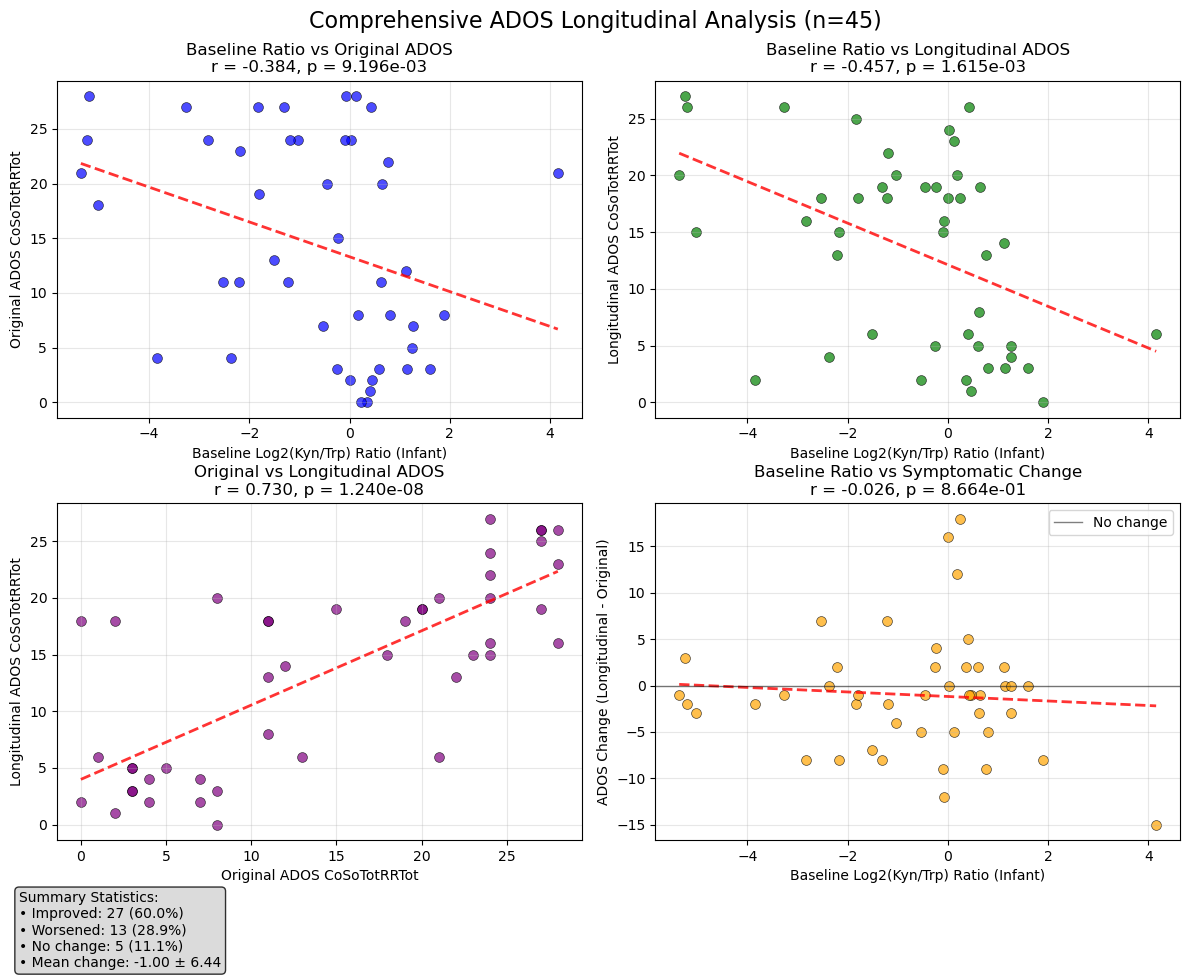


COMPREHENSIVE LONGITUDINAL ANALYSIS RESULTS
1. Baseline Kyn/Trp → Original ADOS:     r = -0.384, p = 9.196e-03
2. Baseline Kyn/Trp → Longitudinal ADOS: r = -0.457, p = 1.615e-03
3. Original ADOS → Longitudinal ADOS:    r = 0.730, p = 1.240e-08
4. Baseline Kyn/Trp → ADOS Change:       r = -0.026, p = 8.664e-01

Key Interpretations:
• Strong predictive validity: Low infant Kyn/Trp predicts higher ADOS at both timepoints
• High ADOS stability: r = 0.730 between timepoints
• Trajectory prediction: No significant relationship with symptom change over time
  (Suggests stable individual differences rather than progressive changes)

Clinical Outcomes:
• 27/45 improved, 13/45 worsened
• Average change: -1.00 ADOS points


In [198]:
# Create 2x2 subplot for comprehensive ADOS change analysis
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Calculate ADOS change score (longitudinal - original)
ados_change = longitudinal_complete - original_complete

# Count improvement vs worsening
improvement_count = (ados_change < 0).sum()
worsening_count = (ados_change > 0).sum()
no_change_count = (ados_change == 0).sum()

# Calculate all correlations
corr_baseline_orig, pval_baseline_orig = spearmanr(infant_complete, original_complete)
corr_baseline_long, pval_baseline_long = spearmanr(infant_complete, longitudinal_complete)
corr_orig_long, pval_orig_long = spearmanr(original_complete, longitudinal_complete)
corr_change, pval_change = spearmanr(infant_complete, ados_change)

# Plot 1 (Top Left): Baseline Kyn/Trp vs Original ADOS
axes[0,0].scatter(infant_complete, original_complete, alpha=0.7, s=50, color='blue', edgecolors='black', linewidth=0.5)
z_orig = np.polyfit(infant_complete, original_complete, 1)
p_orig = np.poly1d(z_orig)
x_line_orig = np.linspace(infant_complete.min(), infant_complete.max(), 100)
axes[0,0].plot(x_line_orig, p_orig(x_line_orig), "r--", linewidth=2, alpha=0.8)
axes[0,0].set_xlabel('Baseline Log2(Kyn/Trp) Ratio (Infant)')
axes[0,0].set_ylabel('Original ADOS CoSoTotRRTot')
axes[0,0].set_title(f'Baseline Ratio vs Original ADOS\nr = {corr_baseline_orig:.3f}, p = {pval_baseline_orig:.3e}')
axes[0,0].grid(True, alpha=0.3)

# Plot 2 (Top Right): Baseline Kyn/Trp vs Longitudinal ADOS
axes[0,1].scatter(infant_complete, longitudinal_complete, alpha=0.7, s=50, color='green', edgecolors='black', linewidth=0.5)
z_long = np.polyfit(infant_complete, longitudinal_complete, 1)
p_long = np.poly1d(z_long)
x_line_long = np.linspace(infant_complete.min(), infant_complete.max(), 100)
axes[0,1].plot(x_line_long, p_long(x_line_long), "r--", linewidth=2, alpha=0.8)
axes[0,1].set_xlabel('Baseline Log2(Kyn/Trp) Ratio (Infant)')
axes[0,1].set_ylabel('Longitudinal ADOS CoSoTotRRTot')
axes[0,1].set_title(f'Baseline Ratio vs Longitudinal ADOS\nr = {corr_baseline_long:.3f}, p = {pval_baseline_long:.3e}')
axes[0,1].grid(True, alpha=0.3)

# Plot 3 (Bottom Left): Original ADOS vs Longitudinal ADOS
axes[1,0].scatter(original_complete, longitudinal_complete, alpha=0.7, s=50, color='purple', edgecolors='black', linewidth=0.5)
z_stability = np.polyfit(original_complete, longitudinal_complete, 1)
p_stability = np.poly1d(z_stability)
x_line_stability = np.linspace(original_complete.min(), original_complete.max(), 100)
axes[1,0].plot(x_line_stability, p_stability(x_line_stability), "r--", linewidth=2, alpha=0.8)
axes[1,0].set_xlabel('Original ADOS CoSoTotRRTot')
axes[1,0].set_ylabel('Longitudinal ADOS CoSoTotRRTot')
axes[1,0].set_title(f'Original vs Longitudinal ADOS\nr = {corr_orig_long:.3f}, p = {pval_orig_long:.3e}')
axes[1,0].grid(True, alpha=0.3)

# Plot 4 (Bottom Right): Baseline Kyn/Trp vs ADOS Change (Longitudinal - Original)
axes[1,1].scatter(infant_complete, ados_change, alpha=0.7, s=50, color='orange', edgecolors='black', linewidth=0.5)
z_change = np.polyfit(infant_complete, ados_change, 1)
p_change = np.poly1d(z_change)
x_line_change = np.linspace(infant_complete.min(), infant_complete.max(), 100)
axes[1,1].plot(x_line_change, p_change(x_line_change), "r--", linewidth=2, alpha=0.8)
axes[1,1].axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1, label='No change')
axes[1,1].set_xlabel('Baseline Log2(Kyn/Trp) Ratio (Infant)')
axes[1,1].set_ylabel('ADOS Change (Longitudinal - Original)')
axes[1,1].set_title(f'Baseline Ratio vs Symptomatic Change\nr = {corr_change:.3f}, p = {pval_change:.3e}')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# Add overall title
plt.suptitle(f'Comprehensive ADOS Longitudinal Analysis (n={len(infant_complete)})', fontsize=16, y=0.98)

# Add summary statistics as text
summary_text = f"""Summary Statistics:
• Improved: {improvement_count} ({improvement_count/len(infant_complete)*100:.1f}%)
• Worsened: {worsening_count} ({worsening_count/len(infant_complete)*100:.1f}%)
• No change: {no_change_count} ({no_change_count/len(infant_complete)*100:.1f}%)
• Mean change: {ados_change.mean():.2f} ± {ados_change.std():.2f}"""

fig.text(0.02, 0.02, summary_text, fontsize=10, 
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8),
         verticalalignment='bottom')

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.savefig('kyn_trp_ados_comprehensive_analysis_final.png', dpi=300, bbox_inches='tight')
plt.show()

# Print key findings
print("\n" + "="*60)
print("COMPREHENSIVE LONGITUDINAL ANALYSIS RESULTS")
print("="*60)
print(f"1. Baseline Kyn/Trp → Original ADOS:     r = {corr_baseline_orig:.3f}, p = {pval_baseline_orig:.3e}")
print(f"2. Baseline Kyn/Trp → Longitudinal ADOS: r = {corr_baseline_long:.3f}, p = {pval_baseline_long:.3e}")
print(f"3. Original ADOS → Longitudinal ADOS:    r = {corr_orig_long:.3f}, p = {pval_orig_long:.3e}")
print(f"4. Baseline Kyn/Trp → ADOS Change:       r = {corr_change:.3f}, p = {pval_change:.3e}")

print(f"\nKey Interpretations:")
print(f"• Strong predictive validity: Low infant Kyn/Trp predicts higher ADOS at both timepoints")
print(f"• High ADOS stability: r = {corr_orig_long:.3f} between timepoints")

if pval_change < 0.05:
    if corr_change > 0:
        change_interpretation = "Higher baseline Kyn/Trp ratios predict symptom WORSENING"
    else:
        change_interpretation = "Higher baseline Kyn/Trp ratios predict symptom IMPROVEMENT"
    print(f"• Trajectory prediction: {change_interpretation}")
else:
    print(f"• Trajectory prediction: No significant relationship with symptom change over time")
    print(f"  (Suggests stable individual differences rather than progressive changes)")

print(f"\nClinical Outcomes:")
print(f"• {improvement_count}/{len(infant_complete)} improved, {worsening_count}/{len(infant_complete)} worsened")
print(f"• Average change: {ados_change.mean():.2f} ADOS points")

## BIRDMAn Corr to ADOS?

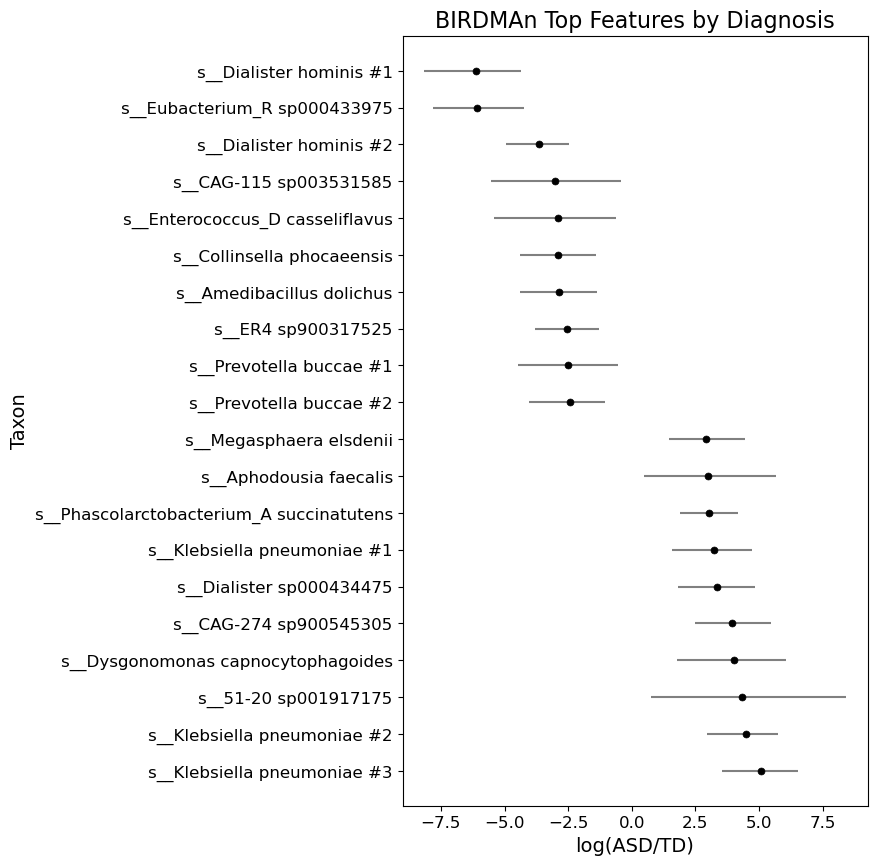

In [215]:
plot_df = display_top_n_feats(df, 10, 'Species', var+'mean', "log(ASD/TD)", "Taxon", 
                             "BIRDMAn Top Features by Diagnosis", True, return_df=True)

In [216]:
plot_df.shape

(20, 15)

Creating BIRDMAn microbiome signature from plot_df...
plot_df shape: (20, 15)
plot_df columns: ['Intercept_mean', 'dx[T.TD]_mean', 'host_age_mean', 'Intercept_std', 'dx[T.TD]_std', 'host_age_std', 'Intercept_hdi', 'dx[T.TD]_hdi', 'host_age_hdi', 'lower', 'upper', 'credible', 'taxon', 'Genus', 'Species']
Features from BIRDMAn analysis: 20
Sample feature IDs: ['G000435155', 'G000433975', 'G900343095']
Features available in abundance table: 20
Calculating sample-level BIRDMAn signatures...
Calculated BIRDMAn signatures for 83 samples
Created mapping for 83 samples
Example mappings:
  15350.C3W3Q.1 → C3W3Q
  15350.B3D2S.1 → B3D2S
  15350.B2M2J.1 → B2M2J
Using qiita metadata for ADOS analysis
Loaded longitudinal ADOS data

BIRDMAn SIGNATURE - ADOS CORRELATION ANALYSIS
Common samples with original ADOS: 83
Samples with longitudinal ADOS data: 83

----------------------------------------
ORIGINAL ADOS TIMEPOINTS
----------------------------------------

ados_cosotot (original):
  Samples: 83


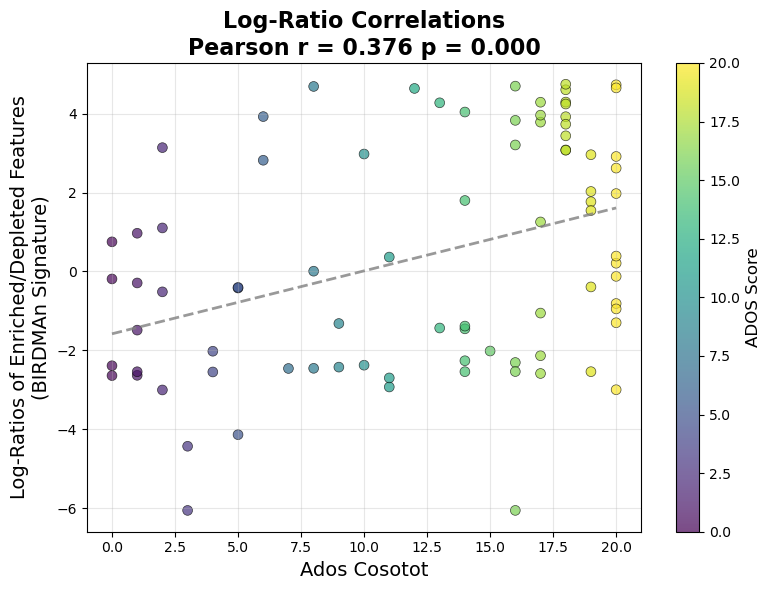


ados_cosototrrtot (original):
  Samples: 83
  Pearson r = 0.341
  P-value: 1.583e-03


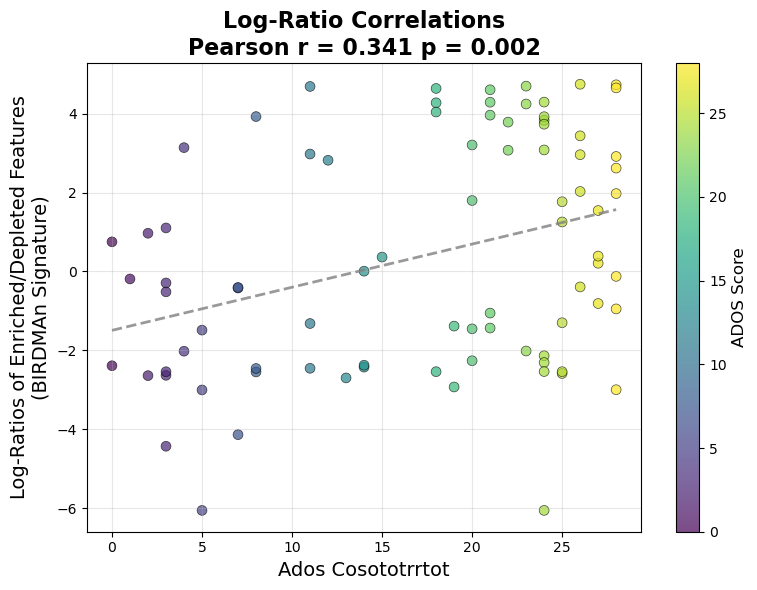


ados_rrtot (original):
  Samples: 83
  Pearson r = 0.202
  P-value: 6.640e-02


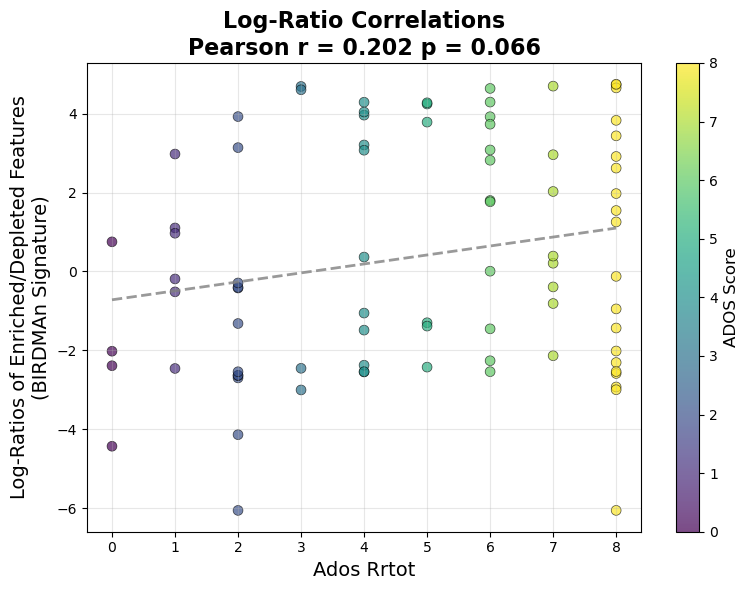


----------------------------------------
LONGITUDINAL ADOS TIMEPOINTS
----------------------------------------

ados_cosototrrtot (longitudinal):
  Samples: 49
  Pearson r = 0.391
  P-value: 5.533e-03


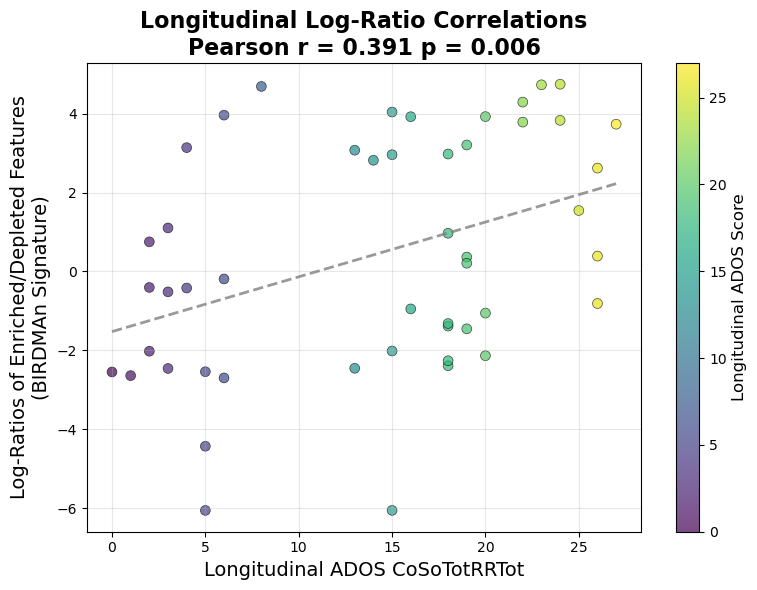


BIRDMAn-ADOS CORRELATION RESULTS SUMMARY
                     ados_measure     timepoint  correlation   p_value  \
0           ados_cosotot_original      original     0.375993  0.000460   
1      ados_cosototrrtot_original      original     0.341444  0.001583   
2             ados_rrtot_original      original     0.202471  0.066405   
3  ados_cosototrrtot_longitudinal  longitudinal     0.390529  0.005533   

      p_adj  significant  n_samples  
0  0.001840         True         83  
1  0.003166         True         83  
2  0.066405        False         83  
3  0.007377         True         49  

Results saved to 'BIRDMAn_ados_correlations.csv'

Significant correlations (FDR < 0.05): 3/4

Significant findings:
  ados_cosotot_original: r = 0.376, p_adj = 1.840e-03
  ados_cosototrrtot_original: r = 0.341, p_adj = 3.166e-03
  ados_cosototrrtot_longitudinal: r = 0.391, p_adj = 7.377e-03


In [224]:
# BIRDMAn Log Ratio - ADOS Correlation Analysis
# Adapted from the working Kyn/Trp correlation code

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from statsmodels.stats.multitest import multipletests

# Define ADOS columns to check
ados_columns = ['ados_cosotot', 'ados_cosototrrtot', 'ados_rrtot']

# Function to convert sample_name to subjectID (from your working code)
def sample_name_to_subject_id(sample_name):
    """Convert sample_name (15350.A5U7C.2) to subjectID (A5U7C)"""
    if isinstance(sample_name, str) and '.' in sample_name:
        parts = sample_name.split('.')
        if len(parts) >= 2:
            return parts[1]  # Extract middle part (A5U7C)
    return sample_name

print("Creating BIRDMAn microbiome signature from plot_df...")
print(f"plot_df shape: {plot_df.shape}")
print(f"plot_df columns: {plot_df.columns.tolist()}")

# Extract the BIRDMAn log ratios - use dx[T.TD]_mean column
ratio_col = 'dx[T.TD]_mean'
if ratio_col not in plot_df.columns:
    print(f"Error: Column '{ratio_col}' not found in plot_df")
    print("Available columns:", plot_df.columns.tolist())
else:
    # Get feature log ratios from plot_df (features are in index)
    feature_log_ratios = plot_df[ratio_col]
    features_of_interest = feature_log_ratios.index
    
    print(f"Features from BIRDMAn analysis: {len(features_of_interest)}")
    print("Sample feature IDs:", features_of_interest[:3].tolist())
    
    # Check overlap with abundance table
    available_features = table_metag_df.columns.intersection(features_of_interest)
    print(f"Features available in abundance table: {len(available_features)}")
    
    if len(available_features) == 0:
        print("No overlap between BIRDMAn features and abundance table")
        print("Sample abundance table features:", table_metag_df.columns[:3].tolist())
    else:
        # Calculate sample-level BIRDMAn signature scores
        print("Calculating sample-level BIRDMAn signatures...")
        
        sample_BIRDMAn_scores = []
        sample_ids = []
        
        for sample in table_metag_df.index:
            # Get abundances for this sample for the significant features
            sample_abundances = table_metag_df.loc[sample, available_features]
            
            # Get corresponding BIRDMAn effect sizes
            effect_sizes = feature_log_ratios.loc[available_features]
            
            # Calculate weighted average (abundance-weighted effect size)
            if sample_abundances.sum() > 0:
                weights = sample_abundances / sample_abundances.sum()
                weighted_score = (effect_sizes * weights).sum()
            else:
                weighted_score = np.nan
            
            sample_BIRDMAn_scores.append(weighted_score)
            sample_ids.append(sample)
        
        # Create the BIRDMAn signature series (analogous to log2_ratio in your Kyn/Trp code)
        BIRDMAn_signature = pd.Series(sample_BIRDMAn_scores, index=sample_ids)
        BIRDMAn_signature = BIRDMAn_signature.dropna()
        
        print(f"Calculated BIRDMAn signatures for {len(BIRDMAn_signature)} samples")
        
        # Create sample to subject mapping for longitudinal analysis
        sample_to_subject_mapping = {}
        for sample_name in BIRDMAn_signature.index:
            subject_id = sample_name_to_subject_id(sample_name)
            sample_to_subject_mapping[sample_name] = subject_id
        
        print(f"Created mapping for {len(sample_to_subject_mapping)} samples")
        print("Example mappings:")
        for i, (sample, subject) in enumerate(list(sample_to_subject_mapping.items())[:3]):
            print(f"  {sample} → {subject}")
        
        # Check which metadata to use (following your pattern)
        try:
            if 'ados_cosotot' in metadata.columns:
                metadata_for_ados = metadata
                print("Using qiita metadata for ADOS analysis")
            else:
                print("ADOS columns not found in qiita metadata")
                metadata_for_ados = None
        except:
            print("Error accessing qiita metadata")
            metadata_for_ados = None
        
        # Load longitudinal data if available
        try:
            cont_ados = pd.read_csv("data/metadata/uAutism_29AUG_longitudinaldata_lucasleo.csv", sep=",", index_col=0)
            print("Loaded longitudinal ADOS data")
            cont_ados_indexed = cont_ados
        except:
            print("Could not load longitudinal ADOS data")
            cont_ados_indexed = None
        
        if metadata_for_ados is not None:
            print("\n" + "="*60)
            print("BIRDMAn SIGNATURE - ADOS CORRELATION ANALYSIS")
            print("="*60)
            
            # Align samples
            common_samples = BIRDMAn_signature.index.intersection(metadata_for_ados.index)
            print(f"Common samples with original ADOS: {len(common_samples)}")
            
            # Check longitudinal data availability
            samples_with_longitudinal = []
            if cont_ados_indexed is not None:
                for sample in BIRDMAn_signature.index:
                    mapped_subject = sample_to_subject_mapping[sample]
                    if mapped_subject in cont_ados_indexed.index:
                        samples_with_longitudinal.append(sample)
                print(f"Samples with longitudinal ADOS data: {len(samples_with_longitudinal)}")
            
            ados_results = []
            
            # PART 1: Original ADOS timepoints
            print("\n" + "-"*40)
            print("ORIGINAL ADOS TIMEPOINTS")
            print("-"*40)
            
            for ados_col in ados_columns:
                if ados_col in metadata_for_ados.columns:
                    # Get values
                    ratio_vals = BIRDMAn_signature.loc[common_samples]
                    ados_vals = pd.to_numeric(metadata_for_ados.loc[common_samples, ados_col], 
                                             errors='coerce')
                    
                    # Remove NaN
                    valid = ~(ratio_vals.isna() | ados_vals.isna())
                    n_valid = valid.sum()
                    
                    if n_valid >= 10:
                        # Calculate Pearson correlation (like the reference image shows)
                        corr, pval = pearsonr(ratio_vals[valid], ados_vals[valid])
                        
                        ados_results.append({
                            'ados_measure': f'{ados_col}_original',
                            'timepoint': 'original',
                            'correlation': corr,
                            'p_value': pval,
                            'n_samples': n_valid
                        })
                        
                        print(f"\n{ados_col} (original):")
                        print(f"  Samples: {n_valid}")
                        print(f"  Pearson r = {corr:.3f}")
                        print(f"  P-value: {pval:.3e}")
                        
                        # Create scatter plot matching the reference style
                        plt.figure(figsize=(8, 6))
                        
                        # Create scatter with color mapping like the reference
                        scatter = plt.scatter(ados_vals[valid], ratio_vals[valid], 
                                           c=ados_vals[valid], cmap='viridis', 
                                           alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
                        
                        # Add trend line
                        z = np.polyfit(ados_vals[valid], ratio_vals[valid], 1)
                        p = np.poly1d(z)
                        x_line = np.linspace(ados_vals[valid].min(), ados_vals[valid].max(), 100)
                        plt.plot(x_line, p(x_line), "gray", linestyle='--', alpha=0.8, linewidth=2)
                        
                        # Formatting to match reference
                        plt.xlabel(f'{ados_col.replace("_", " ").title()}', fontsize=14)
                        plt.ylabel('Log-Ratios of Enriched/Depleted Features\n(BIRDMAn Signature)', fontsize=14)
                        plt.title(f'Log-Ratio Correlations\nPearson r = {corr:.3f} p = {pval:.3f}', 
                                 fontsize=16, fontweight='bold')
                        
                        # Add colorbar
                        cbar = plt.colorbar(scatter)
                        cbar.set_label('ADOS Score', fontsize=12)
                        
                        # Grid
                        plt.grid(True, alpha=0.3)
                        plt.tight_layout()
                        
                        # Save
                        plt.savefig(f'BIRDMAn_ados_{ados_col}_correlation.png', 
                                  dpi=300, bbox_inches='tight')
                        plt.show()
                    else:
                        print(f"\nInsufficient samples for {ados_col}: {n_valid}")
            
            # PART 2: Longitudinal ADOS (if available)
            if cont_ados_indexed is not None and 'Longitudinal_ados_CoSoTotRRTot' in cont_ados_indexed.columns:
                print("\n" + "-"*40)
                print("LONGITUDINAL ADOS TIMEPOINTS")
                print("-"*40)
                
                if len(samples_with_longitudinal) >= 10:
                    # Extract values for samples with longitudinal data
                    ratio_vals_long = BIRDMAn_signature.loc[samples_with_longitudinal]
                    
                    # Extract longitudinal ADOS using subject mapping
                    subject_ids = [sample_to_subject_mapping[sample] for sample in samples_with_longitudinal]
                    ados_vals_long = pd.to_numeric(cont_ados_indexed.loc[subject_ids, 'Longitudinal_ados_CoSoTotRRTot'], 
                                                  errors='coerce')
                    ados_vals_long.index = samples_with_longitudinal
                    
                    # Remove NaN
                    valid_long = ~(ratio_vals_long.isna() | ados_vals_long.isna())
                    n_valid_long = valid_long.sum()
                    
                    if n_valid_long >= 10:
                        # Correlate
                        corr_long, pval_long = pearsonr(ratio_vals_long[valid_long], ados_vals_long[valid_long])
                        
                        ados_results.append({
                            'ados_measure': 'ados_cosototrrtot_longitudinal',
                            'timepoint': 'longitudinal',
                            'correlation': corr_long,
                            'p_value': pval_long,
                            'n_samples': n_valid_long
                        })
                        
                        print(f"\nados_cosototrrtot (longitudinal):")
                        print(f"  Samples: {n_valid_long}")
                        print(f"  Pearson r = {corr_long:.3f}")
                        print(f"  P-value: {pval_long:.3e}")
                        
                        # Create scatter plot
                        plt.figure(figsize=(8, 6))
                        scatter = plt.scatter(ados_vals_long[valid_long], ratio_vals_long[valid_long], 
                                           c=ados_vals_long[valid_long], cmap='viridis', 
                                           alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
                        
                        # Trend line
                        z = np.polyfit(ados_vals_long[valid_long], ratio_vals_long[valid_long], 1)
                        p = np.poly1d(z)
                        x_line = np.linspace(ados_vals_long[valid_long].min(), ados_vals_long[valid_long].max(), 100)
                        plt.plot(x_line, p(x_line), "gray", linestyle='--', alpha=0.8, linewidth=2)
                        
                        plt.xlabel('Longitudinal ADOS CoSoTotRRTot', fontsize=14)
                        plt.ylabel('Log-Ratios of Enriched/Depleted Features\n(BIRDMAn Signature)', fontsize=14)
                        plt.title(f'Longitudinal Log-Ratio Correlations\nPearson r = {corr_long:.3f} p = {pval_long:.3f}', 
                                 fontsize=16, fontweight='bold')
                        
                        cbar = plt.colorbar(scatter)
                        cbar.set_label('Longitudinal ADOS Score', fontsize=12)
                        plt.grid(True, alpha=0.3)
                        plt.tight_layout()
                        plt.savefig('BIRDMAn_ados_longitudinal_correlation.png', dpi=300, bbox_inches='tight')
                        plt.show()
            
            # Summary results
            if ados_results:
                results_df = pd.DataFrame(ados_results)
                
                # FDR correction
                _, pvals_adj, _, _ = multipletests(results_df['p_value'], alpha=0.05, method='fdr_bh')
                results_df['p_adj'] = pvals_adj
                results_df['significant'] = results_df['p_adj'] < 0.05
                
                print("\n" + "="*60)
                print("BIRDMAn-ADOS CORRELATION RESULTS SUMMARY")
                print("="*60)
                print(results_df[['ados_measure', 'timepoint', 'correlation', 'p_value', 'p_adj', 'significant', 'n_samples']])
                
                # Save results
                results_df.to_csv('BIRDMAn_ados_correlations.csv', index=False)
                print("\nResults saved to 'BIRDMAn_ados_correlations.csv'")
                
                # Summary statistics
                n_sig = results_df['significant'].sum()
                print(f"\nSignificant correlations (FDR < 0.05): {n_sig}/{len(results_df)}")
                
                if n_sig > 0:
                    print("\nSignificant findings:")
                    sig_results = results_df[results_df['significant']]
                    for _, row in sig_results.iterrows():
                        print(f"  {row['ados_measure']}: r = {row['correlation']:.3f}, p_adj = {row['p_adj']:.3e}")
            else:
                print("No ADOS correlations could be computed")
        else:
            print("Cannot proceed - no ADOS metadata available")

Creating BIRDMAn microbiome signature from plot_df...
plot_df shape: (20, 15)
plot_df columns: ['Intercept_mean', 'dx[T.TD]_mean', 'host_age_mean', 'Intercept_std', 'dx[T.TD]_std', 'host_age_std', 'Intercept_hdi', 'dx[T.TD]_hdi', 'host_age_hdi', 'lower', 'upper', 'credible', 'taxon', 'Genus', 'Species']
Features from BIRDMAn analysis: 20
Sample feature IDs: ['G000435155', 'G000433975', 'G900343095']
Features available in abundance table: 20
Calculating sample-level BIRDMAn signatures...
Calculated BIRDMAn signatures for 83 samples
Created mapping for 83 samples
Example mappings:
  15350.C3W3Q.1 → C3W3Q
  15350.B3D2S.1 → B3D2S
  15350.B2M2J.1 → B2M2J
Using qiita metadata for ADOS analysis
Loaded longitudinal ADOS data

BIRDMAn SIGNATURE - ADOS CORRELATION ANALYSIS
Common samples with original ADOS: 83
Samples with longitudinal ADOS data: 83

----------------------------------------
ORIGINAL ADOS TIMEPOINTS
----------------------------------------

ados_cosotot (original):
  Samples: 83


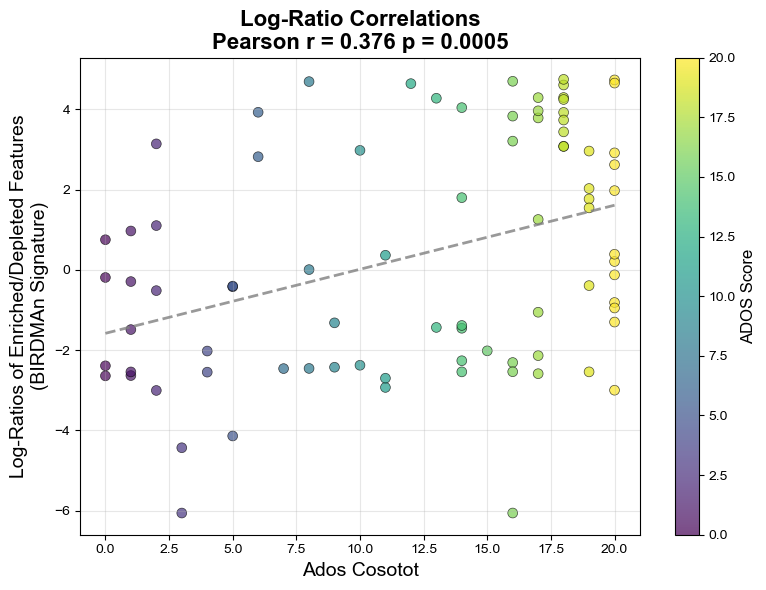


ados_cosototrrtot (original):
  Samples: 83
  Pearson r = 0.341
  P-value: 1.583e-03


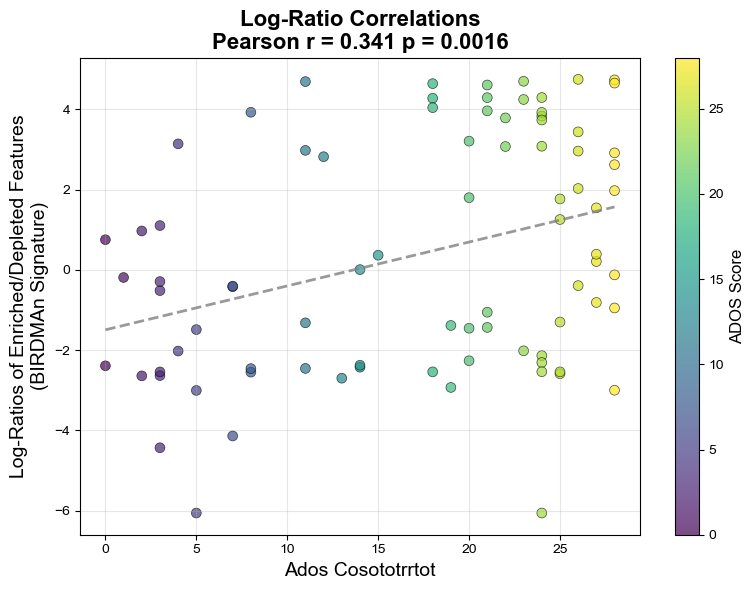


ados_rrtot (original):
  Samples: 83
  Pearson r = 0.202
  P-value: 6.640e-02


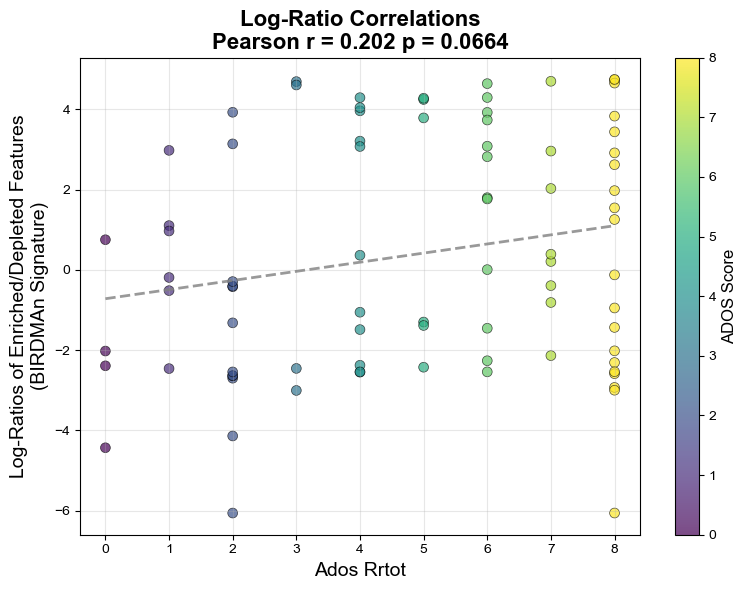


----------------------------------------
LONGITUDINAL ADOS TIMEPOINTS
----------------------------------------

ados_cosototrrtot (longitudinal):
  Samples: 49
  Pearson r = 0.391
  P-value: 5.533e-03


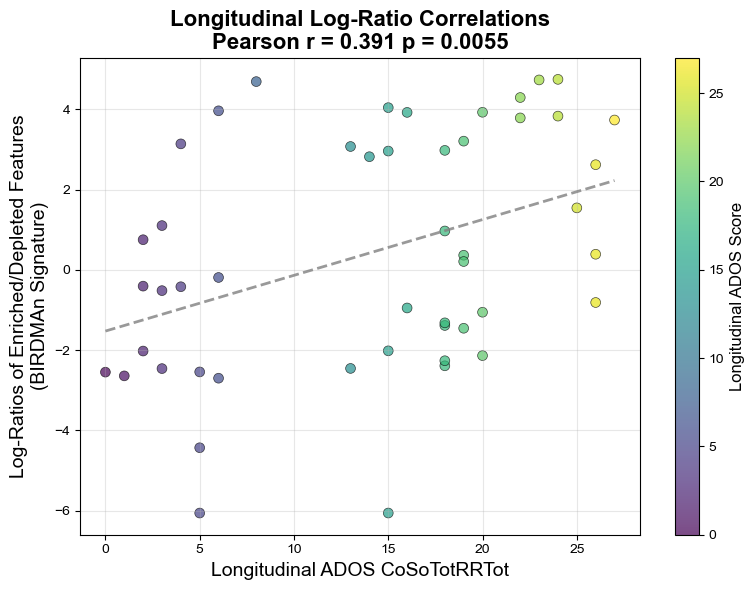


BIRDMAn-ADOS CORRELATION RESULTS SUMMARY
                     ados_measure     timepoint  correlation   p_value  \
0           ados_cosotot_original      original     0.375993  0.000460   
1      ados_cosototrrtot_original      original     0.341444  0.001583   
2             ados_rrtot_original      original     0.202471  0.066405   
3  ados_cosototrrtot_longitudinal  longitudinal     0.390529  0.005533   

      p_adj  significant  n_samples  
0  0.001840         True         83  
1  0.003166         True         83  
2  0.066405        False         83  
3  0.007377         True         49  

Results saved to 'BIRDMAn_ados_correlations.csv'

Significant correlations (FDR < 0.05): 3/4

Significant findings:
  ados_cosotot_original: r = 0.376, p_adj = 1.840e-03
  ados_cosototrrtot_original: r = 0.341, p_adj = 3.166e-03
  ados_cosototrrtot_longitudinal: r = 0.391, p_adj = 7.377e-03


In [225]:
# BIRDMAn Log Ratio - ADOS Correlation Analysis
# Adapted from the working Kyn/Trp correlation code

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from statsmodels.stats.multitest import multipletests

# Set font parameters for SVG output
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.sans-serif'] = 'Arial' 
plt.rcParams['svg.fonttype'] = 'none'

# Define ADOS columns to check
ados_columns = ['ados_cosotot', 'ados_cosototrrtot', 'ados_rrtot']

# Function to convert sample_name to subjectID (from your working code)
def sample_name_to_subject_id(sample_name):
    """Convert sample_name (15350.A5U7C.2) to subjectID (A5U7C)"""
    if isinstance(sample_name, str) and '.' in sample_name:
        parts = sample_name.split('.')
        if len(parts) >= 2:
            return parts[1]  # Extract middle part (A5U7C)
    return sample_name

print("Creating BIRDMAn microbiome signature from plot_df...")
print(f"plot_df shape: {plot_df.shape}")
print(f"plot_df columns: {plot_df.columns.tolist()}")

# Extract the BIRDMAn log ratios - use dx[T.TD]_mean column
ratio_col = 'dx[T.TD]_mean'
if ratio_col not in plot_df.columns:
    print(f"Error: Column '{ratio_col}' not found in plot_df")
    print("Available columns:", plot_df.columns.tolist())
else:
    # Get feature log ratios from plot_df (features are in index)
    feature_log_ratios = plot_df[ratio_col]
    features_of_interest = feature_log_ratios.index
    
    print(f"Features from BIRDMAn analysis: {len(features_of_interest)}")
    print("Sample feature IDs:", features_of_interest[:3].tolist())
    
    # Check overlap with abundance table
    available_features = table_metag_df.columns.intersection(features_of_interest)
    print(f"Features available in abundance table: {len(available_features)}")
    
    if len(available_features) == 0:
        print("No overlap between BIRDMAn features and abundance table")
        print("Sample abundance table features:", table_metag_df.columns[:3].tolist())
    else:
        # Calculate sample-level BIRDMAn signature scores
        print("Calculating sample-level BIRDMAn signatures...")
        
        sample_BIRDMAn_scores = []
        sample_ids = []
        
        for sample in table_metag_df.index:
            # Get abundances for this sample for the significant features
            sample_abundances = table_metag_df.loc[sample, available_features]
            
            # Get corresponding BIRDMAn effect sizes
            effect_sizes = feature_log_ratios.loc[available_features]
            
            # Calculate weighted average (abundance-weighted effect size)
            if sample_abundances.sum() > 0:
                weights = sample_abundances / sample_abundances.sum()
                weighted_score = (effect_sizes * weights).sum()
            else:
                weighted_score = np.nan
            
            sample_BIRDMAn_scores.append(weighted_score)
            sample_ids.append(sample)
        
        # Create the BIRDMAn signature series (analogous to log2_ratio in your Kyn/Trp code)
        BIRDMAn_signature = pd.Series(sample_BIRDMAn_scores, index=sample_ids)
        BIRDMAn_signature = BIRDMAn_signature.dropna()
        
        print(f"Calculated BIRDMAn signatures for {len(BIRDMAn_signature)} samples")
        
        # Create sample to subject mapping for longitudinal analysis
        sample_to_subject_mapping = {}
        for sample_name in BIRDMAn_signature.index:
            subject_id = sample_name_to_subject_id(sample_name)
            sample_to_subject_mapping[sample_name] = subject_id
        
        print(f"Created mapping for {len(sample_to_subject_mapping)} samples")
        print("Example mappings:")
        for i, (sample, subject) in enumerate(list(sample_to_subject_mapping.items())[:3]):
            print(f"  {sample} → {subject}")
        
        # Check which metadata to use (following your pattern)
        try:
            if 'ados_cosotot' in metadata.columns:
                metadata_for_ados = metadata
                print("Using qiita metadata for ADOS analysis")
            else:
                print("ADOS columns not found in qiita metadata")
                metadata_for_ados = None
        except:
            print("Error accessing qiita metadata")
            metadata_for_ados = None
        
        # Load longitudinal data if available
        try:
            cont_ados = pd.read_csv("data/metadata/uAutism_29AUG_longitudinaldata_lucasleo.csv", sep=",", index_col=0)
            print("Loaded longitudinal ADOS data")
            cont_ados_indexed = cont_ados
        except:
            print("Could not load longitudinal ADOS data")
            cont_ados_indexed = None
        
        if metadata_for_ados is not None:
            print("\n" + "="*60)
            print("BIRDMAn SIGNATURE - ADOS CORRELATION ANALYSIS")
            print("="*60)
            
            # Align samples
            common_samples = BIRDMAn_signature.index.intersection(metadata_for_ados.index)
            print(f"Common samples with original ADOS: {len(common_samples)}")
            
            # Check longitudinal data availability
            samples_with_longitudinal = []
            if cont_ados_indexed is not None:
                for sample in BIRDMAn_signature.index:
                    mapped_subject = sample_to_subject_mapping[sample]
                    if mapped_subject in cont_ados_indexed.index:
                        samples_with_longitudinal.append(sample)
                print(f"Samples with longitudinal ADOS data: {len(samples_with_longitudinal)}")
            
            ados_results = []
            
            # PART 1: Original ADOS timepoints
            print("\n" + "-"*40)
            print("ORIGINAL ADOS TIMEPOINTS")
            print("-"*40)
            
            for ados_col in ados_columns:
                if ados_col in metadata_for_ados.columns:
                    # Get values
                    ratio_vals = BIRDMAn_signature.loc[common_samples]
                    ados_vals = pd.to_numeric(metadata_for_ados.loc[common_samples, ados_col], 
                                             errors='coerce')
                    
                    # Remove NaN
                    valid = ~(ratio_vals.isna() | ados_vals.isna())
                    n_valid = valid.sum()
                    
                    if n_valid >= 10:
                        # Calculate Pearson correlation (like the reference image shows)
                        corr, pval = pearsonr(ratio_vals[valid], ados_vals[valid])
                        
                        ados_results.append({
                            'ados_measure': f'{ados_col}_original',
                            'timepoint': 'original',
                            'correlation': corr,
                            'p_value': pval,
                            'n_samples': n_valid
                        })
                        
                        print(f"\n{ados_col} (original):")
                        print(f"  Samples: {n_valid}")
                        print(f"  Pearson r = {corr:.3f}")
                        print(f"  P-value: {pval:.3e}")
                        
                        # Create scatter plot matching the reference style
                        plt.figure(figsize=(8, 6))
                        
                        # Create scatter with color mapping like the reference
                        scatter = plt.scatter(ados_vals[valid], ratio_vals[valid], 
                                           c=ados_vals[valid], cmap='viridis', 
                                           alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
                        
                        # Add trend line
                        z = np.polyfit(ados_vals[valid], ratio_vals[valid], 1)
                        p = np.poly1d(z)
                        x_line = np.linspace(ados_vals[valid].min(), ados_vals[valid].max(), 100)
                        plt.plot(x_line, p(x_line), "gray", linestyle='--', alpha=0.8, linewidth=2)
                        
                        # Formatting to match reference (with increased decimal places for p-value)
                        plt.xlabel(f'{ados_col.replace("_", " ").title()}', fontsize=14)
                        plt.ylabel('Log-Ratios of Enriched/Depleted Features\n(BIRDMAn Signature)', fontsize=14)
                        plt.title(f'Log-Ratio Correlations\nPearson r = {corr:.3f} p = {pval:.4f}', 
                                 fontsize=16, fontweight='bold')
                        
                        # Add colorbar
                        cbar = plt.colorbar(scatter)
                        cbar.set_label('ADOS Score', fontsize=12)
                        
                        # Grid
                        plt.grid(True, alpha=0.3)
                        plt.tight_layout()
                        
                        # Save as SVG
                        plt.savefig(f'BIRDMAn_ados_{ados_col}_correlation.svg', 
                                  format='svg', bbox_inches='tight')
                        plt.show()
                    else:
                        print(f"\nInsufficient samples for {ados_col}: {n_valid}")
            
            # PART 2: Longitudinal ADOS (if available)
            if cont_ados_indexed is not None and 'Longitudinal_ados_CoSoTotRRTot' in cont_ados_indexed.columns:
                print("\n" + "-"*40)
                print("LONGITUDINAL ADOS TIMEPOINTS")
                print("-"*40)
                
                if len(samples_with_longitudinal) >= 10:
                    # Extract values for samples with longitudinal data
                    ratio_vals_long = BIRDMAn_signature.loc[samples_with_longitudinal]
                    
                    # Extract longitudinal ADOS using subject mapping
                    subject_ids = [sample_to_subject_mapping[sample] for sample in samples_with_longitudinal]
                    ados_vals_long = pd.to_numeric(cont_ados_indexed.loc[subject_ids, 'Longitudinal_ados_CoSoTotRRTot'], 
                                                  errors='coerce')
                    ados_vals_long.index = samples_with_longitudinal
                    
                    # Remove NaN
                    valid_long = ~(ratio_vals_long.isna() | ados_vals_long.isna())
                    n_valid_long = valid_long.sum()
                    
                    if n_valid_long >= 10:
                        # Correlate
                        corr_long, pval_long = pearsonr(ratio_vals_long[valid_long], ados_vals_long[valid_long])
                        
                        ados_results.append({
                            'ados_measure': 'ados_cosototrrtot_longitudinal',
                            'timepoint': 'longitudinal',
                            'correlation': corr_long,
                            'p_value': pval_long,
                            'n_samples': n_valid_long
                        })
                        
                        print(f"\nados_cosototrrtot (longitudinal):")
                        print(f"  Samples: {n_valid_long}")
                        print(f"  Pearson r = {corr_long:.3f}")
                        print(f"  P-value: {pval_long:.3e}")
                        
                        # Create scatter plot
                        plt.figure(figsize=(8, 6))
                        scatter = plt.scatter(ados_vals_long[valid_long], ratio_vals_long[valid_long], 
                                           c=ados_vals_long[valid_long], cmap='viridis', 
                                           alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
                        
                        # Trend line
                        z = np.polyfit(ados_vals_long[valid_long], ratio_vals_long[valid_long], 1)
                        p = np.poly1d(z)
                        x_line = np.linspace(ados_vals_long[valid_long].min(), ados_vals_long[valid_long].max(), 100)
                        plt.plot(x_line, p(x_line), "gray", linestyle='--', alpha=0.8, linewidth=2)
                        
                        plt.xlabel('Longitudinal ADOS CoSoTotRRTot', fontsize=14)
                        plt.ylabel('Log-Ratios of Enriched/Depleted Features\n(BIRDMAn Signature)', fontsize=14)
                        plt.title(f'Longitudinal Log-Ratio Correlations\nPearson r = {corr_long:.3f} p = {pval_long:.4f}', 
                                 fontsize=16, fontweight='bold')
                        
                        cbar = plt.colorbar(scatter)
                        cbar.set_label('Longitudinal ADOS Score', fontsize=12)
                        plt.grid(True, alpha=0.3)
                        plt.tight_layout()
                        plt.savefig('BIRDMAn_ados_longitudinal_correlation.svg', 
                                  format='svg', bbox_inches='tight')
                        plt.show()
            
            # Summary results
            if ados_results:
                results_df = pd.DataFrame(ados_results)
                
                # FDR correction
                _, pvals_adj, _, _ = multipletests(results_df['p_value'], alpha=0.05, method='fdr_bh')
                results_df['p_adj'] = pvals_adj
                results_df['significant'] = results_df['p_adj'] < 0.05
                
                print("\n" + "="*60)
                print("BIRDMAn-ADOS CORRELATION RESULTS SUMMARY")
                print("="*60)
                print(results_df[['ados_measure', 'timepoint', 'correlation', 'p_value', 'p_adj', 'significant', 'n_samples']])
                
                # Save results
                results_df.to_csv('BIRDMAn_ados_correlations.csv', index=False)
                print("\nResults saved to 'BIRDMAn_ados_correlations.csv'")
                
                # Summary statistics
                n_sig = results_df['significant'].sum()
                print(f"\nSignificant correlations (FDR < 0.05): {n_sig}/{len(results_df)}")
                
                if n_sig > 0:
                    print("\nSignificant findings:")
                    sig_results = results_df[results_df['significant']]
                    for _, row in sig_results.iterrows():
                        print(f"  {row['ados_measure']}: r = {row['correlation']:.3f}, p_adj = {row['p_adj']:.3e}")
            else:
                print("No ADOS correlations could be computed")
        else:
            print("Cannot proceed - no ADOS metadata available")

# Rerun Diversity Metrics with Kyn/Trp Ratio

In [ ]:
qiita_metadata_df_subset

In [ ]:
# Append log2_ratio_full to qiita_metadata_df_subset
import pandas as pd

print("Before merging:")
print(f"qiita_metadata_df_subset shape: {qiita_metadata_df_subset.shape}")
print(f"log2_ratio_full length: {len(log2_ratio_full)}")

# Check sample name alignment
print(f"\nFirst 5 qiita_metadata sample names: {qiita_metadata_df_subset.index[:5].tolist()}")
print(f"First 5 log2_ratio_full sample names: {log2_ratio_full.index[:5].tolist()}")

# Check for exact overlap
common_samples = qiita_metadata_df_subset.index.intersection(log2_ratio_full.index)
print(f"\nCommon samples between datasets: {len(common_samples)}")

# Check if there are missing samples in either direction
missing_in_log2 = qiita_metadata_df_subset.index.difference(log2_ratio_full.index)
missing_in_metadata = log2_ratio_full.index.difference(qiita_metadata_df_subset.index)

print(f"Samples in metadata but not in log2_ratio_full: {len(missing_in_log2)}")
if len(missing_in_log2) > 0:
    print(f"  Missing samples: {missing_in_log2.tolist()}")

print(f"Samples in log2_ratio_full but not in metadata: {len(missing_in_metadata)}")
if len(missing_in_metadata) > 0:
    print(f"  Missing samples: {missing_in_metadata.tolist()}")

# Create a copy of the metadata to avoid modifying the original
qiita_metadata_with_ratio = qiita_metadata_df_subset.copy()

# Add the log2_ratio_full column
# Use left join to keep all metadata samples and add ratio where available
qiita_metadata_with_ratio = qiita_metadata_with_ratio.join(log2_ratio_full, how='left')

# Rename the column to be more descriptive
qiita_metadata_with_ratio = qiita_metadata_with_ratio.rename(columns={'kyn_trp_log2_ratio': 'kyn_trp_log2_ratio_full'})

print(f"\nAfter merging:")
print(f"qiita_metadata_with_ratio shape: {qiita_metadata_with_ratio.shape}")
print(f"New column added: 'kyn_trp_log2_ratio_full'")

# Check how many samples have ratio data
ratio_available = qiita_metadata_with_ratio['kyn_trp_log2_ratio_full'].notna().sum()
ratio_missing = qiita_metadata_with_ratio['kyn_trp_log2_ratio_full'].isna().sum()

print(f"\nRatio data availability:")
print(f"  Samples with ratio data: {ratio_available}")
print(f"  Samples missing ratio data: {ratio_missing}")
print(f"  Total samples: {len(qiita_metadata_with_ratio)}")

# Show some examples of the merged data
print(f"\nExample of merged data:")
example_cols = ['kyn_trp_log2_ratio_full']
if 'ados_cosotot' in qiita_metadata_with_ratio.columns:
    example_cols.append('ados_cosotot')
if 'diagnosis' in qiita_metadata_with_ratio.columns:
    example_cols.append('diagnosis')

print(qiita_metadata_with_ratio[example_cols].head(10))

# Summary statistics for the ratio column
print(f"\nSummary statistics for kyn_trp_log2_ratio_full:")
print(qiita_metadata_with_ratio['kyn_trp_log2_ratio_full'].describe())

# Check if all 81 samples from log2_ratio_full are included
if len(log2_ratio_full) == 81:
    all_ratios_included = (qiita_metadata_with_ratio['kyn_trp_log2_ratio_full'].notna().sum() == 81)
    print(f"\nAll 81 log2_ratio samples successfully included: {all_ratios_included}")
else:
    print(f"\nNote: log2_ratio_full has {len(log2_ratio_full)} samples, not 81")

# Save the merged dataset if desired
# qiita_metadata_with_ratio.to_csv('qiita_metadata_with_kyn_trp_ratio.csv')
# print("\nMerged dataset saved as 'qiita_metadata_with_kyn_trp_ratio.csv'")

print(f"\nFinal verification:")
print(f"Original metadata columns: {len(qiita_metadata_df_subset.columns)}")
print(f"New metadata columns: {len(qiita_metadata_with_ratio.columns)}")
print(f"Successfully added kyn_trp_log2_ratio_full column: {'kyn_trp_log2_ratio_full' in qiita_metadata_with_ratio.columns}")

In [ ]:
qiita_metadata_with_ratio.to_csv('out/multiomics/div_metrics/qiita_metadata_with_kyn_trp_ratio.tsv', sep='\t', index=True, header=True)
multiomics_div_md = pd.read_csv('out/multiomics/div_metrics/qiita_metadata_with_kyn_trp_ratio.tsv', sep='\t', index_col=0, header=0)
multiomics_div_md.index

In [ ]:
# Check if specific samples are in the metadata index
import pandas as pd

# Read the saved metadata file
multiomics_div_md = pd.read_csv('out/multiomics/div_metrics_500000/qiita_metadata_with_kyn_trp_ratio.tsv', 
                                sep='\t', index_col=0, header=0)

# Samples to check
samples_to_check = ['15350.B5Z8F.1', '15350.C2Q4J.1']

print(f"Total samples in metadata file: {len(multiomics_div_md)}")
print(f"Index name: {multiomics_div_md.index.name}")
print(f"\nFirst 5 samples in index: {multiomics_div_md.index[:5].tolist()}")

print(f"\nChecking for specific samples:")
for sample in samples_to_check:
    is_present = sample in multiomics_div_md.index
    print(f"  {sample}: {'✓ Present' if is_present else '✗ Not found'}")
    
    if is_present:
        # Show the ratio value for this sample if present
        ratio_value = multiomics_div_md.loc[sample, 'kyn_trp_log2_ratio_full']
        print(f"    kyn_trp_log2_ratio_full: {ratio_value}")

# Also check if they're in the original log2_ratio_full
print(f"\nChecking in original log2_ratio_full:")
for sample in samples_to_check:
    is_in_original = sample in log2_ratio_full.index
    print(f"  {sample}: {'✓ Present' if is_in_original else '✗ Not found'}")
    
    if is_in_original:
        ratio_value = log2_ratio_full.loc[sample]
        print(f"    log2_ratio_full value: {ratio_value}")

# Check if they're in the filtered version
print(f"\nChecking in filtered log2_ratio:")
for sample in samples_to_check:
    is_in_filtered = sample in log2_ratio.index
    print(f"  {sample}: {'✓ Present' if is_in_filtered else '✗ Not found (filtered out)'}")
    
    if is_in_filtered:
        ratio_value = log2_ratio.loc[sample]
        print(f"    filtered log2_ratio value: {ratio_value}")

# Summary
print(f"\nSummary:")
both_present = all(sample in multiomics_div_md.index for sample in samples_to_check)
print(f"Both samples present in metadata file: {both_present}")

# Show some context around these samples if they exist
print(f"\nContext - showing samples around these IDs:")
all_samples = multiomics_div_md.index.tolist()
for sample in samples_to_check:
    if sample in all_samples:
        idx = all_samples.index(sample)
        start_idx = max(0, idx - 2)
        end_idx = min(len(all_samples), idx + 3)
        print(f"\nAround {sample}:")
        for i in range(start_idx, end_idx):
            marker = " --> " if all_samples[i] == sample else "     "
            print(f"{marker}{all_samples[i]}")

In [ ]:
# qiime2 imports
import qiime2 as q2
from qiime2 import Artifact, Metadata, Visualization
from qiime2.plugins.feature_table.methods import filter_features, filter_samples
import qiime2.plugins.diversity.actions as diversity_actions


In [ ]:
table = Artifact.import_data("FeatureTable[Frequency]", "data/195330_zebra.biom/feature-table.biom")
phylogeny = Artifact.import_data("Phylogeny[Rooted]", "ref/tree.nwk")
sampling_depth = 500000
metadata = Metadata.load("out/multiomics/div_metrics_500000/qiita_metadata_with_kyn_trp_ratio.tsv")

In [ ]:
action_results = diversity_actions.core_metrics_phylogenetic(
    phylogeny=phylogeny,
    table=table,
    sampling_depth=sampling_depth,
    metadata=metadata,
    ignore_missing_samples=True
)
unweighted_unifrac_distance_matrix = action_results.unweighted_unifrac_distance_matrix
weighted_unifrac_distance_matrix = action_results.weighted_unifrac_distance_matrix
unweighted_unifrac_pcoa_results = action_results.unweighted_unifrac_pcoa_results
weighted_unifrac_pcoa_results = action_results.weighted_unifrac_pcoa_results
unweighted_unifrac_emperor_viz = action_results.unweighted_unifrac_emperor
weighted_unifrac_emperor_viz = action_results.weighted_unifrac_emperor

unweighted_unifrac_distance_matrix.save(f'out/multiomics/div_metrics_{sampling_depth}/unweighted_unifrac_distance_matrix.qza')
weighted_unifrac_distance_matrix.save(f'out/multiomics/div_metrics_{sampling_depth}/weighted_unifrac_distance_matrix.qza')
unweighted_unifrac_pcoa_results.save(f'out/multiomics/div_metrics_{sampling_depth}/unweighted_unifrac_pcoa_results.qza')
weighted_unifrac_pcoa_results.save(f'out/multiomics/div_metrics_{sampling_depth}/weighted_unifrac_pcoa_results.qza')
unweighted_unifrac_emperor_viz.save(f'out/multiomics/div_metrics_{sampling_depth}/unweighted_unifrac_emperor.qzv')
weighted_unifrac_emperor_viz.save(f'out/multiomics/div_metrics_{sampling_depth}/weighted_unifrac_emperor.qzv')
